### U-net with simple Resnet Blocks
#### update log
1. Correct the errors to in function iou_metric,  use "my_iou_metric" to moniter the training
2. Use image size 101 x 101, no resizing
3. Last layer dropout reduced by half
4. replace conv2D with 2 basic resnet blocks in each level of U-net
5.  Use faster rle_encode (> 10 times fater than RLenc ) from (https://www.kaggle.com/lpachuong/apply-crf-unet-bn-diceloss)
6. set  random_state= 1234 
7. I tweked the identity mapping as per the latest research papers in Resnet which helped me to push the score to 0.8

Reference kernels:

https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification

https://www.kaggle.com/tgibbons/u-net-without-resizing-images

https://www.kaggle.com/lpachuong/apply-crf-unet-bn-diceloss

The results seems not reproducible,  sometimes good (best around IOU0.79 ), sometimes  not as good!
Any suggestions to improve the results?

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2 
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img

Using TensorFlow backend.


In [2]:
# Set some parameters
img_size_ori = 101
img_size_target = 101
im_width = 101
im_height = 101
im_chan = 1
basicpath = '../input/'
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'



In [3]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [4]:
train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [5]:
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [6]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)


Text(0.5,0,'Coverage class')

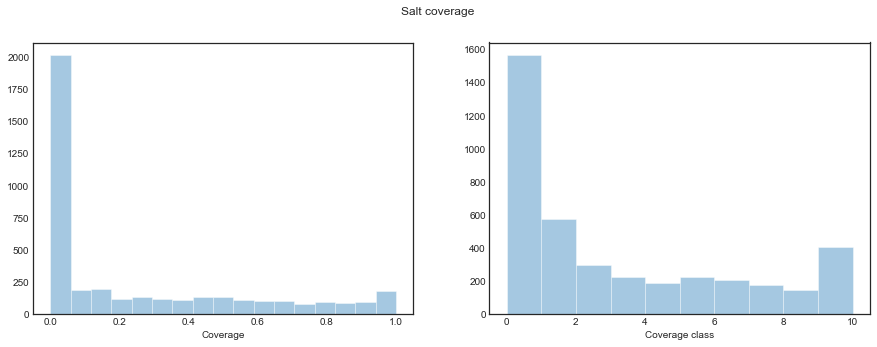

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5,1,'Depth distribution')

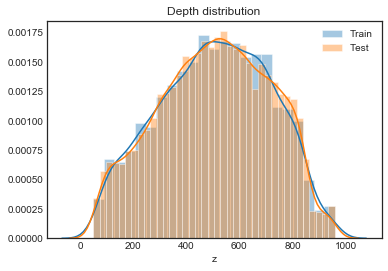

In [8]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [9]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

In [10]:
ACTIVATION = "relu"

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True, bn=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if bn == True:
        x = BatchNormalization()(x)
    if activation == True:
        x = Activation(ACTIVATION)(x)
    return x

# Proposed identity mapping

def residual_block(blockInput, num_filters=16):
    x = BatchNormalization()(blockInput)
    x = Activation(ACTIVATION)(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False, bn=False)
    x = Add()([x, blockInput])
    return x


In [11]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = Activation(ACTIVATION)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = Activation(ACTIVATION)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = Activation(ACTIVATION)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = Activation(ACTIVATION)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16)
    convm = Activation(ACTIVATION)(convm)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = Activation(ACTIVATION)(uconv4)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = Activation(ACTIVATION)(uconv3)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = Activation(ACTIVATION)(uconv2)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = Activation(ACTIVATION)(uconv1)
    
    uconv1 = Dropout(DropoutRatio/2)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [12]:
iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

def iou_metric(imgs_true, imgs_pred):
    num_images = len(imgs_true)
    scores = np.zeros(num_images)
    
    for i in range(num_images):
        if imgs_true[i].sum() == imgs_pred[i].sum() == 0:
            scores[i] = 1
        else:
            scores[i] = (iou_thresholds <= iou(imgs_true[i], imgs_pred[i])).mean()
            
    return scores.mean()

In [13]:
#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 101, 101, 1)
(800, 101, 101, 1)


In [14]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [15]:
early_stopping = EarlyStopping(monitor='val_acc', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint("./unet_best1.model",monitor='val_acc', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode = 'max',factor=0.5, patience=6, min_lr=0.001, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=1)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - ETA: 31:49 - loss: 0.8089 - acc: 0.48 - ETA: 16:05 - loss: 0.7335 - acc: 0.55 - ETA: 10:50 - loss: 0.7035 - acc: 0.59 - ETA: 8:13 - loss: 0.6710 - acc: 0.6300 - ETA: 6:38 - loss: 0.6427 - acc: 0.662 - ETA: 5:35 - loss: 0.6487 - acc: 0.667 - ETA: 4:50 - loss: 0.6496 - acc: 0.671 - ETA: 4:16 - loss: 0.6359 - acc: 0.684 - ETA: 3:50 - loss: 0.6252 - acc: 0.691 - ETA: 3:29 - loss: 0.6152 - acc: 0.698 - ETA: 3:11 - loss: 0.6065 - acc: 0.702 - ETA: 2:57 - loss: 0.5923 - acc: 0.711 - ETA: 2:44 - loss: 0.5793 - acc: 0.722 - ETA: 2:34 - loss: 0.5653 - acc: 0.730 - ETA: 2:25 - loss: 0.5625 - acc: 0.731 - ETA: 2:17 - loss: 0.5502 - acc: 0.737 - ETA: 2:10 - loss: 0.5427 - acc: 0.743 - ETA: 2:03 - loss: 0.5401 - acc: 0.746 - ETA: 1:58 - loss: 0.5397 - acc: 0.747 - ETA: 1:52 - loss: 0.5300 - acc: 0.752 - ETA: 1:48 - loss: 0.5225 - acc: 0.756 - ETA: 1:44 - loss: 0.5190 - acc: 0.759 - ETA: 1:40 - los

6400/6400 [==============================] - ETA: 31s - loss: 0.2593 - acc: 0.88 - ETA: 31s - loss: 0.2547 - acc: 0.89 - ETA: 30s - loss: 0.2747 - acc: 0.88 - ETA: 30s - loss: 0.2667 - acc: 0.89 - ETA: 30s - loss: 0.2751 - acc: 0.89 - ETA: 30s - loss: 0.2731 - acc: 0.89 - ETA: 30s - loss: 0.2655 - acc: 0.89 - ETA: 29s - loss: 0.2677 - acc: 0.90 - ETA: 29s - loss: 0.2634 - acc: 0.90 - ETA: 29s - loss: 0.2679 - acc: 0.90 - ETA: 29s - loss: 0.2566 - acc: 0.90 - ETA: 29s - loss: 0.2557 - acc: 0.90 - ETA: 29s - loss: 0.2493 - acc: 0.90 - ETA: 28s - loss: 0.2558 - acc: 0.90 - ETA: 28s - loss: 0.2581 - acc: 0.90 - ETA: 28s - loss: 0.2539 - acc: 0.90 - ETA: 28s - loss: 0.2517 - acc: 0.90 - ETA: 28s - loss: 0.2483 - acc: 0.90 - ETA: 28s - loss: 0.2491 - acc: 0.90 - ETA: 28s - loss: 0.2482 - acc: 0.90 - ETA: 27s - loss: 0.2501 - acc: 0.90 - ETA: 27s - loss: 0.2464 - acc: 0.90 - ETA: 27s - loss: 0.2475 - acc: 0.90 - ETA: 27s - loss: 0.2495 - acc: 0.90 - ETA: 27s - loss: 0.2469 - acc: 0.90 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.2379 - acc: 0.90 - ETA: 31s - loss: 0.2488 - acc: 0.91 - ETA: 31s - loss: 0.2462 - acc: 0.91 - ETA: 31s - loss: 0.2480 - acc: 0.91 - ETA: 30s - loss: 0.2420 - acc: 0.91 - ETA: 30s - loss: 0.2377 - acc: 0.91 - ETA: 30s - loss: 0.2394 - acc: 0.90 - ETA: 30s - loss: 0.2332 - acc: 0.91 - ETA: 29s - loss: 0.2342 - acc: 0.90 - ETA: 29s - loss: 0.2331 - acc: 0.90 - ETA: 29s - loss: 0.2317 - acc: 0.90 - ETA: 29s - loss: 0.2355 - acc: 0.90 - ETA: 29s - loss: 0.2377 - acc: 0.90 - ETA: 29s - loss: 0.2391 - acc: 0.90 - ETA: 29s - loss: 0.2437 - acc: 0.90 - ETA: 28s - loss: 0.2600 - acc: 0.90 - ETA: 28s - loss: 0.2577 - acc: 0.90 - ETA: 28s - loss: 0.2557 - acc: 0.90 - ETA: 28s - loss: 0.2595 - acc: 0.89 - ETA: 28s - loss: 0.2574 - acc: 0.89 - ETA: 27s - loss: 0.2609 - acc: 0.89 - ETA: 27s - loss: 0.2594 - acc: 0.89 - ETA: 27s - loss: 0.2597 - acc: 0.89 - ETA: 27s - loss: 0.2612 - acc: 0.89 - ETA: 27s - loss: 0.2598 - acc: 0.90 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.3485 - acc: 0.85 - ETA: 30s - loss: 0.3510 - acc: 0.85 - ETA: 30s - loss: 0.3163 - acc: 0.86 - ETA: 30s - loss: 0.3075 - acc: 0.87 - ETA: 29s - loss: 0.2969 - acc: 0.87 - ETA: 29s - loss: 0.2830 - acc: 0.88 - ETA: 29s - loss: 0.2795 - acc: 0.88 - ETA: 29s - loss: 0.2744 - acc: 0.89 - ETA: 29s - loss: 0.2675 - acc: 0.89 - ETA: 29s - loss: 0.2629 - acc: 0.89 - ETA: 29s - loss: 0.2585 - acc: 0.90 - ETA: 29s - loss: 0.2526 - acc: 0.90 - ETA: 29s - loss: 0.2470 - acc: 0.90 - ETA: 29s - loss: 0.2451 - acc: 0.90 - ETA: 29s - loss: 0.2395 - acc: 0.90 - ETA: 28s - loss: 0.2361 - acc: 0.91 - ETA: 28s - loss: 0.2383 - acc: 0.91 - ETA: 28s - loss: 0.2359 - acc: 0.91 - ETA: 28s - loss: 0.2395 - acc: 0.91 - ETA: 28s - loss: 0.2411 - acc: 0.90 - ETA: 28s - loss: 0.2357 - acc: 0.91 - ETA: 27s - loss: 0.2419 - acc: 0.90 - ETA: 27s - loss: 0.2390 - acc: 0.90 - ETA: 27s - loss: 0.2348 - acc: 0.91 - ETA: 27s - loss: 0.2318 - acc: 0.91 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.1651 - acc: 0.94 - ETA: 31s - loss: 0.2238 - acc: 0.91 - ETA: 30s - loss: 0.2301 - acc: 0.91 - ETA: 30s - loss: 0.2290 - acc: 0.91 - ETA: 30s - loss: 0.2244 - acc: 0.91 - ETA: 30s - loss: 0.2352 - acc: 0.90 - ETA: 30s - loss: 0.2409 - acc: 0.90 - ETA: 29s - loss: 0.2272 - acc: 0.91 - ETA: 29s - loss: 0.2191 - acc: 0.92 - ETA: 29s - loss: 0.2331 - acc: 0.91 - ETA: 29s - loss: 0.2237 - acc: 0.92 - ETA: 29s - loss: 0.2209 - acc: 0.92 - ETA: 29s - loss: 0.2192 - acc: 0.92 - ETA: 28s - loss: 0.2158 - acc: 0.92 - ETA: 28s - loss: 0.2130 - acc: 0.92 - ETA: 28s - loss: 0.2092 - acc: 0.92 - ETA: 28s - loss: 0.2036 - acc: 0.92 - ETA: 28s - loss: 0.2077 - acc: 0.92 - ETA: 28s - loss: 0.2061 - acc: 0.92 - ETA: 28s - loss: 0.2076 - acc: 0.92 - ETA: 27s - loss: 0.2082 - acc: 0.92 - ETA: 27s - loss: 0.2122 - acc: 0.92 - ETA: 27s - loss: 0.2121 - acc: 0.92 - ETA: 27s - loss: 0.2089 - acc: 0.92 - ETA: 27s - loss: 0.2067 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.1585 - acc: 0.93 - ETA: 31s - loss: 0.1741 - acc: 0.93 - ETA: 31s - loss: 0.1701 - acc: 0.93 - ETA: 30s - loss: 0.2131 - acc: 0.91 - ETA: 30s - loss: 0.1948 - acc: 0.92 - ETA: 30s - loss: 0.1836 - acc: 0.93 - ETA: 30s - loss: 0.1846 - acc: 0.93 - ETA: 30s - loss: 0.1796 - acc: 0.93 - ETA: 29s - loss: 0.1926 - acc: 0.92 - ETA: 29s - loss: 0.1959 - acc: 0.92 - ETA: 29s - loss: 0.1988 - acc: 0.92 - ETA: 29s - loss: 0.1969 - acc: 0.92 - ETA: 29s - loss: 0.1920 - acc: 0.92 - ETA: 29s - loss: 0.1932 - acc: 0.92 - ETA: 28s - loss: 0.1948 - acc: 0.92 - ETA: 28s - loss: 0.1948 - acc: 0.92 - ETA: 28s - loss: 0.1942 - acc: 0.92 - ETA: 28s - loss: 0.1980 - acc: 0.92 - ETA: 28s - loss: 0.1951 - acc: 0.92 - ETA: 28s - loss: 0.1942 - acc: 0.92 - ETA: 28s - loss: 0.1899 - acc: 0.92 - ETA: 27s - loss: 0.1902 - acc: 0.92 - ETA: 27s - loss: 0.1921 - acc: 0.92 - ETA: 27s - loss: 0.1936 - acc: 0.92 - ETA: 27s - loss: 0.1963 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1996 - acc: 0.92 - ETA: 30s - loss: 0.2662 - acc: 0.88 - ETA: 30s - loss: 0.2206 - acc: 0.91 - ETA: 30s - loss: 0.2551 - acc: 0.90 - ETA: 29s - loss: 0.2489 - acc: 0.90 - ETA: 29s - loss: 0.2339 - acc: 0.91 - ETA: 29s - loss: 0.2244 - acc: 0.91 - ETA: 29s - loss: 0.2335 - acc: 0.90 - ETA: 29s - loss: 0.2276 - acc: 0.90 - ETA: 29s - loss: 0.2194 - acc: 0.91 - ETA: 29s - loss: 0.2096 - acc: 0.91 - ETA: 28s - loss: 0.2054 - acc: 0.91 - ETA: 28s - loss: 0.1987 - acc: 0.92 - ETA: 28s - loss: 0.2028 - acc: 0.91 - ETA: 28s - loss: 0.2158 - acc: 0.91 - ETA: 28s - loss: 0.2121 - acc: 0.91 - ETA: 28s - loss: 0.2162 - acc: 0.91 - ETA: 28s - loss: 0.2093 - acc: 0.91 - ETA: 27s - loss: 0.2145 - acc: 0.91 - ETA: 27s - loss: 0.2204 - acc: 0.91 - ETA: 27s - loss: 0.2186 - acc: 0.91 - ETA: 27s - loss: 0.2152 - acc: 0.91 - ETA: 27s - loss: 0.2135 - acc: 0.91 - ETA: 27s - loss: 0.2095 - acc: 0.92 - ETA: 27s - loss: 0.2088 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1229 - acc: 0.95 - ETA: 30s - loss: 0.1311 - acc: 0.95 - ETA: 30s - loss: 0.1298 - acc: 0.95 - ETA: 30s - loss: 0.1644 - acc: 0.94 - ETA: 29s - loss: 0.1812 - acc: 0.93 - ETA: 29s - loss: 0.1748 - acc: 0.93 - ETA: 29s - loss: 0.1664 - acc: 0.94 - ETA: 29s - loss: 0.1679 - acc: 0.93 - ETA: 29s - loss: 0.1859 - acc: 0.93 - ETA: 29s - loss: 0.1911 - acc: 0.93 - ETA: 29s - loss: 0.1912 - acc: 0.93 - ETA: 29s - loss: 0.1841 - acc: 0.93 - ETA: 28s - loss: 0.1834 - acc: 0.93 - ETA: 28s - loss: 0.1867 - acc: 0.93 - ETA: 28s - loss: 0.1870 - acc: 0.93 - ETA: 28s - loss: 0.1913 - acc: 0.93 - ETA: 28s - loss: 0.1900 - acc: 0.93 - ETA: 28s - loss: 0.1943 - acc: 0.92 - ETA: 28s - loss: 0.1912 - acc: 0.92 - ETA: 27s - loss: 0.1867 - acc: 0.93 - ETA: 27s - loss: 0.1883 - acc: 0.92 - ETA: 27s - loss: 0.1917 - acc: 0.92 - ETA: 27s - loss: 0.1915 - acc: 0.92 - ETA: 27s - loss: 0.1924 - acc: 0.92 - ETA: 27s - loss: 0.1945 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.2167 - acc: 0.91 - ETA: 30s - loss: 0.2277 - acc: 0.91 - ETA: 30s - loss: 0.2394 - acc: 0.90 - ETA: 30s - loss: 0.2142 - acc: 0.91 - ETA: 30s - loss: 0.2301 - acc: 0.90 - ETA: 30s - loss: 0.2162 - acc: 0.91 - ETA: 30s - loss: 0.2099 - acc: 0.91 - ETA: 30s - loss: 0.2008 - acc: 0.91 - ETA: 29s - loss: 0.2000 - acc: 0.91 - ETA: 29s - loss: 0.1912 - acc: 0.92 - ETA: 29s - loss: 0.1931 - acc: 0.92 - ETA: 29s - loss: 0.1914 - acc: 0.92 - ETA: 29s - loss: 0.1935 - acc: 0.92 - ETA: 28s - loss: 0.1865 - acc: 0.92 - ETA: 28s - loss: 0.1867 - acc: 0.92 - ETA: 28s - loss: 0.1887 - acc: 0.92 - ETA: 28s - loss: 0.1856 - acc: 0.92 - ETA: 28s - loss: 0.1897 - acc: 0.92 - ETA: 28s - loss: 0.1936 - acc: 0.92 - ETA: 27s - loss: 0.1916 - acc: 0.92 - ETA: 27s - loss: 0.1905 - acc: 0.92 - ETA: 27s - loss: 0.1952 - acc: 0.92 - ETA: 27s - loss: 0.1936 - acc: 0.92 - ETA: 27s - loss: 0.1922 - acc: 0.92 - ETA: 27s - loss: 0.1911 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0921 - acc: 0.96 - ETA: 30s - loss: 0.0876 - acc: 0.97 - ETA: 30s - loss: 0.1170 - acc: 0.95 - ETA: 30s - loss: 0.1406 - acc: 0.95 - ETA: 30s - loss: 0.1576 - acc: 0.94 - ETA: 29s - loss: 0.1633 - acc: 0.94 - ETA: 29s - loss: 0.1517 - acc: 0.94 - ETA: 29s - loss: 0.1540 - acc: 0.94 - ETA: 29s - loss: 0.1535 - acc: 0.94 - ETA: 29s - loss: 0.1504 - acc: 0.94 - ETA: 29s - loss: 0.1472 - acc: 0.94 - ETA: 29s - loss: 0.1468 - acc: 0.95 - ETA: 29s - loss: 0.1480 - acc: 0.94 - ETA: 28s - loss: 0.1465 - acc: 0.94 - ETA: 28s - loss: 0.1465 - acc: 0.94 - ETA: 28s - loss: 0.1558 - acc: 0.94 - ETA: 28s - loss: 0.1540 - acc: 0.94 - ETA: 28s - loss: 0.1540 - acc: 0.94 - ETA: 28s - loss: 0.1559 - acc: 0.94 - ETA: 28s - loss: 0.1524 - acc: 0.94 - ETA: 27s - loss: 0.1496 - acc: 0.94 - ETA: 27s - loss: 0.1495 - acc: 0.94 - ETA: 27s - loss: 0.1473 - acc: 0.94 - ETA: 27s - loss: 0.1481 - acc: 0.94 - ETA: 27s - loss: 0.1492 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1272 - acc: 0.96 - ETA: 31s - loss: 0.2445 - acc: 0.92 - ETA: 31s - loss: 0.2324 - acc: 0.91 - ETA: 30s - loss: 0.2290 - acc: 0.91 - ETA: 30s - loss: 0.2162 - acc: 0.91 - ETA: 30s - loss: 0.2579 - acc: 0.90 - ETA: 30s - loss: 0.2424 - acc: 0.90 - ETA: 29s - loss: 0.2329 - acc: 0.91 - ETA: 29s - loss: 0.2268 - acc: 0.91 - ETA: 29s - loss: 0.2277 - acc: 0.91 - ETA: 29s - loss: 0.2253 - acc: 0.91 - ETA: 29s - loss: 0.2162 - acc: 0.92 - ETA: 29s - loss: 0.2116 - acc: 0.92 - ETA: 29s - loss: 0.2080 - acc: 0.92 - ETA: 28s - loss: 0.2033 - acc: 0.93 - ETA: 28s - loss: 0.1983 - acc: 0.93 - ETA: 28s - loss: 0.1914 - acc: 0.93 - ETA: 28s - loss: 0.1878 - acc: 0.93 - ETA: 28s - loss: 0.1833 - acc: 0.93 - ETA: 28s - loss: 0.1829 - acc: 0.93 - ETA: 27s - loss: 0.1847 - acc: 0.93 - ETA: 27s - loss: 0.1819 - acc: 0.93 - ETA: 27s - loss: 0.1795 - acc: 0.93 - ETA: 27s - loss: 0.1775 - acc: 0.93 - ETA: 27s - loss: 0.1798 - acc: 0.93 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1559 - acc: 0.94 - ETA: 30s - loss: 0.1364 - acc: 0.95 - ETA: 30s - loss: 0.1385 - acc: 0.95 - ETA: 30s - loss: 0.1425 - acc: 0.95 - ETA: 30s - loss: 0.1558 - acc: 0.95 - ETA: 29s - loss: 0.1470 - acc: 0.95 - ETA: 29s - loss: 0.1497 - acc: 0.95 - ETA: 29s - loss: 0.1524 - acc: 0.94 - ETA: 29s - loss: 0.1453 - acc: 0.95 - ETA: 29s - loss: 0.1382 - acc: 0.95 - ETA: 29s - loss: 0.1342 - acc: 0.95 - ETA: 28s - loss: 0.1408 - acc: 0.95 - ETA: 28s - loss: 0.1393 - acc: 0.95 - ETA: 28s - loss: 0.1482 - acc: 0.95 - ETA: 28s - loss: 0.1477 - acc: 0.95 - ETA: 28s - loss: 0.1485 - acc: 0.94 - ETA: 28s - loss: 0.1488 - acc: 0.94 - ETA: 28s - loss: 0.1467 - acc: 0.95 - ETA: 27s - loss: 0.1487 - acc: 0.94 - ETA: 27s - loss: 0.1492 - acc: 0.94 - ETA: 27s - loss: 0.1488 - acc: 0.94 - ETA: 27s - loss: 0.1559 - acc: 0.94 - ETA: 27s - loss: 0.1569 - acc: 0.94 - ETA: 27s - loss: 0.1564 - acc: 0.94 - ETA: 27s - loss: 0.1583 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.0853 - acc: 0.97 - ETA: 31s - loss: 0.2432 - acc: 0.91 - ETA: 30s - loss: 0.2046 - acc: 0.92 - ETA: 30s - loss: 0.1802 - acc: 0.93 - ETA: 30s - loss: 0.1665 - acc: 0.94 - ETA: 30s - loss: 0.1567 - acc: 0.94 - ETA: 30s - loss: 0.1623 - acc: 0.94 - ETA: 30s - loss: 0.1699 - acc: 0.93 - ETA: 29s - loss: 0.1639 - acc: 0.93 - ETA: 29s - loss: 0.1625 - acc: 0.93 - ETA: 29s - loss: 0.1683 - acc: 0.93 - ETA: 29s - loss: 0.1670 - acc: 0.93 - ETA: 29s - loss: 0.1644 - acc: 0.93 - ETA: 29s - loss: 0.1621 - acc: 0.94 - ETA: 28s - loss: 0.1691 - acc: 0.93 - ETA: 28s - loss: 0.1664 - acc: 0.93 - ETA: 28s - loss: 0.1682 - acc: 0.93 - ETA: 28s - loss: 0.1688 - acc: 0.93 - ETA: 28s - loss: 0.1657 - acc: 0.93 - ETA: 28s - loss: 0.1627 - acc: 0.93 - ETA: 27s - loss: 0.1609 - acc: 0.93 - ETA: 27s - loss: 0.1598 - acc: 0.93 - ETA: 27s - loss: 0.1574 - acc: 0.94 - ETA: 27s - loss: 0.1560 - acc: 0.94 - ETA: 27s - loss: 0.1551 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.2170 - acc: 0.91 - ETA: 30s - loss: 0.2424 - acc: 0.91 - ETA: 30s - loss: 0.2176 - acc: 0.92 - ETA: 29s - loss: 0.1959 - acc: 0.92 - ETA: 29s - loss: 0.1865 - acc: 0.93 - ETA: 29s - loss: 0.1739 - acc: 0.93 - ETA: 29s - loss: 0.1824 - acc: 0.93 - ETA: 29s - loss: 0.1756 - acc: 0.93 - ETA: 29s - loss: 0.1694 - acc: 0.94 - ETA: 29s - loss: 0.1690 - acc: 0.94 - ETA: 29s - loss: 0.1741 - acc: 0.93 - ETA: 28s - loss: 0.1647 - acc: 0.93 - ETA: 28s - loss: 0.1620 - acc: 0.93 - ETA: 28s - loss: 0.1598 - acc: 0.93 - ETA: 28s - loss: 0.1574 - acc: 0.94 - ETA: 28s - loss: 0.1553 - acc: 0.94 - ETA: 28s - loss: 0.1572 - acc: 0.94 - ETA: 28s - loss: 0.1538 - acc: 0.94 - ETA: 27s - loss: 0.1517 - acc: 0.94 - ETA: 27s - loss: 0.1529 - acc: 0.94 - ETA: 27s - loss: 0.1525 - acc: 0.94 - ETA: 27s - loss: 0.1554 - acc: 0.94 - ETA: 27s - loss: 0.1541 - acc: 0.94 - ETA: 27s - loss: 0.1562 - acc: 0.94 - ETA: 26s - loss: 0.1581 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1020 - acc: 0.96 - ETA: 30s - loss: 0.0983 - acc: 0.96 - ETA: 30s - loss: 0.1159 - acc: 0.96 - ETA: 30s - loss: 0.1406 - acc: 0.94 - ETA: 30s - loss: 0.1320 - acc: 0.94 - ETA: 29s - loss: 0.1274 - acc: 0.95 - ETA: 29s - loss: 0.1178 - acc: 0.95 - ETA: 29s - loss: 0.1106 - acc: 0.95 - ETA: 29s - loss: 0.1134 - acc: 0.95 - ETA: 29s - loss: 0.1112 - acc: 0.96 - ETA: 29s - loss: 0.1065 - acc: 0.96 - ETA: 28s - loss: 0.1055 - acc: 0.96 - ETA: 28s - loss: 0.1083 - acc: 0.96 - ETA: 28s - loss: 0.1084 - acc: 0.96 - ETA: 28s - loss: 0.1144 - acc: 0.95 - ETA: 28s - loss: 0.1116 - acc: 0.96 - ETA: 28s - loss: 0.1091 - acc: 0.96 - ETA: 28s - loss: 0.1128 - acc: 0.96 - ETA: 28s - loss: 0.1124 - acc: 0.96 - ETA: 27s - loss: 0.1114 - acc: 0.96 - ETA: 27s - loss: 0.1105 - acc: 0.96 - ETA: 27s - loss: 0.1152 - acc: 0.95 - ETA: 27s - loss: 0.1147 - acc: 0.95 - ETA: 27s - loss: 0.1125 - acc: 0.96 - ETA: 27s - loss: 0.1130 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0983 - acc: 0.96 - ETA: 30s - loss: 0.0952 - acc: 0.96 - ETA: 30s - loss: 0.1002 - acc: 0.96 - ETA: 30s - loss: 0.1020 - acc: 0.96 - ETA: 30s - loss: 0.1012 - acc: 0.96 - ETA: 29s - loss: 0.1188 - acc: 0.95 - ETA: 29s - loss: 0.1506 - acc: 0.94 - ETA: 30s - loss: 0.1563 - acc: 0.94 - ETA: 29s - loss: 0.1509 - acc: 0.94 - ETA: 29s - loss: 0.1455 - acc: 0.94 - ETA: 29s - loss: 0.1403 - acc: 0.94 - ETA: 29s - loss: 0.1438 - acc: 0.94 - ETA: 29s - loss: 0.1410 - acc: 0.94 - ETA: 29s - loss: 0.1365 - acc: 0.95 - ETA: 28s - loss: 0.1357 - acc: 0.95 - ETA: 28s - loss: 0.1320 - acc: 0.95 - ETA: 28s - loss: 0.1327 - acc: 0.95 - ETA: 28s - loss: 0.1355 - acc: 0.94 - ETA: 28s - loss: 0.1339 - acc: 0.95 - ETA: 28s - loss: 0.1318 - acc: 0.95 - ETA: 27s - loss: 0.1306 - acc: 0.95 - ETA: 27s - loss: 0.1306 - acc: 0.95 - ETA: 27s - loss: 0.1314 - acc: 0.94 - ETA: 27s - loss: 0.1306 - acc: 0.94 - ETA: 27s - loss: 0.1289 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0963 - acc: 0.97 - ETA: 30s - loss: 0.0904 - acc: 0.97 - ETA: 31s - loss: 0.0951 - acc: 0.96 - ETA: 30s - loss: 0.0991 - acc: 0.96 - ETA: 30s - loss: 0.1058 - acc: 0.96 - ETA: 30s - loss: 0.1039 - acc: 0.96 - ETA: 30s - loss: 0.1014 - acc: 0.96 - ETA: 30s - loss: 0.0958 - acc: 0.96 - ETA: 29s - loss: 0.1064 - acc: 0.96 - ETA: 29s - loss: 0.1073 - acc: 0.96 - ETA: 29s - loss: 0.1129 - acc: 0.95 - ETA: 29s - loss: 0.1075 - acc: 0.96 - ETA: 29s - loss: 0.1061 - acc: 0.96 - ETA: 29s - loss: 0.1165 - acc: 0.95 - ETA: 29s - loss: 0.1155 - acc: 0.95 - ETA: 28s - loss: 0.1192 - acc: 0.95 - ETA: 28s - loss: 0.1182 - acc: 0.95 - ETA: 28s - loss: 0.1203 - acc: 0.95 - ETA: 28s - loss: 0.1183 - acc: 0.95 - ETA: 28s - loss: 0.1181 - acc: 0.95 - ETA: 28s - loss: 0.1191 - acc: 0.95 - ETA: 28s - loss: 0.1180 - acc: 0.95 - ETA: 28s - loss: 0.1203 - acc: 0.95 - ETA: 27s - loss: 0.1224 - acc: 0.95 - ETA: 27s - loss: 0.1214 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1388 - acc: 0.96 - ETA: 30s - loss: 0.1233 - acc: 0.96 - ETA: 30s - loss: 0.1330 - acc: 0.95 - ETA: 30s - loss: 0.1338 - acc: 0.95 - ETA: 30s - loss: 0.1486 - acc: 0.94 - ETA: 30s - loss: 0.1411 - acc: 0.94 - ETA: 30s - loss: 0.1326 - acc: 0.94 - ETA: 30s - loss: 0.1355 - acc: 0.94 - ETA: 29s - loss: 0.1286 - acc: 0.95 - ETA: 29s - loss: 0.1325 - acc: 0.94 - ETA: 29s - loss: 0.1361 - acc: 0.94 - ETA: 29s - loss: 0.1320 - acc: 0.94 - ETA: 29s - loss: 0.1308 - acc: 0.94 - ETA: 29s - loss: 0.1291 - acc: 0.95 - ETA: 28s - loss: 0.1263 - acc: 0.95 - ETA: 28s - loss: 0.1250 - acc: 0.95 - ETA: 28s - loss: 0.1218 - acc: 0.95 - ETA: 28s - loss: 0.1184 - acc: 0.95 - ETA: 28s - loss: 0.1188 - acc: 0.95 - ETA: 28s - loss: 0.1213 - acc: 0.95 - ETA: 27s - loss: 0.1220 - acc: 0.95 - ETA: 27s - loss: 0.1242 - acc: 0.95 - ETA: 27s - loss: 0.1217 - acc: 0.95 - ETA: 27s - loss: 0.1211 - acc: 0.95 - ETA: 27s - loss: 0.1256 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1432 - acc: 0.96 - ETA: 30s - loss: 0.1217 - acc: 0.96 - ETA: 31s - loss: 0.1085 - acc: 0.97 - ETA: 30s - loss: 0.1348 - acc: 0.95 - ETA: 30s - loss: 0.1380 - acc: 0.94 - ETA: 30s - loss: 0.1471 - acc: 0.94 - ETA: 30s - loss: 0.1372 - acc: 0.94 - ETA: 30s - loss: 0.1415 - acc: 0.94 - ETA: 30s - loss: 0.1370 - acc: 0.94 - ETA: 29s - loss: 0.1423 - acc: 0.94 - ETA: 29s - loss: 0.1420 - acc: 0.94 - ETA: 29s - loss: 0.1552 - acc: 0.94 - ETA: 29s - loss: 0.1554 - acc: 0.94 - ETA: 29s - loss: 0.1551 - acc: 0.94 - ETA: 28s - loss: 0.1514 - acc: 0.94 - ETA: 28s - loss: 0.1534 - acc: 0.94 - ETA: 28s - loss: 0.1531 - acc: 0.94 - ETA: 28s - loss: 0.1546 - acc: 0.94 - ETA: 28s - loss: 0.1513 - acc: 0.94 - ETA: 28s - loss: 0.1493 - acc: 0.94 - ETA: 27s - loss: 0.1475 - acc: 0.94 - ETA: 27s - loss: 0.1473 - acc: 0.94 - ETA: 27s - loss: 0.1449 - acc: 0.94 - ETA: 27s - loss: 0.1422 - acc: 0.94 - ETA: 27s - loss: 0.1401 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1500 - acc: 0.95 - ETA: 30s - loss: 0.1419 - acc: 0.95 - ETA: 31s - loss: 0.1305 - acc: 0.96 - ETA: 30s - loss: 0.1271 - acc: 0.95 - ETA: 30s - loss: 0.1368 - acc: 0.95 - ETA: 30s - loss: 0.1431 - acc: 0.95 - ETA: 30s - loss: 0.1393 - acc: 0.95 - ETA: 30s - loss: 0.1338 - acc: 0.95 - ETA: 29s - loss: 0.1399 - acc: 0.95 - ETA: 30s - loss: 0.1368 - acc: 0.95 - ETA: 29s - loss: 0.1336 - acc: 0.95 - ETA: 29s - loss: 0.1388 - acc: 0.95 - ETA: 29s - loss: 0.1415 - acc: 0.94 - ETA: 29s - loss: 0.1425 - acc: 0.94 - ETA: 29s - loss: 0.1410 - acc: 0.94 - ETA: 28s - loss: 0.1401 - acc: 0.95 - ETA: 28s - loss: 0.1369 - acc: 0.95 - ETA: 28s - loss: 0.1356 - acc: 0.95 - ETA: 28s - loss: 0.1375 - acc: 0.95 - ETA: 28s - loss: 0.1411 - acc: 0.94 - ETA: 28s - loss: 0.1404 - acc: 0.94 - ETA: 27s - loss: 0.1377 - acc: 0.95 - ETA: 27s - loss: 0.1375 - acc: 0.95 - ETA: 27s - loss: 0.1394 - acc: 0.94 - ETA: 27s - loss: 0.1391 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1109 - acc: 0.95 - ETA: 30s - loss: 0.0932 - acc: 0.96 - ETA: 30s - loss: 0.0969 - acc: 0.96 - ETA: 30s - loss: 0.1017 - acc: 0.96 - ETA: 30s - loss: 0.0948 - acc: 0.96 - ETA: 29s - loss: 0.1006 - acc: 0.96 - ETA: 29s - loss: 0.1055 - acc: 0.96 - ETA: 29s - loss: 0.1068 - acc: 0.96 - ETA: 29s - loss: 0.1130 - acc: 0.96 - ETA: 29s - loss: 0.1268 - acc: 0.95 - ETA: 29s - loss: 0.1221 - acc: 0.95 - ETA: 28s - loss: 0.1211 - acc: 0.95 - ETA: 28s - loss: 0.1231 - acc: 0.95 - ETA: 28s - loss: 0.1230 - acc: 0.95 - ETA: 28s - loss: 0.1219 - acc: 0.95 - ETA: 28s - loss: 0.1193 - acc: 0.95 - ETA: 28s - loss: 0.1219 - acc: 0.95 - ETA: 28s - loss: 0.1242 - acc: 0.95 - ETA: 27s - loss: 0.1221 - acc: 0.95 - ETA: 27s - loss: 0.1207 - acc: 0.95 - ETA: 27s - loss: 0.1228 - acc: 0.95 - ETA: 27s - loss: 0.1215 - acc: 0.95 - ETA: 27s - loss: 0.1288 - acc: 0.95 - ETA: 27s - loss: 0.1266 - acc: 0.95 - ETA: 26s - loss: 0.1257 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0817 - acc: 0.96 - ETA: 30s - loss: 0.0992 - acc: 0.96 - ETA: 30s - loss: 0.1069 - acc: 0.95 - ETA: 30s - loss: 0.0971 - acc: 0.96 - ETA: 29s - loss: 0.1065 - acc: 0.95 - ETA: 29s - loss: 0.1063 - acc: 0.95 - ETA: 29s - loss: 0.1155 - acc: 0.95 - ETA: 29s - loss: 0.1245 - acc: 0.95 - ETA: 29s - loss: 0.1218 - acc: 0.95 - ETA: 29s - loss: 0.1205 - acc: 0.95 - ETA: 29s - loss: 0.1195 - acc: 0.95 - ETA: 29s - loss: 0.1214 - acc: 0.95 - ETA: 29s - loss: 0.1260 - acc: 0.95 - ETA: 28s - loss: 0.1206 - acc: 0.95 - ETA: 28s - loss: 0.1208 - acc: 0.95 - ETA: 28s - loss: 0.1209 - acc: 0.95 - ETA: 28s - loss: 0.1241 - acc: 0.95 - ETA: 28s - loss: 0.1206 - acc: 0.95 - ETA: 27s - loss: 0.1223 - acc: 0.95 - ETA: 27s - loss: 0.1209 - acc: 0.95 - ETA: 27s - loss: 0.1210 - acc: 0.95 - ETA: 27s - loss: 0.1204 - acc: 0.95 - ETA: 27s - loss: 0.1186 - acc: 0.95 - ETA: 27s - loss: 0.1202 - acc: 0.95 - ETA: 27s - loss: 0.1259 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1360 - acc: 0.94 - ETA: 30s - loss: 0.1208 - acc: 0.94 - ETA: 30s - loss: 0.1209 - acc: 0.95 - ETA: 30s - loss: 0.1175 - acc: 0.95 - ETA: 30s - loss: 0.1189 - acc: 0.95 - ETA: 30s - loss: 0.1196 - acc: 0.95 - ETA: 30s - loss: 0.1247 - acc: 0.95 - ETA: 29s - loss: 0.1219 - acc: 0.95 - ETA: 29s - loss: 0.1184 - acc: 0.95 - ETA: 29s - loss: 0.1229 - acc: 0.95 - ETA: 29s - loss: 0.1204 - acc: 0.95 - ETA: 29s - loss: 0.1234 - acc: 0.95 - ETA: 29s - loss: 0.1266 - acc: 0.95 - ETA: 29s - loss: 0.1247 - acc: 0.95 - ETA: 28s - loss: 0.1235 - acc: 0.95 - ETA: 28s - loss: 0.1222 - acc: 0.95 - ETA: 28s - loss: 0.1216 - acc: 0.95 - ETA: 28s - loss: 0.1208 - acc: 0.95 - ETA: 28s - loss: 0.1228 - acc: 0.95 - ETA: 28s - loss: 0.1227 - acc: 0.95 - ETA: 27s - loss: 0.1198 - acc: 0.95 - ETA: 27s - loss: 0.1188 - acc: 0.95 - ETA: 27s - loss: 0.1206 - acc: 0.95 - ETA: 27s - loss: 0.1216 - acc: 0.95 - ETA: 27s - loss: 0.1209 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0658 - acc: 0.97 - ETA: 30s - loss: 0.0852 - acc: 0.97 - ETA: 30s - loss: 0.1068 - acc: 0.95 - ETA: 29s - loss: 0.1038 - acc: 0.96 - ETA: 29s - loss: 0.1108 - acc: 0.95 - ETA: 29s - loss: 0.1220 - acc: 0.95 - ETA: 29s - loss: 0.1165 - acc: 0.95 - ETA: 29s - loss: 0.1136 - acc: 0.95 - ETA: 29s - loss: 0.1137 - acc: 0.95 - ETA: 29s - loss: 0.1181 - acc: 0.95 - ETA: 29s - loss: 0.1184 - acc: 0.95 - ETA: 29s - loss: 0.1152 - acc: 0.95 - ETA: 29s - loss: 0.1173 - acc: 0.95 - ETA: 28s - loss: 0.1146 - acc: 0.95 - ETA: 28s - loss: 0.1148 - acc: 0.95 - ETA: 28s - loss: 0.1168 - acc: 0.95 - ETA: 28s - loss: 0.1143 - acc: 0.95 - ETA: 28s - loss: 0.1231 - acc: 0.95 - ETA: 28s - loss: 0.1214 - acc: 0.95 - ETA: 27s - loss: 0.1221 - acc: 0.95 - ETA: 27s - loss: 0.1236 - acc: 0.95 - ETA: 27s - loss: 0.1231 - acc: 0.95 - ETA: 27s - loss: 0.1225 - acc: 0.95 - ETA: 27s - loss: 0.1215 - acc: 0.95 - ETA: 27s - loss: 0.1205 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1017 - acc: 0.95 - ETA: 30s - loss: 0.1775 - acc: 0.93 - ETA: 30s - loss: 0.1642 - acc: 0.93 - ETA: 30s - loss: 0.1635 - acc: 0.93 - ETA: 29s - loss: 0.1514 - acc: 0.93 - ETA: 29s - loss: 0.1465 - acc: 0.94 - ETA: 29s - loss: 0.1404 - acc: 0.94 - ETA: 29s - loss: 0.1324 - acc: 0.94 - ETA: 29s - loss: 0.1398 - acc: 0.94 - ETA: 29s - loss: 0.1332 - acc: 0.94 - ETA: 29s - loss: 0.1317 - acc: 0.94 - ETA: 28s - loss: 0.1279 - acc: 0.94 - ETA: 28s - loss: 0.1266 - acc: 0.94 - ETA: 28s - loss: 0.1244 - acc: 0.95 - ETA: 28s - loss: 0.1197 - acc: 0.95 - ETA: 28s - loss: 0.1245 - acc: 0.95 - ETA: 28s - loss: 0.1192 - acc: 0.95 - ETA: 27s - loss: 0.1190 - acc: 0.95 - ETA: 27s - loss: 0.1204 - acc: 0.95 - ETA: 27s - loss: 0.1228 - acc: 0.95 - ETA: 27s - loss: 0.1246 - acc: 0.95 - ETA: 27s - loss: 0.1276 - acc: 0.94 - ETA: 27s - loss: 0.1288 - acc: 0.94 - ETA: 27s - loss: 0.1317 - acc: 0.94 - ETA: 26s - loss: 0.1296 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1126 - acc: 0.95 - ETA: 30s - loss: 0.1170 - acc: 0.95 - ETA: 30s - loss: 0.1142 - acc: 0.95 - ETA: 30s - loss: 0.1126 - acc: 0.95 - ETA: 29s - loss: 0.1044 - acc: 0.95 - ETA: 29s - loss: 0.1125 - acc: 0.95 - ETA: 29s - loss: 0.1104 - acc: 0.95 - ETA: 29s - loss: 0.1078 - acc: 0.95 - ETA: 29s - loss: 0.1036 - acc: 0.95 - ETA: 29s - loss: 0.1044 - acc: 0.95 - ETA: 29s - loss: 0.1029 - acc: 0.96 - ETA: 29s - loss: 0.1023 - acc: 0.96 - ETA: 28s - loss: 0.0990 - acc: 0.96 - ETA: 28s - loss: 0.0981 - acc: 0.96 - ETA: 28s - loss: 0.0987 - acc: 0.96 - ETA: 28s - loss: 0.0963 - acc: 0.96 - ETA: 28s - loss: 0.0956 - acc: 0.96 - ETA: 28s - loss: 0.0971 - acc: 0.96 - ETA: 27s - loss: 0.0952 - acc: 0.96 - ETA: 27s - loss: 0.0960 - acc: 0.96 - ETA: 27s - loss: 0.0948 - acc: 0.96 - ETA: 27s - loss: 0.0935 - acc: 0.96 - ETA: 27s - loss: 0.0916 - acc: 0.96 - ETA: 27s - loss: 0.0908 - acc: 0.96 - ETA: 27s - loss: 0.0917 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.1099 - acc: 0.95 - ETA: 32s - loss: 0.1192 - acc: 0.95 - ETA: 31s - loss: 0.1346 - acc: 0.95 - ETA: 31s - loss: 0.1369 - acc: 0.95 - ETA: 31s - loss: 0.1308 - acc: 0.95 - ETA: 31s - loss: 0.1409 - acc: 0.94 - ETA: 30s - loss: 0.1484 - acc: 0.94 - ETA: 30s - loss: 0.1568 - acc: 0.94 - ETA: 30s - loss: 0.1483 - acc: 0.94 - ETA: 30s - loss: 0.1491 - acc: 0.94 - ETA: 29s - loss: 0.1478 - acc: 0.94 - ETA: 29s - loss: 0.1424 - acc: 0.95 - ETA: 29s - loss: 0.1376 - acc: 0.95 - ETA: 29s - loss: 0.1443 - acc: 0.94 - ETA: 29s - loss: 0.1461 - acc: 0.94 - ETA: 29s - loss: 0.1455 - acc: 0.94 - ETA: 28s - loss: 0.1432 - acc: 0.94 - ETA: 28s - loss: 0.1427 - acc: 0.94 - ETA: 28s - loss: 0.1491 - acc: 0.94 - ETA: 28s - loss: 0.1500 - acc: 0.94 - ETA: 28s - loss: 0.1464 - acc: 0.94 - ETA: 28s - loss: 0.1455 - acc: 0.94 - ETA: 27s - loss: 0.1468 - acc: 0.94 - ETA: 27s - loss: 0.1464 - acc: 0.94 - ETA: 27s - loss: 0.1470 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0437 - acc: 0.98 - ETA: 30s - loss: 0.0839 - acc: 0.96 - ETA: 30s - loss: 0.0734 - acc: 0.96 - ETA: 30s - loss: 0.0772 - acc: 0.97 - ETA: 30s - loss: 0.0936 - acc: 0.96 - ETA: 29s - loss: 0.1011 - acc: 0.95 - ETA: 29s - loss: 0.1019 - acc: 0.95 - ETA: 29s - loss: 0.0989 - acc: 0.96 - ETA: 29s - loss: 0.0940 - acc: 0.96 - ETA: 29s - loss: 0.0914 - acc: 0.96 - ETA: 29s - loss: 0.0962 - acc: 0.96 - ETA: 29s - loss: 0.0928 - acc: 0.96 - ETA: 29s - loss: 0.0983 - acc: 0.96 - ETA: 29s - loss: 0.0951 - acc: 0.96 - ETA: 28s - loss: 0.0969 - acc: 0.96 - ETA: 28s - loss: 0.0955 - acc: 0.96 - ETA: 28s - loss: 0.0927 - acc: 0.96 - ETA: 28s - loss: 0.0919 - acc: 0.96 - ETA: 28s - loss: 0.0942 - acc: 0.96 - ETA: 28s - loss: 0.0930 - acc: 0.96 - ETA: 27s - loss: 0.0969 - acc: 0.96 - ETA: 27s - loss: 0.0983 - acc: 0.96 - ETA: 27s - loss: 0.0997 - acc: 0.96 - ETA: 27s - loss: 0.1011 - acc: 0.96 - ETA: 27s - loss: 0.1049 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0910 - acc: 0.96 - ETA: 30s - loss: 0.1257 - acc: 0.95 - ETA: 30s - loss: 0.1050 - acc: 0.96 - ETA: 30s - loss: 0.1027 - acc: 0.96 - ETA: 30s - loss: 0.1012 - acc: 0.96 - ETA: 30s - loss: 0.0993 - acc: 0.96 - ETA: 29s - loss: 0.0950 - acc: 0.96 - ETA: 29s - loss: 0.0957 - acc: 0.96 - ETA: 29s - loss: 0.0982 - acc: 0.96 - ETA: 29s - loss: 0.1015 - acc: 0.96 - ETA: 29s - loss: 0.0992 - acc: 0.96 - ETA: 29s - loss: 0.1062 - acc: 0.96 - ETA: 29s - loss: 0.1051 - acc: 0.96 - ETA: 28s - loss: 0.1016 - acc: 0.96 - ETA: 28s - loss: 0.1080 - acc: 0.96 - ETA: 28s - loss: 0.1071 - acc: 0.96 - ETA: 28s - loss: 0.1077 - acc: 0.96 - ETA: 28s - loss: 0.1051 - acc: 0.96 - ETA: 28s - loss: 0.1049 - acc: 0.96 - ETA: 28s - loss: 0.1087 - acc: 0.96 - ETA: 27s - loss: 0.1075 - acc: 0.96 - ETA: 27s - loss: 0.1133 - acc: 0.95 - ETA: 27s - loss: 0.1158 - acc: 0.95 - ETA: 27s - loss: 0.1183 - acc: 0.95 - ETA: 27s - loss: 0.1175 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.1518 - acc: 0.94 - ETA: 31s - loss: 0.1232 - acc: 0.95 - ETA: 31s - loss: 0.1017 - acc: 0.96 - ETA: 31s - loss: 0.0891 - acc: 0.96 - ETA: 31s - loss: 0.0876 - acc: 0.97 - ETA: 30s - loss: 0.0899 - acc: 0.96 - ETA: 30s - loss: 0.0933 - acc: 0.96 - ETA: 30s - loss: 0.0901 - acc: 0.96 - ETA: 30s - loss: 0.0894 - acc: 0.96 - ETA: 30s - loss: 0.0855 - acc: 0.96 - ETA: 30s - loss: 0.0874 - acc: 0.96 - ETA: 30s - loss: 0.0861 - acc: 0.96 - ETA: 29s - loss: 0.0839 - acc: 0.96 - ETA: 29s - loss: 0.0810 - acc: 0.97 - ETA: 29s - loss: 0.0868 - acc: 0.96 - ETA: 29s - loss: 0.0975 - acc: 0.96 - ETA: 29s - loss: 0.0977 - acc: 0.96 - ETA: 29s - loss: 0.0991 - acc: 0.96 - ETA: 28s - loss: 0.0980 - acc: 0.96 - ETA: 28s - loss: 0.0967 - acc: 0.96 - ETA: 28s - loss: 0.0955 - acc: 0.96 - ETA: 28s - loss: 0.0974 - acc: 0.96 - ETA: 28s - loss: 0.1031 - acc: 0.96 - ETA: 28s - loss: 0.1041 - acc: 0.96 - ETA: 27s - loss: 0.1065 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0949 - acc: 0.95 - ETA: 30s - loss: 0.1556 - acc: 0.93 - ETA: 30s - loss: 0.1361 - acc: 0.94 - ETA: 30s - loss: 0.1357 - acc: 0.94 - ETA: 29s - loss: 0.1297 - acc: 0.94 - ETA: 29s - loss: 0.1210 - acc: 0.95 - ETA: 29s - loss: 0.1203 - acc: 0.95 - ETA: 29s - loss: 0.1134 - acc: 0.95 - ETA: 29s - loss: 0.1259 - acc: 0.95 - ETA: 29s - loss: 0.1228 - acc: 0.95 - ETA: 29s - loss: 0.1183 - acc: 0.95 - ETA: 29s - loss: 0.1228 - acc: 0.95 - ETA: 28s - loss: 0.1190 - acc: 0.95 - ETA: 28s - loss: 0.1175 - acc: 0.95 - ETA: 28s - loss: 0.1144 - acc: 0.95 - ETA: 28s - loss: 0.1124 - acc: 0.95 - ETA: 28s - loss: 0.1125 - acc: 0.95 - ETA: 28s - loss: 0.1122 - acc: 0.95 - ETA: 28s - loss: 0.1113 - acc: 0.95 - ETA: 27s - loss: 0.1096 - acc: 0.95 - ETA: 27s - loss: 0.1088 - acc: 0.95 - ETA: 27s - loss: 0.1103 - acc: 0.95 - ETA: 27s - loss: 0.1143 - acc: 0.95 - ETA: 27s - loss: 0.1141 - acc: 0.95 - ETA: 27s - loss: 0.1178 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.0830 - acc: 0.97 - ETA: 31s - loss: 0.1175 - acc: 0.95 - ETA: 30s - loss: 0.1669 - acc: 0.93 - ETA: 30s - loss: 0.1454 - acc: 0.94 - ETA: 30s - loss: 0.1411 - acc: 0.94 - ETA: 30s - loss: 0.1297 - acc: 0.95 - ETA: 30s - loss: 0.1267 - acc: 0.95 - ETA: 30s - loss: 0.1172 - acc: 0.95 - ETA: 29s - loss: 0.1160 - acc: 0.95 - ETA: 29s - loss: 0.1111 - acc: 0.96 - ETA: 29s - loss: 0.1127 - acc: 0.95 - ETA: 29s - loss: 0.1103 - acc: 0.95 - ETA: 29s - loss: 0.1132 - acc: 0.95 - ETA: 29s - loss: 0.1112 - acc: 0.95 - ETA: 29s - loss: 0.1106 - acc: 0.95 - ETA: 28s - loss: 0.1075 - acc: 0.95 - ETA: 28s - loss: 0.1076 - acc: 0.95 - ETA: 28s - loss: 0.1055 - acc: 0.96 - ETA: 28s - loss: 0.1058 - acc: 0.95 - ETA: 28s - loss: 0.1117 - acc: 0.95 - ETA: 28s - loss: 0.1114 - acc: 0.95 - ETA: 27s - loss: 0.1138 - acc: 0.95 - ETA: 27s - loss: 0.1130 - acc: 0.95 - ETA: 27s - loss: 0.1108 - acc: 0.95 - ETA: 27s - loss: 0.1106 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 29s - loss: 0.1833 - acc: 0.95 - ETA: 30s - loss: 0.1479 - acc: 0.95 - ETA: 30s - loss: 0.1437 - acc: 0.95 - ETA: 30s - loss: 0.1407 - acc: 0.95 - ETA: 29s - loss: 0.1348 - acc: 0.95 - ETA: 29s - loss: 0.1431 - acc: 0.94 - ETA: 29s - loss: 0.1373 - acc: 0.95 - ETA: 29s - loss: 0.1307 - acc: 0.95 - ETA: 29s - loss: 0.1410 - acc: 0.94 - ETA: 29s - loss: 0.1386 - acc: 0.94 - ETA: 29s - loss: 0.1370 - acc: 0.95 - ETA: 29s - loss: 0.1345 - acc: 0.95 - ETA: 29s - loss: 0.1363 - acc: 0.94 - ETA: 28s - loss: 0.1347 - acc: 0.94 - ETA: 28s - loss: 0.1301 - acc: 0.95 - ETA: 28s - loss: 0.1259 - acc: 0.95 - ETA: 28s - loss: 0.1211 - acc: 0.95 - ETA: 28s - loss: 0.1209 - acc: 0.95 - ETA: 28s - loss: 0.1263 - acc: 0.95 - ETA: 28s - loss: 0.1247 - acc: 0.95 - ETA: 28s - loss: 0.1261 - acc: 0.95 - ETA: 27s - loss: 0.1251 - acc: 0.95 - ETA: 27s - loss: 0.1227 - acc: 0.95 - ETA: 27s - loss: 0.1221 - acc: 0.95 - ETA: 27s - loss: 0.1211 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1102 - acc: 0.95 - ETA: 31s - loss: 0.1019 - acc: 0.96 - ETA: 30s - loss: 0.0979 - acc: 0.96 - ETA: 30s - loss: 0.0957 - acc: 0.96 - ETA: 30s - loss: 0.0919 - acc: 0.97 - ETA: 30s - loss: 0.0968 - acc: 0.96 - ETA: 30s - loss: 0.1018 - acc: 0.96 - ETA: 30s - loss: 0.0981 - acc: 0.96 - ETA: 30s - loss: 0.0990 - acc: 0.96 - ETA: 30s - loss: 0.1065 - acc: 0.96 - ETA: 30s - loss: 0.1060 - acc: 0.96 - ETA: 29s - loss: 0.1060 - acc: 0.96 - ETA: 29s - loss: 0.1039 - acc: 0.96 - ETA: 29s - loss: 0.1076 - acc: 0.96 - ETA: 29s - loss: 0.1075 - acc: 0.96 - ETA: 29s - loss: 0.1062 - acc: 0.96 - ETA: 29s - loss: 0.1119 - acc: 0.95 - ETA: 28s - loss: 0.1129 - acc: 0.95 - ETA: 28s - loss: 0.1111 - acc: 0.96 - ETA: 28s - loss: 0.1093 - acc: 0.96 - ETA: 28s - loss: 0.1079 - acc: 0.96 - ETA: 28s - loss: 0.1072 - acc: 0.96 - ETA: 28s - loss: 0.1072 - acc: 0.96 - ETA: 27s - loss: 0.1086 - acc: 0.96 - ETA: 27s - loss: 0.1085 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1737 - acc: 0.91 - ETA: 30s - loss: 0.1278 - acc: 0.94 - ETA: 30s - loss: 0.1055 - acc: 0.95 - ETA: 30s - loss: 0.1009 - acc: 0.95 - ETA: 30s - loss: 0.0954 - acc: 0.96 - ETA: 30s - loss: 0.0907 - acc: 0.96 - ETA: 29s - loss: 0.0955 - acc: 0.96 - ETA: 29s - loss: 0.0946 - acc: 0.96 - ETA: 29s - loss: 0.0949 - acc: 0.96 - ETA: 29s - loss: 0.0996 - acc: 0.96 - ETA: 29s - loss: 0.1051 - acc: 0.96 - ETA: 29s - loss: 0.0996 - acc: 0.96 - ETA: 29s - loss: 0.0987 - acc: 0.96 - ETA: 28s - loss: 0.0972 - acc: 0.96 - ETA: 28s - loss: 0.0990 - acc: 0.96 - ETA: 28s - loss: 0.0972 - acc: 0.96 - ETA: 28s - loss: 0.0961 - acc: 0.96 - ETA: 28s - loss: 0.0947 - acc: 0.96 - ETA: 28s - loss: 0.0931 - acc: 0.96 - ETA: 27s - loss: 0.0923 - acc: 0.96 - ETA: 27s - loss: 0.0926 - acc: 0.96 - ETA: 27s - loss: 0.0931 - acc: 0.96 - ETA: 27s - loss: 0.0935 - acc: 0.96 - ETA: 27s - loss: 0.0921 - acc: 0.96 - ETA: 27s - loss: 0.0917 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.2375 - acc: 0.90 - ETA: 30s - loss: 0.1580 - acc: 0.94 - ETA: 30s - loss: 0.1298 - acc: 0.95 - ETA: 30s - loss: 0.1332 - acc: 0.95 - ETA: 30s - loss: 0.1351 - acc: 0.95 - ETA: 30s - loss: 0.1271 - acc: 0.95 - ETA: 29s - loss: 0.1225 - acc: 0.95 - ETA: 29s - loss: 0.1185 - acc: 0.95 - ETA: 29s - loss: 0.1158 - acc: 0.95 - ETA: 29s - loss: 0.1161 - acc: 0.95 - ETA: 29s - loss: 0.1186 - acc: 0.95 - ETA: 29s - loss: 0.1136 - acc: 0.95 - ETA: 28s - loss: 0.1130 - acc: 0.95 - ETA: 28s - loss: 0.1150 - acc: 0.95 - ETA: 28s - loss: 0.1108 - acc: 0.95 - ETA: 28s - loss: 0.1095 - acc: 0.95 - ETA: 28s - loss: 0.1080 - acc: 0.96 - ETA: 28s - loss: 0.1102 - acc: 0.96 - ETA: 27s - loss: 0.1097 - acc: 0.95 - ETA: 27s - loss: 0.1070 - acc: 0.96 - ETA: 27s - loss: 0.1056 - acc: 0.96 - ETA: 27s - loss: 0.1041 - acc: 0.96 - ETA: 27s - loss: 0.1015 - acc: 0.96 - ETA: 27s - loss: 0.0997 - acc: 0.96 - ETA: 27s - loss: 0.1002 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1034 - acc: 0.96 - ETA: 30s - loss: 0.1016 - acc: 0.96 - ETA: 30s - loss: 0.0893 - acc: 0.96 - ETA: 30s - loss: 0.0866 - acc: 0.96 - ETA: 30s - loss: 0.1034 - acc: 0.96 - ETA: 30s - loss: 0.0998 - acc: 0.96 - ETA: 29s - loss: 0.1141 - acc: 0.95 - ETA: 29s - loss: 0.1160 - acc: 0.95 - ETA: 29s - loss: 0.1119 - acc: 0.95 - ETA: 29s - loss: 0.1132 - acc: 0.95 - ETA: 29s - loss: 0.1143 - acc: 0.95 - ETA: 29s - loss: 0.1143 - acc: 0.95 - ETA: 28s - loss: 0.1235 - acc: 0.94 - ETA: 28s - loss: 0.1244 - acc: 0.94 - ETA: 28s - loss: 0.1245 - acc: 0.94 - ETA: 28s - loss: 0.1238 - acc: 0.94 - ETA: 28s - loss: 0.1227 - acc: 0.94 - ETA: 28s - loss: 0.1199 - acc: 0.95 - ETA: 27s - loss: 0.1172 - acc: 0.95 - ETA: 27s - loss: 0.1158 - acc: 0.95 - ETA: 27s - loss: 0.1130 - acc: 0.95 - ETA: 27s - loss: 0.1115 - acc: 0.95 - ETA: 27s - loss: 0.1255 - acc: 0.95 - ETA: 27s - loss: 0.1288 - acc: 0.95 - ETA: 27s - loss: 0.1298 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1206 - acc: 0.95 - ETA: 30s - loss: 0.0821 - acc: 0.96 - ETA: 30s - loss: 0.0803 - acc: 0.97 - ETA: 30s - loss: 0.0769 - acc: 0.97 - ETA: 30s - loss: 0.0789 - acc: 0.96 - ETA: 30s - loss: 0.0817 - acc: 0.96 - ETA: 30s - loss: 0.0791 - acc: 0.97 - ETA: 29s - loss: 0.0907 - acc: 0.96 - ETA: 29s - loss: 0.0909 - acc: 0.96 - ETA: 29s - loss: 0.0928 - acc: 0.96 - ETA: 29s - loss: 0.0883 - acc: 0.96 - ETA: 29s - loss: 0.0910 - acc: 0.96 - ETA: 29s - loss: 0.0931 - acc: 0.96 - ETA: 29s - loss: 0.1011 - acc: 0.96 - ETA: 28s - loss: 0.1004 - acc: 0.96 - ETA: 28s - loss: 0.0978 - acc: 0.96 - ETA: 28s - loss: 0.0970 - acc: 0.96 - ETA: 28s - loss: 0.0939 - acc: 0.96 - ETA: 28s - loss: 0.0939 - acc: 0.96 - ETA: 27s - loss: 0.0931 - acc: 0.96 - ETA: 27s - loss: 0.0909 - acc: 0.96 - ETA: 27s - loss: 0.0909 - acc: 0.96 - ETA: 27s - loss: 0.0947 - acc: 0.96 - ETA: 27s - loss: 0.0939 - acc: 0.96 - ETA: 27s - loss: 0.0930 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1112 - acc: 0.96 - ETA: 30s - loss: 0.0834 - acc: 0.97 - ETA: 30s - loss: 0.0753 - acc: 0.97 - ETA: 30s - loss: 0.0703 - acc: 0.97 - ETA: 29s - loss: 0.0794 - acc: 0.97 - ETA: 29s - loss: 0.0826 - acc: 0.97 - ETA: 29s - loss: 0.0808 - acc: 0.97 - ETA: 29s - loss: 0.0774 - acc: 0.97 - ETA: 29s - loss: 0.0757 - acc: 0.97 - ETA: 29s - loss: 0.0891 - acc: 0.97 - ETA: 29s - loss: 0.0881 - acc: 0.97 - ETA: 28s - loss: 0.0892 - acc: 0.97 - ETA: 28s - loss: 0.0896 - acc: 0.97 - ETA: 28s - loss: 0.0868 - acc: 0.97 - ETA: 28s - loss: 0.0902 - acc: 0.96 - ETA: 28s - loss: 0.0906 - acc: 0.96 - ETA: 28s - loss: 0.0897 - acc: 0.96 - ETA: 27s - loss: 0.0955 - acc: 0.96 - ETA: 27s - loss: 0.0945 - acc: 0.96 - ETA: 27s - loss: 0.0923 - acc: 0.96 - ETA: 27s - loss: 0.0938 - acc: 0.96 - ETA: 27s - loss: 0.0925 - acc: 0.96 - ETA: 27s - loss: 0.0924 - acc: 0.96 - ETA: 27s - loss: 0.0907 - acc: 0.96 - ETA: 27s - loss: 0.0915 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0793 - acc: 0.97 - ETA: 30s - loss: 0.0783 - acc: 0.97 - ETA: 30s - loss: 0.0889 - acc: 0.96 - ETA: 30s - loss: 0.1030 - acc: 0.95 - ETA: 29s - loss: 0.1054 - acc: 0.95 - ETA: 29s - loss: 0.1104 - acc: 0.95 - ETA: 30s - loss: 0.1028 - acc: 0.96 - ETA: 29s - loss: 0.0952 - acc: 0.96 - ETA: 29s - loss: 0.0997 - acc: 0.96 - ETA: 29s - loss: 0.1019 - acc: 0.95 - ETA: 29s - loss: 0.0978 - acc: 0.96 - ETA: 29s - loss: 0.0922 - acc: 0.96 - ETA: 29s - loss: 0.0970 - acc: 0.96 - ETA: 28s - loss: 0.0998 - acc: 0.95 - ETA: 28s - loss: 0.1041 - acc: 0.95 - ETA: 28s - loss: 0.1068 - acc: 0.95 - ETA: 28s - loss: 0.1072 - acc: 0.95 - ETA: 28s - loss: 0.1046 - acc: 0.95 - ETA: 28s - loss: 0.1048 - acc: 0.95 - ETA: 27s - loss: 0.1040 - acc: 0.95 - ETA: 27s - loss: 0.1064 - acc: 0.95 - ETA: 27s - loss: 0.1075 - acc: 0.95 - ETA: 27s - loss: 0.1062 - acc: 0.95 - ETA: 27s - loss: 0.1061 - acc: 0.95 - ETA: 27s - loss: 0.1050 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0681 - acc: 0.97 - ETA: 30s - loss: 0.0656 - acc: 0.98 - ETA: 30s - loss: 0.0816 - acc: 0.97 - ETA: 30s - loss: 0.0829 - acc: 0.97 - ETA: 30s - loss: 0.0757 - acc: 0.97 - ETA: 29s - loss: 0.0841 - acc: 0.97 - ETA: 29s - loss: 0.0947 - acc: 0.96 - ETA: 29s - loss: 0.0946 - acc: 0.96 - ETA: 29s - loss: 0.0918 - acc: 0.96 - ETA: 29s - loss: 0.0865 - acc: 0.96 - ETA: 29s - loss: 0.0831 - acc: 0.97 - ETA: 29s - loss: 0.0828 - acc: 0.97 - ETA: 28s - loss: 0.0836 - acc: 0.96 - ETA: 28s - loss: 0.0858 - acc: 0.96 - ETA: 28s - loss: 0.0866 - acc: 0.96 - ETA: 28s - loss: 0.0863 - acc: 0.96 - ETA: 28s - loss: 0.0859 - acc: 0.96 - ETA: 28s - loss: 0.0921 - acc: 0.96 - ETA: 27s - loss: 0.0938 - acc: 0.96 - ETA: 27s - loss: 0.0969 - acc: 0.96 - ETA: 27s - loss: 0.1012 - acc: 0.96 - ETA: 27s - loss: 0.1052 - acc: 0.96 - ETA: 27s - loss: 0.1048 - acc: 0.96 - ETA: 27s - loss: 0.1045 - acc: 0.96 - ETA: 27s - loss: 0.1040 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0827 - acc: 0.98 - ETA: 30s - loss: 0.1243 - acc: 0.95 - ETA: 30s - loss: 0.1220 - acc: 0.95 - ETA: 30s - loss: 0.1127 - acc: 0.96 - ETA: 30s - loss: 0.1109 - acc: 0.96 - ETA: 30s - loss: 0.1161 - acc: 0.95 - ETA: 30s - loss: 0.1214 - acc: 0.95 - ETA: 30s - loss: 0.1217 - acc: 0.95 - ETA: 30s - loss: 0.1166 - acc: 0.95 - ETA: 29s - loss: 0.1125 - acc: 0.95 - ETA: 29s - loss: 0.1102 - acc: 0.95 - ETA: 29s - loss: 0.1085 - acc: 0.95 - ETA: 29s - loss: 0.1104 - acc: 0.95 - ETA: 29s - loss: 0.1068 - acc: 0.95 - ETA: 29s - loss: 0.1060 - acc: 0.95 - ETA: 28s - loss: 0.1023 - acc: 0.96 - ETA: 28s - loss: 0.1004 - acc: 0.96 - ETA: 28s - loss: 0.1004 - acc: 0.96 - ETA: 28s - loss: 0.1025 - acc: 0.96 - ETA: 28s - loss: 0.0987 - acc: 0.96 - ETA: 28s - loss: 0.0979 - acc: 0.96 - ETA: 28s - loss: 0.0963 - acc: 0.96 - ETA: 27s - loss: 0.0959 - acc: 0.96 - ETA: 27s - loss: 0.0943 - acc: 0.96 - ETA: 27s - loss: 0.0929 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0941 - acc: 0.96 - ETA: 30s - loss: 0.1471 - acc: 0.93 - ETA: 30s - loss: 0.1402 - acc: 0.94 - ETA: 30s - loss: 0.1452 - acc: 0.94 - ETA: 30s - loss: 0.1522 - acc: 0.93 - ETA: 30s - loss: 0.1403 - acc: 0.94 - ETA: 29s - loss: 0.1348 - acc: 0.94 - ETA: 29s - loss: 0.1323 - acc: 0.94 - ETA: 29s - loss: 0.1322 - acc: 0.95 - ETA: 29s - loss: 0.1287 - acc: 0.95 - ETA: 29s - loss: 0.1269 - acc: 0.95 - ETA: 29s - loss: 0.1303 - acc: 0.95 - ETA: 29s - loss: 0.1267 - acc: 0.95 - ETA: 28s - loss: 0.1238 - acc: 0.95 - ETA: 28s - loss: 0.1234 - acc: 0.95 - ETA: 28s - loss: 0.1204 - acc: 0.95 - ETA: 28s - loss: 0.1191 - acc: 0.95 - ETA: 28s - loss: 0.1155 - acc: 0.95 - ETA: 28s - loss: 0.1133 - acc: 0.95 - ETA: 27s - loss: 0.1097 - acc: 0.95 - ETA: 27s - loss: 0.1166 - acc: 0.95 - ETA: 27s - loss: 0.1141 - acc: 0.95 - ETA: 27s - loss: 0.1122 - acc: 0.95 - ETA: 27s - loss: 0.1126 - acc: 0.95 - ETA: 27s - loss: 0.1162 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0686 - acc: 0.98 - ETA: 30s - loss: 0.0705 - acc: 0.97 - ETA: 30s - loss: 0.0680 - acc: 0.97 - ETA: 30s - loss: 0.0604 - acc: 0.98 - ETA: 29s - loss: 0.0670 - acc: 0.97 - ETA: 29s - loss: 0.0637 - acc: 0.97 - ETA: 29s - loss: 0.0617 - acc: 0.97 - ETA: 29s - loss: 0.0751 - acc: 0.97 - ETA: 29s - loss: 0.0738 - acc: 0.97 - ETA: 29s - loss: 0.0705 - acc: 0.97 - ETA: 29s - loss: 0.0779 - acc: 0.97 - ETA: 29s - loss: 0.0794 - acc: 0.97 - ETA: 28s - loss: 0.0805 - acc: 0.97 - ETA: 28s - loss: 0.0812 - acc: 0.96 - ETA: 28s - loss: 0.0815 - acc: 0.96 - ETA: 28s - loss: 0.0903 - acc: 0.96 - ETA: 28s - loss: 0.0897 - acc: 0.96 - ETA: 28s - loss: 0.0880 - acc: 0.96 - ETA: 27s - loss: 0.0942 - acc: 0.96 - ETA: 27s - loss: 0.0968 - acc: 0.96 - ETA: 27s - loss: 0.0943 - acc: 0.96 - ETA: 27s - loss: 0.0953 - acc: 0.96 - ETA: 27s - loss: 0.0975 - acc: 0.96 - ETA: 27s - loss: 0.0967 - acc: 0.96 - ETA: 27s - loss: 0.0965 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0698 - acc: 0.97 - ETA: 30s - loss: 0.0714 - acc: 0.97 - ETA: 30s - loss: 0.0762 - acc: 0.97 - ETA: 30s - loss: 0.0869 - acc: 0.96 - ETA: 29s - loss: 0.0891 - acc: 0.96 - ETA: 29s - loss: 0.0905 - acc: 0.96 - ETA: 30s - loss: 0.0892 - acc: 0.96 - ETA: 30s - loss: 0.0939 - acc: 0.96 - ETA: 29s - loss: 0.0937 - acc: 0.96 - ETA: 29s - loss: 0.0914 - acc: 0.96 - ETA: 29s - loss: 0.0877 - acc: 0.96 - ETA: 29s - loss: 0.0847 - acc: 0.96 - ETA: 29s - loss: 0.0836 - acc: 0.96 - ETA: 28s - loss: 0.0887 - acc: 0.96 - ETA: 28s - loss: 0.0918 - acc: 0.96 - ETA: 28s - loss: 0.0897 - acc: 0.96 - ETA: 28s - loss: 0.0876 - acc: 0.96 - ETA: 28s - loss: 0.0864 - acc: 0.96 - ETA: 28s - loss: 0.0870 - acc: 0.96 - ETA: 28s - loss: 0.0874 - acc: 0.96 - ETA: 27s - loss: 0.0857 - acc: 0.96 - ETA: 27s - loss: 0.0860 - acc: 0.96 - ETA: 27s - loss: 0.0889 - acc: 0.96 - ETA: 27s - loss: 0.0876 - acc: 0.96 - ETA: 27s - loss: 0.0883 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1251 - acc: 0.95 - ETA: 30s - loss: 0.0811 - acc: 0.97 - ETA: 30s - loss: 0.0848 - acc: 0.96 - ETA: 30s - loss: 0.0807 - acc: 0.97 - ETA: 30s - loss: 0.0750 - acc: 0.97 - ETA: 30s - loss: 0.0734 - acc: 0.97 - ETA: 30s - loss: 0.0839 - acc: 0.97 - ETA: 30s - loss: 0.0871 - acc: 0.97 - ETA: 30s - loss: 0.0875 - acc: 0.96 - ETA: 29s - loss: 0.0829 - acc: 0.97 - ETA: 29s - loss: 0.0984 - acc: 0.96 - ETA: 29s - loss: 0.1015 - acc: 0.96 - ETA: 29s - loss: 0.1021 - acc: 0.96 - ETA: 29s - loss: 0.1025 - acc: 0.96 - ETA: 28s - loss: 0.1033 - acc: 0.96 - ETA: 28s - loss: 0.1019 - acc: 0.96 - ETA: 28s - loss: 0.1057 - acc: 0.96 - ETA: 28s - loss: 0.1057 - acc: 0.96 - ETA: 28s - loss: 0.1031 - acc: 0.96 - ETA: 28s - loss: 0.1033 - acc: 0.96 - ETA: 28s - loss: 0.1047 - acc: 0.96 - ETA: 27s - loss: 0.1032 - acc: 0.96 - ETA: 27s - loss: 0.1023 - acc: 0.96 - ETA: 27s - loss: 0.1028 - acc: 0.96 - ETA: 27s - loss: 0.1015 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0990 - acc: 0.96 - ETA: 30s - loss: 0.1395 - acc: 0.94 - ETA: 30s - loss: 0.1242 - acc: 0.94 - ETA: 30s - loss: 0.1065 - acc: 0.95 - ETA: 30s - loss: 0.0960 - acc: 0.96 - ETA: 30s - loss: 0.0880 - acc: 0.96 - ETA: 29s - loss: 0.0824 - acc: 0.97 - ETA: 29s - loss: 0.0838 - acc: 0.97 - ETA: 29s - loss: 0.0889 - acc: 0.96 - ETA: 29s - loss: 0.0902 - acc: 0.96 - ETA: 29s - loss: 0.0923 - acc: 0.96 - ETA: 29s - loss: 0.0985 - acc: 0.96 - ETA: 29s - loss: 0.0940 - acc: 0.96 - ETA: 29s - loss: 0.0960 - acc: 0.96 - ETA: 28s - loss: 0.0947 - acc: 0.96 - ETA: 28s - loss: 0.0963 - acc: 0.96 - ETA: 28s - loss: 0.0958 - acc: 0.96 - ETA: 28s - loss: 0.0938 - acc: 0.96 - ETA: 28s - loss: 0.0946 - acc: 0.96 - ETA: 28s - loss: 0.0932 - acc: 0.96 - ETA: 27s - loss: 0.0946 - acc: 0.96 - ETA: 27s - loss: 0.0933 - acc: 0.96 - ETA: 27s - loss: 0.0916 - acc: 0.96 - ETA: 27s - loss: 0.0920 - acc: 0.96 - ETA: 27s - loss: 0.0950 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0758 - acc: 0.97 - ETA: 30s - loss: 0.0719 - acc: 0.97 - ETA: 30s - loss: 0.0953 - acc: 0.96 - ETA: 30s - loss: 0.0841 - acc: 0.97 - ETA: 30s - loss: 0.0974 - acc: 0.96 - ETA: 30s - loss: 0.0966 - acc: 0.96 - ETA: 29s - loss: 0.0951 - acc: 0.96 - ETA: 29s - loss: 0.0973 - acc: 0.96 - ETA: 29s - loss: 0.0934 - acc: 0.96 - ETA: 29s - loss: 0.0899 - acc: 0.96 - ETA: 29s - loss: 0.0895 - acc: 0.96 - ETA: 29s - loss: 0.0882 - acc: 0.96 - ETA: 28s - loss: 0.0887 - acc: 0.96 - ETA: 28s - loss: 0.0881 - acc: 0.96 - ETA: 28s - loss: 0.0854 - acc: 0.97 - ETA: 28s - loss: 0.0856 - acc: 0.96 - ETA: 28s - loss: 0.0877 - acc: 0.96 - ETA: 28s - loss: 0.0893 - acc: 0.96 - ETA: 27s - loss: 0.0878 - acc: 0.96 - ETA: 27s - loss: 0.0883 - acc: 0.96 - ETA: 27s - loss: 0.0867 - acc: 0.96 - ETA: 27s - loss: 0.0850 - acc: 0.96 - ETA: 27s - loss: 0.0862 - acc: 0.96 - ETA: 27s - loss: 0.0846 - acc: 0.96 - ETA: 27s - loss: 0.0841 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0498 - acc: 0.98 - ETA: 30s - loss: 0.0610 - acc: 0.97 - ETA: 30s - loss: 0.0814 - acc: 0.96 - ETA: 30s - loss: 0.0717 - acc: 0.97 - ETA: 30s - loss: 0.0690 - acc: 0.97 - ETA: 30s - loss: 0.0681 - acc: 0.97 - ETA: 30s - loss: 0.0663 - acc: 0.97 - ETA: 29s - loss: 0.0696 - acc: 0.97 - ETA: 29s - loss: 0.0688 - acc: 0.97 - ETA: 29s - loss: 0.0662 - acc: 0.97 - ETA: 29s - loss: 0.0662 - acc: 0.97 - ETA: 29s - loss: 0.0766 - acc: 0.97 - ETA: 29s - loss: 0.0760 - acc: 0.97 - ETA: 28s - loss: 0.0802 - acc: 0.97 - ETA: 28s - loss: 0.0800 - acc: 0.97 - ETA: 28s - loss: 0.0862 - acc: 0.96 - ETA: 28s - loss: 0.0864 - acc: 0.96 - ETA: 28s - loss: 0.0843 - acc: 0.96 - ETA: 28s - loss: 0.0816 - acc: 0.97 - ETA: 27s - loss: 0.0836 - acc: 0.96 - ETA: 27s - loss: 0.0826 - acc: 0.97 - ETA: 27s - loss: 0.0849 - acc: 0.96 - ETA: 27s - loss: 0.0854 - acc: 0.96 - ETA: 27s - loss: 0.0847 - acc: 0.96 - ETA: 27s - loss: 0.0845 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0830 - acc: 0.96 - ETA: 30s - loss: 0.0816 - acc: 0.97 - ETA: 30s - loss: 0.0845 - acc: 0.97 - ETA: 30s - loss: 0.0968 - acc: 0.96 - ETA: 30s - loss: 0.0925 - acc: 0.96 - ETA: 29s - loss: 0.0874 - acc: 0.96 - ETA: 29s - loss: 0.0930 - acc: 0.96 - ETA: 30s - loss: 0.0913 - acc: 0.96 - ETA: 29s - loss: 0.0929 - acc: 0.96 - ETA: 29s - loss: 0.0911 - acc: 0.96 - ETA: 29s - loss: 0.0876 - acc: 0.96 - ETA: 29s - loss: 0.0890 - acc: 0.96 - ETA: 29s - loss: 0.0929 - acc: 0.96 - ETA: 29s - loss: 0.0910 - acc: 0.96 - ETA: 28s - loss: 0.0899 - acc: 0.96 - ETA: 28s - loss: 0.0885 - acc: 0.96 - ETA: 28s - loss: 0.0864 - acc: 0.96 - ETA: 28s - loss: 0.0862 - acc: 0.96 - ETA: 28s - loss: 0.0892 - acc: 0.96 - ETA: 28s - loss: 0.0889 - acc: 0.96 - ETA: 27s - loss: 0.0878 - acc: 0.96 - ETA: 27s - loss: 0.0903 - acc: 0.96 - ETA: 27s - loss: 0.0925 - acc: 0.96 - ETA: 27s - loss: 0.0918 - acc: 0.96 - ETA: 27s - loss: 0.0914 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1793 - acc: 0.94 - ETA: 30s - loss: 0.1187 - acc: 0.96 - ETA: 30s - loss: 0.1155 - acc: 0.95 - ETA: 30s - loss: 0.1083 - acc: 0.96 - ETA: 30s - loss: 0.1033 - acc: 0.96 - ETA: 30s - loss: 0.0979 - acc: 0.96 - ETA: 30s - loss: 0.0983 - acc: 0.96 - ETA: 30s - loss: 0.1000 - acc: 0.96 - ETA: 29s - loss: 0.0942 - acc: 0.96 - ETA: 29s - loss: 0.0909 - acc: 0.96 - ETA: 29s - loss: 0.0902 - acc: 0.96 - ETA: 29s - loss: 0.0924 - acc: 0.96 - ETA: 29s - loss: 0.0896 - acc: 0.96 - ETA: 29s - loss: 0.0891 - acc: 0.96 - ETA: 28s - loss: 0.0971 - acc: 0.96 - ETA: 28s - loss: 0.1002 - acc: 0.96 - ETA: 28s - loss: 0.1026 - acc: 0.96 - ETA: 28s - loss: 0.1019 - acc: 0.96 - ETA: 28s - loss: 0.1002 - acc: 0.96 - ETA: 28s - loss: 0.0988 - acc: 0.96 - ETA: 27s - loss: 0.0963 - acc: 0.96 - ETA: 27s - loss: 0.0943 - acc: 0.96 - ETA: 27s - loss: 0.0940 - acc: 0.96 - ETA: 27s - loss: 0.0938 - acc: 0.96 - ETA: 27s - loss: 0.0936 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 29s - loss: 0.1591 - acc: 0.91 - ETA: 30s - loss: 0.1126 - acc: 0.95 - ETA: 30s - loss: 0.1122 - acc: 0.95 - ETA: 30s - loss: 0.1038 - acc: 0.95 - ETA: 29s - loss: 0.0975 - acc: 0.96 - ETA: 29s - loss: 0.0954 - acc: 0.96 - ETA: 29s - loss: 0.1163 - acc: 0.95 - ETA: 29s - loss: 0.1155 - acc: 0.95 - ETA: 29s - loss: 0.1119 - acc: 0.95 - ETA: 29s - loss: 0.1090 - acc: 0.95 - ETA: 29s - loss: 0.1029 - acc: 0.96 - ETA: 29s - loss: 0.1015 - acc: 0.96 - ETA: 29s - loss: 0.0984 - acc: 0.96 - ETA: 28s - loss: 0.1029 - acc: 0.96 - ETA: 28s - loss: 0.1033 - acc: 0.96 - ETA: 28s - loss: 0.1017 - acc: 0.96 - ETA: 28s - loss: 0.0977 - acc: 0.96 - ETA: 28s - loss: 0.1013 - acc: 0.96 - ETA: 28s - loss: 0.1022 - acc: 0.96 - ETA: 28s - loss: 0.1013 - acc: 0.96 - ETA: 27s - loss: 0.1005 - acc: 0.96 - ETA: 27s - loss: 0.1050 - acc: 0.96 - ETA: 27s - loss: 0.1043 - acc: 0.96 - ETA: 27s - loss: 0.1037 - acc: 0.96 - ETA: 27s - loss: 0.1051 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.0981 - acc: 0.96 - ETA: 30s - loss: 0.1075 - acc: 0.95 - ETA: 30s - loss: 0.0954 - acc: 0.96 - ETA: 30s - loss: 0.0926 - acc: 0.96 - ETA: 30s - loss: 0.0810 - acc: 0.96 - ETA: 30s - loss: 0.0879 - acc: 0.96 - ETA: 29s - loss: 0.0895 - acc: 0.96 - ETA: 29s - loss: 0.0983 - acc: 0.95 - ETA: 29s - loss: 0.0940 - acc: 0.96 - ETA: 29s - loss: 0.0907 - acc: 0.96 - ETA: 29s - loss: 0.0868 - acc: 0.96 - ETA: 29s - loss: 0.0857 - acc: 0.96 - ETA: 29s - loss: 0.0837 - acc: 0.96 - ETA: 29s - loss: 0.0830 - acc: 0.96 - ETA: 28s - loss: 0.0800 - acc: 0.96 - ETA: 28s - loss: 0.0785 - acc: 0.96 - ETA: 28s - loss: 0.0790 - acc: 0.96 - ETA: 28s - loss: 0.0866 - acc: 0.96 - ETA: 28s - loss: 0.0866 - acc: 0.96 - ETA: 28s - loss: 0.0872 - acc: 0.96 - ETA: 28s - loss: 0.0858 - acc: 0.96 - ETA: 27s - loss: 0.0872 - acc: 0.96 - ETA: 27s - loss: 0.0941 - acc: 0.96 - ETA: 27s - loss: 0.0915 - acc: 0.96 - ETA: 27s - loss: 0.0917 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0520 - acc: 0.98 - ETA: 30s - loss: 0.0560 - acc: 0.97 - ETA: 30s - loss: 0.0592 - acc: 0.97 - ETA: 30s - loss: 0.0756 - acc: 0.96 - ETA: 30s - loss: 0.0703 - acc: 0.97 - ETA: 30s - loss: 0.0781 - acc: 0.96 - ETA: 30s - loss: 0.0864 - acc: 0.96 - ETA: 30s - loss: 0.0939 - acc: 0.96 - ETA: 29s - loss: 0.0944 - acc: 0.95 - ETA: 29s - loss: 0.0977 - acc: 0.95 - ETA: 29s - loss: 0.0949 - acc: 0.96 - ETA: 29s - loss: 0.0935 - acc: 0.96 - ETA: 29s - loss: 0.0922 - acc: 0.96 - ETA: 29s - loss: 0.0911 - acc: 0.96 - ETA: 28s - loss: 0.0898 - acc: 0.96 - ETA: 28s - loss: 0.0886 - acc: 0.96 - ETA: 28s - loss: 0.0891 - acc: 0.96 - ETA: 28s - loss: 0.0874 - acc: 0.96 - ETA: 28s - loss: 0.0861 - acc: 0.96 - ETA: 27s - loss: 0.0852 - acc: 0.96 - ETA: 27s - loss: 0.0854 - acc: 0.96 - ETA: 27s - loss: 0.0873 - acc: 0.96 - ETA: 27s - loss: 0.0870 - acc: 0.96 - ETA: 27s - loss: 0.0860 - acc: 0.96 - ETA: 27s - loss: 0.0858 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0851 - acc: 0.96 - ETA: 30s - loss: 0.0675 - acc: 0.97 - ETA: 30s - loss: 0.0664 - acc: 0.97 - ETA: 30s - loss: 0.0781 - acc: 0.96 - ETA: 29s - loss: 0.0730 - acc: 0.97 - ETA: 29s - loss: 0.0696 - acc: 0.97 - ETA: 29s - loss: 0.0725 - acc: 0.97 - ETA: 29s - loss: 0.0714 - acc: 0.97 - ETA: 29s - loss: 0.0735 - acc: 0.97 - ETA: 29s - loss: 0.0754 - acc: 0.96 - ETA: 29s - loss: 0.0782 - acc: 0.96 - ETA: 29s - loss: 0.0749 - acc: 0.96 - ETA: 28s - loss: 0.0725 - acc: 0.97 - ETA: 28s - loss: 0.0761 - acc: 0.96 - ETA: 28s - loss: 0.0769 - acc: 0.96 - ETA: 28s - loss: 0.0774 - acc: 0.96 - ETA: 28s - loss: 0.0796 - acc: 0.96 - ETA: 28s - loss: 0.0835 - acc: 0.96 - ETA: 28s - loss: 0.0876 - acc: 0.96 - ETA: 27s - loss: 0.0920 - acc: 0.96 - ETA: 27s - loss: 0.0934 - acc: 0.96 - ETA: 27s - loss: 0.0936 - acc: 0.96 - ETA: 27s - loss: 0.0947 - acc: 0.96 - ETA: 27s - loss: 0.0945 - acc: 0.96 - ETA: 27s - loss: 0.0935 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1239 - acc: 0.96 - ETA: 30s - loss: 0.0998 - acc: 0.96 - ETA: 30s - loss: 0.0993 - acc: 0.96 - ETA: 30s - loss: 0.0997 - acc: 0.96 - ETA: 30s - loss: 0.1081 - acc: 0.96 - ETA: 30s - loss: 0.1004 - acc: 0.96 - ETA: 30s - loss: 0.0955 - acc: 0.96 - ETA: 29s - loss: 0.0975 - acc: 0.96 - ETA: 30s - loss: 0.1023 - acc: 0.96 - ETA: 29s - loss: 0.1011 - acc: 0.96 - ETA: 29s - loss: 0.0994 - acc: 0.96 - ETA: 29s - loss: 0.1018 - acc: 0.96 - ETA: 29s - loss: 0.1054 - acc: 0.96 - ETA: 29s - loss: 0.1033 - acc: 0.96 - ETA: 28s - loss: 0.1006 - acc: 0.96 - ETA: 28s - loss: 0.0982 - acc: 0.96 - ETA: 28s - loss: 0.0959 - acc: 0.96 - ETA: 28s - loss: 0.0950 - acc: 0.96 - ETA: 28s - loss: 0.0927 - acc: 0.96 - ETA: 28s - loss: 0.0911 - acc: 0.96 - ETA: 27s - loss: 0.0889 - acc: 0.96 - ETA: 27s - loss: 0.0875 - acc: 0.96 - ETA: 27s - loss: 0.0910 - acc: 0.96 - ETA: 27s - loss: 0.0891 - acc: 0.96 - ETA: 27s - loss: 0.0874 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.1332 - acc: 0.95 - ETA: 31s - loss: 0.1205 - acc: 0.95 - ETA: 31s - loss: 0.1270 - acc: 0.95 - ETA: 31s - loss: 0.1035 - acc: 0.96 - ETA: 31s - loss: 0.1076 - acc: 0.96 - ETA: 31s - loss: 0.1018 - acc: 0.96 - ETA: 31s - loss: 0.0978 - acc: 0.96 - ETA: 30s - loss: 0.0984 - acc: 0.96 - ETA: 30s - loss: 0.0922 - acc: 0.96 - ETA: 30s - loss: 0.0914 - acc: 0.96 - ETA: 30s - loss: 0.0894 - acc: 0.96 - ETA: 30s - loss: 0.0897 - acc: 0.96 - ETA: 30s - loss: 0.0929 - acc: 0.96 - ETA: 30s - loss: 0.0920 - acc: 0.96 - ETA: 29s - loss: 0.0922 - acc: 0.96 - ETA: 29s - loss: 0.0925 - acc: 0.96 - ETA: 29s - loss: 0.0924 - acc: 0.96 - ETA: 29s - loss: 0.0910 - acc: 0.96 - ETA: 29s - loss: 0.0935 - acc: 0.96 - ETA: 29s - loss: 0.0916 - acc: 0.96 - ETA: 28s - loss: 0.0903 - acc: 0.96 - ETA: 28s - loss: 0.0911 - acc: 0.96 - ETA: 28s - loss: 0.0909 - acc: 0.96 - ETA: 28s - loss: 0.0923 - acc: 0.96 - ETA: 28s - loss: 0.0911 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0497 - acc: 0.98 - ETA: 30s - loss: 0.0828 - acc: 0.96 - ETA: 30s - loss: 0.0763 - acc: 0.96 - ETA: 30s - loss: 0.0883 - acc: 0.96 - ETA: 30s - loss: 0.0833 - acc: 0.96 - ETA: 30s - loss: 0.0859 - acc: 0.96 - ETA: 30s - loss: 0.0922 - acc: 0.96 - ETA: 30s - loss: 0.0944 - acc: 0.96 - ETA: 30s - loss: 0.0951 - acc: 0.96 - ETA: 30s - loss: 0.0957 - acc: 0.96 - ETA: 30s - loss: 0.0954 - acc: 0.96 - ETA: 29s - loss: 0.0924 - acc: 0.96 - ETA: 29s - loss: 0.0906 - acc: 0.96 - ETA: 29s - loss: 0.0906 - acc: 0.96 - ETA: 29s - loss: 0.0887 - acc: 0.96 - ETA: 29s - loss: 0.0873 - acc: 0.96 - ETA: 29s - loss: 0.0853 - acc: 0.96 - ETA: 29s - loss: 0.0848 - acc: 0.96 - ETA: 28s - loss: 0.0837 - acc: 0.96 - ETA: 28s - loss: 0.0821 - acc: 0.96 - ETA: 28s - loss: 0.0829 - acc: 0.96 - ETA: 28s - loss: 0.0825 - acc: 0.96 - ETA: 28s - loss: 0.0814 - acc: 0.96 - ETA: 28s - loss: 0.0930 - acc: 0.96 - ETA: 27s - loss: 0.1010 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0429 - acc: 0.98 - ETA: 30s - loss: 0.0572 - acc: 0.98 - ETA: 30s - loss: 0.0665 - acc: 0.97 - ETA: 30s - loss: 0.0664 - acc: 0.97 - ETA: 30s - loss: 0.0672 - acc: 0.97 - ETA: 30s - loss: 0.0656 - acc: 0.97 - ETA: 29s - loss: 0.0648 - acc: 0.97 - ETA: 29s - loss: 0.0707 - acc: 0.97 - ETA: 29s - loss: 0.0719 - acc: 0.97 - ETA: 29s - loss: 0.0738 - acc: 0.97 - ETA: 29s - loss: 0.0719 - acc: 0.97 - ETA: 29s - loss: 0.0699 - acc: 0.97 - ETA: 29s - loss: 0.0721 - acc: 0.97 - ETA: 28s - loss: 0.0732 - acc: 0.97 - ETA: 28s - loss: 0.0779 - acc: 0.97 - ETA: 28s - loss: 0.0784 - acc: 0.97 - ETA: 28s - loss: 0.0768 - acc: 0.97 - ETA: 28s - loss: 0.0764 - acc: 0.97 - ETA: 28s - loss: 0.0776 - acc: 0.97 - ETA: 27s - loss: 0.0779 - acc: 0.97 - ETA: 27s - loss: 0.0763 - acc: 0.97 - ETA: 27s - loss: 0.0753 - acc: 0.97 - ETA: 27s - loss: 0.0758 - acc: 0.97 - ETA: 27s - loss: 0.0759 - acc: 0.97 - ETA: 27s - loss: 0.0769 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0767 - acc: 0.97 - ETA: 30s - loss: 0.0929 - acc: 0.96 - ETA: 30s - loss: 0.0865 - acc: 0.96 - ETA: 30s - loss: 0.0946 - acc: 0.96 - ETA: 29s - loss: 0.0892 - acc: 0.96 - ETA: 29s - loss: 0.1002 - acc: 0.96 - ETA: 29s - loss: 0.1077 - acc: 0.95 - ETA: 29s - loss: 0.1013 - acc: 0.96 - ETA: 29s - loss: 0.0967 - acc: 0.96 - ETA: 29s - loss: 0.0976 - acc: 0.96 - ETA: 29s - loss: 0.0974 - acc: 0.96 - ETA: 28s - loss: 0.0982 - acc: 0.96 - ETA: 28s - loss: 0.0966 - acc: 0.96 - ETA: 28s - loss: 0.0984 - acc: 0.96 - ETA: 28s - loss: 0.0979 - acc: 0.96 - ETA: 28s - loss: 0.0963 - acc: 0.96 - ETA: 28s - loss: 0.0953 - acc: 0.96 - ETA: 28s - loss: 0.0936 - acc: 0.96 - ETA: 27s - loss: 0.0915 - acc: 0.96 - ETA: 27s - loss: 0.0902 - acc: 0.96 - ETA: 27s - loss: 0.0901 - acc: 0.96 - ETA: 27s - loss: 0.0897 - acc: 0.96 - ETA: 27s - loss: 0.0921 - acc: 0.96 - ETA: 27s - loss: 0.0910 - acc: 0.96 - ETA: 26s - loss: 0.0903 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0866 - acc: 0.95 - ETA: 30s - loss: 0.0774 - acc: 0.96 - ETA: 30s - loss: 0.0727 - acc: 0.97 - ETA: 30s - loss: 0.0768 - acc: 0.97 - ETA: 30s - loss: 0.0709 - acc: 0.97 - ETA: 30s - loss: 0.0663 - acc: 0.97 - ETA: 30s - loss: 0.0738 - acc: 0.97 - ETA: 29s - loss: 0.0718 - acc: 0.97 - ETA: 29s - loss: 0.0715 - acc: 0.97 - ETA: 29s - loss: 0.0690 - acc: 0.97 - ETA: 29s - loss: 0.0672 - acc: 0.97 - ETA: 29s - loss: 0.0650 - acc: 0.97 - ETA: 29s - loss: 0.0696 - acc: 0.97 - ETA: 29s - loss: 0.0685 - acc: 0.97 - ETA: 28s - loss: 0.0688 - acc: 0.97 - ETA: 28s - loss: 0.0667 - acc: 0.97 - ETA: 28s - loss: 0.0666 - acc: 0.97 - ETA: 28s - loss: 0.0657 - acc: 0.97 - ETA: 28s - loss: 0.0661 - acc: 0.97 - ETA: 28s - loss: 0.0652 - acc: 0.97 - ETA: 27s - loss: 0.0681 - acc: 0.97 - ETA: 27s - loss: 0.0667 - acc: 0.97 - ETA: 27s - loss: 0.0679 - acc: 0.97 - ETA: 27s - loss: 0.0676 - acc: 0.97 - ETA: 27s - loss: 0.0666 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1237 - acc: 0.94 - ETA: 30s - loss: 0.1076 - acc: 0.96 - ETA: 30s - loss: 0.1264 - acc: 0.95 - ETA: 30s - loss: 0.1143 - acc: 0.95 - ETA: 30s - loss: 0.1083 - acc: 0.95 - ETA: 30s - loss: 0.1227 - acc: 0.94 - ETA: 30s - loss: 0.1101 - acc: 0.95 - ETA: 29s - loss: 0.1066 - acc: 0.95 - ETA: 29s - loss: 0.1045 - acc: 0.95 - ETA: 29s - loss: 0.1044 - acc: 0.95 - ETA: 29s - loss: 0.1015 - acc: 0.95 - ETA: 29s - loss: 0.1006 - acc: 0.95 - ETA: 29s - loss: 0.0973 - acc: 0.96 - ETA: 28s - loss: 0.0958 - acc: 0.96 - ETA: 28s - loss: 0.0940 - acc: 0.96 - ETA: 28s - loss: 0.0943 - acc: 0.96 - ETA: 28s - loss: 0.0934 - acc: 0.96 - ETA: 28s - loss: 0.0913 - acc: 0.96 - ETA: 28s - loss: 0.0917 - acc: 0.96 - ETA: 28s - loss: 0.0901 - acc: 0.96 - ETA: 27s - loss: 0.0909 - acc: 0.96 - ETA: 27s - loss: 0.0880 - acc: 0.96 - ETA: 27s - loss: 0.0896 - acc: 0.96 - ETA: 27s - loss: 0.0887 - acc: 0.96 - ETA: 27s - loss: 0.0873 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0650 - acc: 0.97 - ETA: 30s - loss: 0.0708 - acc: 0.97 - ETA: 30s - loss: 0.0758 - acc: 0.96 - ETA: 30s - loss: 0.0840 - acc: 0.96 - ETA: 30s - loss: 0.0886 - acc: 0.96 - ETA: 30s - loss: 0.0858 - acc: 0.96 - ETA: 30s - loss: 0.1004 - acc: 0.95 - ETA: 30s - loss: 0.0932 - acc: 0.96 - ETA: 29s - loss: 0.1004 - acc: 0.95 - ETA: 29s - loss: 0.1062 - acc: 0.95 - ETA: 29s - loss: 0.1052 - acc: 0.95 - ETA: 29s - loss: 0.1137 - acc: 0.95 - ETA: 29s - loss: 0.1125 - acc: 0.95 - ETA: 29s - loss: 0.1106 - acc: 0.95 - ETA: 28s - loss: 0.1100 - acc: 0.95 - ETA: 28s - loss: 0.1100 - acc: 0.95 - ETA: 28s - loss: 0.1081 - acc: 0.95 - ETA: 28s - loss: 0.1070 - acc: 0.95 - ETA: 28s - loss: 0.1094 - acc: 0.95 - ETA: 28s - loss: 0.1077 - acc: 0.95 - ETA: 28s - loss: 0.1075 - acc: 0.95 - ETA: 27s - loss: 0.1050 - acc: 0.95 - ETA: 27s - loss: 0.1038 - acc: 0.95 - ETA: 27s - loss: 0.1052 - acc: 0.95 - ETA: 27s - loss: 0.1062 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0758 - acc: 0.97 - ETA: 30s - loss: 0.0856 - acc: 0.96 - ETA: 30s - loss: 0.0767 - acc: 0.97 - ETA: 30s - loss: 0.0816 - acc: 0.96 - ETA: 30s - loss: 0.0747 - acc: 0.97 - ETA: 30s - loss: 0.0707 - acc: 0.97 - ETA: 29s - loss: 0.0632 - acc: 0.97 - ETA: 29s - loss: 0.0678 - acc: 0.97 - ETA: 29s - loss: 0.0650 - acc: 0.97 - ETA: 29s - loss: 0.0692 - acc: 0.97 - ETA: 29s - loss: 0.0678 - acc: 0.97 - ETA: 29s - loss: 0.0651 - acc: 0.97 - ETA: 29s - loss: 0.0650 - acc: 0.97 - ETA: 28s - loss: 0.0639 - acc: 0.97 - ETA: 28s - loss: 0.0652 - acc: 0.97 - ETA: 28s - loss: 0.0638 - acc: 0.97 - ETA: 28s - loss: 0.0626 - acc: 0.97 - ETA: 28s - loss: 0.0640 - acc: 0.97 - ETA: 28s - loss: 0.0657 - acc: 0.97 - ETA: 28s - loss: 0.0655 - acc: 0.97 - ETA: 27s - loss: 0.0662 - acc: 0.97 - ETA: 27s - loss: 0.0653 - acc: 0.97 - ETA: 27s - loss: 0.0641 - acc: 0.97 - ETA: 27s - loss: 0.0641 - acc: 0.97 - ETA: 27s - loss: 0.0652 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0927 - acc: 0.94 - ETA: 30s - loss: 0.0974 - acc: 0.95 - ETA: 30s - loss: 0.0782 - acc: 0.96 - ETA: 30s - loss: 0.0973 - acc: 0.96 - ETA: 30s - loss: 0.1181 - acc: 0.95 - ETA: 30s - loss: 0.1122 - acc: 0.95 - ETA: 30s - loss: 0.1130 - acc: 0.95 - ETA: 30s - loss: 0.1055 - acc: 0.95 - ETA: 29s - loss: 0.1039 - acc: 0.95 - ETA: 29s - loss: 0.0969 - acc: 0.96 - ETA: 29s - loss: 0.0967 - acc: 0.96 - ETA: 29s - loss: 0.0932 - acc: 0.96 - ETA: 29s - loss: 0.0924 - acc: 0.96 - ETA: 29s - loss: 0.0967 - acc: 0.96 - ETA: 29s - loss: 0.0941 - acc: 0.96 - ETA: 28s - loss: 0.0935 - acc: 0.96 - ETA: 28s - loss: 0.0914 - acc: 0.96 - ETA: 28s - loss: 0.0903 - acc: 0.96 - ETA: 28s - loss: 0.0928 - acc: 0.96 - ETA: 28s - loss: 0.0926 - acc: 0.96 - ETA: 27s - loss: 0.0909 - acc: 0.96 - ETA: 27s - loss: 0.0894 - acc: 0.96 - ETA: 27s - loss: 0.0883 - acc: 0.96 - ETA: 27s - loss: 0.0868 - acc: 0.96 - ETA: 27s - loss: 0.0863 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1452 - acc: 0.94 - ETA: 30s - loss: 0.1088 - acc: 0.95 - ETA: 30s - loss: 0.0910 - acc: 0.96 - ETA: 30s - loss: 0.1062 - acc: 0.96 - ETA: 30s - loss: 0.1171 - acc: 0.96 - ETA: 30s - loss: 0.1048 - acc: 0.96 - ETA: 30s - loss: 0.1103 - acc: 0.95 - ETA: 29s - loss: 0.1035 - acc: 0.96 - ETA: 29s - loss: 0.1020 - acc: 0.96 - ETA: 29s - loss: 0.0950 - acc: 0.96 - ETA: 29s - loss: 0.0995 - acc: 0.96 - ETA: 29s - loss: 0.0990 - acc: 0.96 - ETA: 29s - loss: 0.0969 - acc: 0.96 - ETA: 28s - loss: 0.0947 - acc: 0.96 - ETA: 28s - loss: 0.0926 - acc: 0.96 - ETA: 28s - loss: 0.0920 - acc: 0.96 - ETA: 28s - loss: 0.0916 - acc: 0.96 - ETA: 28s - loss: 0.0928 - acc: 0.96 - ETA: 28s - loss: 0.0900 - acc: 0.96 - ETA: 27s - loss: 0.0904 - acc: 0.96 - ETA: 27s - loss: 0.0898 - acc: 0.96 - ETA: 27s - loss: 0.0879 - acc: 0.96 - ETA: 27s - loss: 0.0866 - acc: 0.96 - ETA: 27s - loss: 0.0848 - acc: 0.96 - ETA: 27s - loss: 0.0861 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0426 - acc: 0.98 - ETA: 30s - loss: 0.0570 - acc: 0.98 - ETA: 31s - loss: 0.0638 - acc: 0.97 - ETA: 30s - loss: 0.0701 - acc: 0.97 - ETA: 30s - loss: 0.0724 - acc: 0.97 - ETA: 30s - loss: 0.0653 - acc: 0.97 - ETA: 29s - loss: 0.0614 - acc: 0.97 - ETA: 29s - loss: 0.0643 - acc: 0.97 - ETA: 29s - loss: 0.0687 - acc: 0.97 - ETA: 29s - loss: 0.0733 - acc: 0.97 - ETA: 29s - loss: 0.0706 - acc: 0.97 - ETA: 29s - loss: 0.0793 - acc: 0.96 - ETA: 29s - loss: 0.0828 - acc: 0.96 - ETA: 28s - loss: 0.0812 - acc: 0.96 - ETA: 28s - loss: 0.0788 - acc: 0.97 - ETA: 28s - loss: 0.0790 - acc: 0.96 - ETA: 28s - loss: 0.0789 - acc: 0.96 - ETA: 28s - loss: 0.0819 - acc: 0.96 - ETA: 28s - loss: 0.0821 - acc: 0.96 - ETA: 27s - loss: 0.0818 - acc: 0.96 - ETA: 27s - loss: 0.0811 - acc: 0.96 - ETA: 27s - loss: 0.0852 - acc: 0.96 - ETA: 27s - loss: 0.0858 - acc: 0.96 - ETA: 27s - loss: 0.0855 - acc: 0.96 - ETA: 27s - loss: 0.0889 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0410 - acc: 0.98 - ETA: 30s - loss: 0.0812 - acc: 0.96 - ETA: 30s - loss: 0.0666 - acc: 0.97 - ETA: 30s - loss: 0.0702 - acc: 0.97 - ETA: 30s - loss: 0.0671 - acc: 0.97 - ETA: 30s - loss: 0.0620 - acc: 0.97 - ETA: 29s - loss: 0.0596 - acc: 0.97 - ETA: 29s - loss: 0.0624 - acc: 0.97 - ETA: 29s - loss: 0.0641 - acc: 0.97 - ETA: 29s - loss: 0.0629 - acc: 0.97 - ETA: 29s - loss: 0.0621 - acc: 0.97 - ETA: 29s - loss: 0.0623 - acc: 0.97 - ETA: 29s - loss: 0.0693 - acc: 0.97 - ETA: 28s - loss: 0.0722 - acc: 0.97 - ETA: 28s - loss: 0.0720 - acc: 0.97 - ETA: 28s - loss: 0.0738 - acc: 0.97 - ETA: 28s - loss: 0.0727 - acc: 0.97 - ETA: 28s - loss: 0.0735 - acc: 0.97 - ETA: 28s - loss: 0.0736 - acc: 0.97 - ETA: 28s - loss: 0.0733 - acc: 0.97 - ETA: 27s - loss: 0.0741 - acc: 0.97 - ETA: 27s - loss: 0.0728 - acc: 0.97 - ETA: 27s - loss: 0.0723 - acc: 0.97 - ETA: 27s - loss: 0.0715 - acc: 0.97 - ETA: 27s - loss: 0.0724 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.0855 - acc: 0.96 - ETA: 30s - loss: 0.0667 - acc: 0.97 - ETA: 30s - loss: 0.0605 - acc: 0.97 - ETA: 30s - loss: 0.0571 - acc: 0.97 - ETA: 30s - loss: 0.0576 - acc: 0.97 - ETA: 30s - loss: 0.0617 - acc: 0.97 - ETA: 30s - loss: 0.0631 - acc: 0.97 - ETA: 30s - loss: 0.0687 - acc: 0.97 - ETA: 29s - loss: 0.0677 - acc: 0.97 - ETA: 29s - loss: 0.0645 - acc: 0.97 - ETA: 29s - loss: 0.0637 - acc: 0.97 - ETA: 29s - loss: 0.0632 - acc: 0.97 - ETA: 29s - loss: 0.0649 - acc: 0.97 - ETA: 29s - loss: 0.0646 - acc: 0.97 - ETA: 28s - loss: 0.0650 - acc: 0.97 - ETA: 28s - loss: 0.0646 - acc: 0.97 - ETA: 28s - loss: 0.0642 - acc: 0.97 - ETA: 28s - loss: 0.0662 - acc: 0.97 - ETA: 28s - loss: 0.0672 - acc: 0.97 - ETA: 28s - loss: 0.0683 - acc: 0.97 - ETA: 27s - loss: 0.0675 - acc: 0.97 - ETA: 27s - loss: 0.0683 - acc: 0.97 - ETA: 27s - loss: 0.0680 - acc: 0.97 - ETA: 27s - loss: 0.0678 - acc: 0.97 - ETA: 27s - loss: 0.0669 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0758 - acc: 0.96 - ETA: 30s - loss: 0.1077 - acc: 0.96 - ETA: 30s - loss: 0.1000 - acc: 0.96 - ETA: 29s - loss: 0.0806 - acc: 0.97 - ETA: 29s - loss: 0.0824 - acc: 0.97 - ETA: 29s - loss: 0.0841 - acc: 0.96 - ETA: 29s - loss: 0.0870 - acc: 0.96 - ETA: 29s - loss: 0.0837 - acc: 0.96 - ETA: 29s - loss: 0.0826 - acc: 0.96 - ETA: 29s - loss: 0.0833 - acc: 0.96 - ETA: 29s - loss: 0.0816 - acc: 0.96 - ETA: 29s - loss: 0.0811 - acc: 0.96 - ETA: 28s - loss: 0.0817 - acc: 0.97 - ETA: 28s - loss: 0.0822 - acc: 0.96 - ETA: 28s - loss: 0.0811 - acc: 0.96 - ETA: 28s - loss: 0.0807 - acc: 0.96 - ETA: 28s - loss: 0.0805 - acc: 0.96 - ETA: 28s - loss: 0.0804 - acc: 0.96 - ETA: 27s - loss: 0.0809 - acc: 0.96 - ETA: 27s - loss: 0.0807 - acc: 0.96 - ETA: 27s - loss: 0.0800 - acc: 0.96 - ETA: 27s - loss: 0.0787 - acc: 0.97 - ETA: 27s - loss: 0.0807 - acc: 0.96 - ETA: 27s - loss: 0.0818 - acc: 0.96 - ETA: 26s - loss: 0.0817 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0694 - acc: 0.97 - ETA: 30s - loss: 0.1125 - acc: 0.95 - ETA: 30s - loss: 0.0867 - acc: 0.96 - ETA: 30s - loss: 0.0922 - acc: 0.95 - ETA: 29s - loss: 0.0975 - acc: 0.95 - ETA: 29s - loss: 0.0939 - acc: 0.96 - ETA: 29s - loss: 0.0863 - acc: 0.96 - ETA: 29s - loss: 0.0831 - acc: 0.96 - ETA: 29s - loss: 0.0803 - acc: 0.96 - ETA: 29s - loss: 0.0798 - acc: 0.96 - ETA: 29s - loss: 0.0793 - acc: 0.96 - ETA: 28s - loss: 0.0783 - acc: 0.96 - ETA: 28s - loss: 0.0777 - acc: 0.96 - ETA: 28s - loss: 0.0795 - acc: 0.96 - ETA: 28s - loss: 0.0760 - acc: 0.96 - ETA: 28s - loss: 0.0743 - acc: 0.97 - ETA: 28s - loss: 0.0753 - acc: 0.96 - ETA: 28s - loss: 0.0762 - acc: 0.96 - ETA: 27s - loss: 0.0764 - acc: 0.96 - ETA: 27s - loss: 0.0761 - acc: 0.96 - ETA: 27s - loss: 0.0748 - acc: 0.96 - ETA: 27s - loss: 0.0772 - acc: 0.96 - ETA: 27s - loss: 0.0761 - acc: 0.96 - ETA: 27s - loss: 0.0756 - acc: 0.96 - ETA: 26s - loss: 0.0784 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0479 - acc: 0.98 - ETA: 30s - loss: 0.0880 - acc: 0.96 - ETA: 30s - loss: 0.0748 - acc: 0.97 - ETA: 30s - loss: 0.0821 - acc: 0.96 - ETA: 29s - loss: 0.0858 - acc: 0.96 - ETA: 29s - loss: 0.0823 - acc: 0.96 - ETA: 29s - loss: 0.0788 - acc: 0.96 - ETA: 29s - loss: 0.0753 - acc: 0.97 - ETA: 29s - loss: 0.0730 - acc: 0.97 - ETA: 29s - loss: 0.0691 - acc: 0.97 - ETA: 29s - loss: 0.0672 - acc: 0.97 - ETA: 29s - loss: 0.0795 - acc: 0.97 - ETA: 28s - loss: 0.0766 - acc: 0.97 - ETA: 28s - loss: 0.0759 - acc: 0.97 - ETA: 28s - loss: 0.0756 - acc: 0.97 - ETA: 28s - loss: 0.0737 - acc: 0.97 - ETA: 28s - loss: 0.0748 - acc: 0.97 - ETA: 28s - loss: 0.0752 - acc: 0.97 - ETA: 28s - loss: 0.0744 - acc: 0.97 - ETA: 27s - loss: 0.0740 - acc: 0.97 - ETA: 27s - loss: 0.0724 - acc: 0.97 - ETA: 27s - loss: 0.0727 - acc: 0.97 - ETA: 27s - loss: 0.0734 - acc: 0.97 - ETA: 27s - loss: 0.0718 - acc: 0.97 - ETA: 27s - loss: 0.0713 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.1088 - acc: 0.95 - ETA: 30s - loss: 0.0987 - acc: 0.96 - ETA: 30s - loss: 0.0965 - acc: 0.96 - ETA: 30s - loss: 0.0902 - acc: 0.96 - ETA: 30s - loss: 0.0896 - acc: 0.97 - ETA: 30s - loss: 0.0839 - acc: 0.97 - ETA: 30s - loss: 0.0856 - acc: 0.97 - ETA: 30s - loss: 0.0838 - acc: 0.97 - ETA: 30s - loss: 0.0833 - acc: 0.97 - ETA: 29s - loss: 0.0822 - acc: 0.97 - ETA: 29s - loss: 0.0826 - acc: 0.97 - ETA: 29s - loss: 0.0794 - acc: 0.97 - ETA: 29s - loss: 0.0778 - acc: 0.97 - ETA: 29s - loss: 0.0795 - acc: 0.97 - ETA: 29s - loss: 0.0802 - acc: 0.97 - ETA: 29s - loss: 0.0785 - acc: 0.97 - ETA: 28s - loss: 0.0781 - acc: 0.97 - ETA: 28s - loss: 0.0806 - acc: 0.97 - ETA: 28s - loss: 0.0795 - acc: 0.97 - ETA: 28s - loss: 0.0795 - acc: 0.97 - ETA: 28s - loss: 0.0784 - acc: 0.97 - ETA: 27s - loss: 0.0770 - acc: 0.97 - ETA: 27s - loss: 0.0766 - acc: 0.97 - ETA: 27s - loss: 0.0752 - acc: 0.97 - ETA: 27s - loss: 0.0758 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0604 - acc: 0.97 - ETA: 30s - loss: 0.0534 - acc: 0.98 - ETA: 30s - loss: 0.0668 - acc: 0.97 - ETA: 30s - loss: 0.0642 - acc: 0.97 - ETA: 30s - loss: 0.0643 - acc: 0.97 - ETA: 30s - loss: 0.0699 - acc: 0.97 - ETA: 30s - loss: 0.0709 - acc: 0.97 - ETA: 29s - loss: 0.0661 - acc: 0.97 - ETA: 29s - loss: 0.0683 - acc: 0.97 - ETA: 29s - loss: 0.0653 - acc: 0.97 - ETA: 29s - loss: 0.0638 - acc: 0.97 - ETA: 29s - loss: 0.0640 - acc: 0.97 - ETA: 29s - loss: 0.0614 - acc: 0.97 - ETA: 28s - loss: 0.0602 - acc: 0.97 - ETA: 28s - loss: 0.0619 - acc: 0.97 - ETA: 28s - loss: 0.0624 - acc: 0.97 - ETA: 28s - loss: 0.0625 - acc: 0.97 - ETA: 28s - loss: 0.0618 - acc: 0.97 - ETA: 28s - loss: 0.0612 - acc: 0.97 - ETA: 28s - loss: 0.0651 - acc: 0.97 - ETA: 27s - loss: 0.0650 - acc: 0.97 - ETA: 27s - loss: 0.0642 - acc: 0.97 - ETA: 27s - loss: 0.0629 - acc: 0.97 - ETA: 27s - loss: 0.0624 - acc: 0.97 - ETA: 27s - loss: 0.0620 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 32s - loss: 0.0641 - acc: 0.97 - ETA: 31s - loss: 0.0645 - acc: 0.97 - ETA: 31s - loss: 0.0773 - acc: 0.97 - ETA: 31s - loss: 0.0649 - acc: 0.97 - ETA: 30s - loss: 0.0674 - acc: 0.97 - ETA: 30s - loss: 0.0629 - acc: 0.97 - ETA: 30s - loss: 0.0738 - acc: 0.97 - ETA: 30s - loss: 0.0723 - acc: 0.97 - ETA: 30s - loss: 0.0714 - acc: 0.97 - ETA: 29s - loss: 0.0746 - acc: 0.97 - ETA: 29s - loss: 0.0725 - acc: 0.97 - ETA: 29s - loss: 0.0709 - acc: 0.97 - ETA: 29s - loss: 0.0708 - acc: 0.97 - ETA: 29s - loss: 0.0697 - acc: 0.97 - ETA: 29s - loss: 0.0676 - acc: 0.97 - ETA: 29s - loss: 0.0660 - acc: 0.97 - ETA: 29s - loss: 0.0675 - acc: 0.97 - ETA: 28s - loss: 0.0666 - acc: 0.97 - ETA: 28s - loss: 0.0693 - acc: 0.97 - ETA: 28s - loss: 0.0690 - acc: 0.97 - ETA: 28s - loss: 0.0685 - acc: 0.97 - ETA: 28s - loss: 0.0697 - acc: 0.97 - ETA: 28s - loss: 0.0678 - acc: 0.97 - ETA: 28s - loss: 0.0712 - acc: 0.97 - ETA: 27s - loss: 0.0702 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 32s - loss: 0.0870 - acc: 0.95 - ETA: 31s - loss: 0.0907 - acc: 0.96 - ETA: 31s - loss: 0.0902 - acc: 0.96 - ETA: 30s - loss: 0.0765 - acc: 0.96 - ETA: 30s - loss: 0.0691 - acc: 0.97 - ETA: 30s - loss: 0.0663 - acc: 0.97 - ETA: 30s - loss: 0.0632 - acc: 0.97 - ETA: 30s - loss: 0.0636 - acc: 0.97 - ETA: 29s - loss: 0.0609 - acc: 0.97 - ETA: 29s - loss: 0.0608 - acc: 0.97 - ETA: 29s - loss: 0.0661 - acc: 0.97 - ETA: 29s - loss: 0.0724 - acc: 0.97 - ETA: 29s - loss: 0.0720 - acc: 0.97 - ETA: 28s - loss: 0.0730 - acc: 0.97 - ETA: 28s - loss: 0.0809 - acc: 0.97 - ETA: 28s - loss: 0.0777 - acc: 0.97 - ETA: 28s - loss: 0.0754 - acc: 0.97 - ETA: 28s - loss: 0.0751 - acc: 0.97 - ETA: 28s - loss: 0.0782 - acc: 0.97 - ETA: 27s - loss: 0.0788 - acc: 0.97 - ETA: 27s - loss: 0.0778 - acc: 0.97 - ETA: 27s - loss: 0.0765 - acc: 0.97 - ETA: 27s - loss: 0.0764 - acc: 0.97 - ETA: 27s - loss: 0.0785 - acc: 0.97 - ETA: 27s - loss: 0.0798 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0573 - acc: 0.98 - ETA: 30s - loss: 0.0587 - acc: 0.97 - ETA: 30s - loss: 0.0598 - acc: 0.97 - ETA: 30s - loss: 0.0595 - acc: 0.97 - ETA: 30s - loss: 0.0683 - acc: 0.97 - ETA: 30s - loss: 0.0727 - acc: 0.96 - ETA: 30s - loss: 0.0701 - acc: 0.97 - ETA: 30s - loss: 0.0647 - acc: 0.97 - ETA: 29s - loss: 0.0637 - acc: 0.97 - ETA: 29s - loss: 0.0632 - acc: 0.97 - ETA: 29s - loss: 0.0620 - acc: 0.97 - ETA: 29s - loss: 0.0654 - acc: 0.97 - ETA: 29s - loss: 0.0644 - acc: 0.97 - ETA: 29s - loss: 0.0642 - acc: 0.97 - ETA: 28s - loss: 0.0635 - acc: 0.97 - ETA: 28s - loss: 0.0634 - acc: 0.97 - ETA: 28s - loss: 0.0631 - acc: 0.97 - ETA: 28s - loss: 0.0628 - acc: 0.97 - ETA: 28s - loss: 0.0624 - acc: 0.97 - ETA: 28s - loss: 0.0632 - acc: 0.97 - ETA: 27s - loss: 0.0652 - acc: 0.97 - ETA: 27s - loss: 0.0644 - acc: 0.97 - ETA: 27s - loss: 0.0644 - acc: 0.97 - ETA: 27s - loss: 0.0652 - acc: 0.97 - ETA: 27s - loss: 0.0670 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0720 - acc: 0.97 - ETA: 30s - loss: 0.0623 - acc: 0.97 - ETA: 30s - loss: 0.0774 - acc: 0.97 - ETA: 30s - loss: 0.0776 - acc: 0.97 - ETA: 30s - loss: 0.0674 - acc: 0.97 - ETA: 30s - loss: 0.0660 - acc: 0.97 - ETA: 29s - loss: 0.0616 - acc: 0.97 - ETA: 29s - loss: 0.0612 - acc: 0.97 - ETA: 29s - loss: 0.0605 - acc: 0.97 - ETA: 29s - loss: 0.0616 - acc: 0.97 - ETA: 29s - loss: 0.0627 - acc: 0.97 - ETA: 29s - loss: 0.0692 - acc: 0.97 - ETA: 28s - loss: 0.0654 - acc: 0.97 - ETA: 28s - loss: 0.0664 - acc: 0.97 - ETA: 28s - loss: 0.0657 - acc: 0.97 - ETA: 28s - loss: 0.0675 - acc: 0.97 - ETA: 28s - loss: 0.0669 - acc: 0.97 - ETA: 28s - loss: 0.0665 - acc: 0.97 - ETA: 28s - loss: 0.0673 - acc: 0.97 - ETA: 28s - loss: 0.0703 - acc: 0.97 - ETA: 27s - loss: 0.0695 - acc: 0.97 - ETA: 27s - loss: 0.0696 - acc: 0.97 - ETA: 27s - loss: 0.0690 - acc: 0.97 - ETA: 27s - loss: 0.0686 - acc: 0.97 - ETA: 27s - loss: 0.0677 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1160 - acc: 0.96 - ETA: 30s - loss: 0.0906 - acc: 0.97 - ETA: 30s - loss: 0.0883 - acc: 0.97 - ETA: 30s - loss: 0.1031 - acc: 0.96 - ETA: 30s - loss: 0.0976 - acc: 0.96 - ETA: 30s - loss: 0.0936 - acc: 0.96 - ETA: 30s - loss: 0.0874 - acc: 0.96 - ETA: 30s - loss: 0.0870 - acc: 0.96 - ETA: 30s - loss: 0.0877 - acc: 0.96 - ETA: 29s - loss: 0.0842 - acc: 0.96 - ETA: 29s - loss: 0.0839 - acc: 0.96 - ETA: 29s - loss: 0.0852 - acc: 0.96 - ETA: 29s - loss: 0.0903 - acc: 0.96 - ETA: 29s - loss: 0.0864 - acc: 0.96 - ETA: 28s - loss: 0.1001 - acc: 0.96 - ETA: 28s - loss: 0.1014 - acc: 0.96 - ETA: 28s - loss: 0.0986 - acc: 0.96 - ETA: 28s - loss: 0.1011 - acc: 0.96 - ETA: 28s - loss: 0.0997 - acc: 0.96 - ETA: 28s - loss: 0.0972 - acc: 0.96 - ETA: 27s - loss: 0.0979 - acc: 0.96 - ETA: 27s - loss: 0.0952 - acc: 0.96 - ETA: 27s - loss: 0.0964 - acc: 0.96 - ETA: 27s - loss: 0.0952 - acc: 0.96 - ETA: 27s - loss: 0.0938 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1166 - acc: 0.95 - ETA: 30s - loss: 0.0974 - acc: 0.96 - ETA: 30s - loss: 0.0794 - acc: 0.96 - ETA: 30s - loss: 0.0678 - acc: 0.97 - ETA: 30s - loss: 0.0728 - acc: 0.97 - ETA: 29s - loss: 0.1057 - acc: 0.96 - ETA: 30s - loss: 0.1008 - acc: 0.96 - ETA: 29s - loss: 0.0961 - acc: 0.96 - ETA: 29s - loss: 0.0914 - acc: 0.96 - ETA: 29s - loss: 0.0880 - acc: 0.96 - ETA: 29s - loss: 0.0881 - acc: 0.96 - ETA: 29s - loss: 0.0924 - acc: 0.96 - ETA: 29s - loss: 0.0907 - acc: 0.96 - ETA: 28s - loss: 0.0895 - acc: 0.96 - ETA: 28s - loss: 0.0887 - acc: 0.96 - ETA: 28s - loss: 0.0871 - acc: 0.96 - ETA: 28s - loss: 0.0846 - acc: 0.96 - ETA: 28s - loss: 0.0842 - acc: 0.96 - ETA: 28s - loss: 0.0855 - acc: 0.96 - ETA: 27s - loss: 0.0836 - acc: 0.96 - ETA: 27s - loss: 0.0847 - acc: 0.96 - ETA: 27s - loss: 0.0851 - acc: 0.96 - ETA: 27s - loss: 0.0854 - acc: 0.96 - ETA: 27s - loss: 0.0861 - acc: 0.96 - ETA: 27s - loss: 0.0850 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0570 - acc: 0.98 - ETA: 30s - loss: 0.0611 - acc: 0.97 - ETA: 30s - loss: 0.0641 - acc: 0.97 - ETA: 30s - loss: 0.0756 - acc: 0.96 - ETA: 30s - loss: 0.0737 - acc: 0.96 - ETA: 30s - loss: 0.0714 - acc: 0.96 - ETA: 30s - loss: 0.0718 - acc: 0.96 - ETA: 29s - loss: 0.0689 - acc: 0.97 - ETA: 29s - loss: 0.0671 - acc: 0.97 - ETA: 29s - loss: 0.0646 - acc: 0.97 - ETA: 29s - loss: 0.0622 - acc: 0.97 - ETA: 29s - loss: 0.0630 - acc: 0.97 - ETA: 29s - loss: 0.0605 - acc: 0.97 - ETA: 28s - loss: 0.0630 - acc: 0.97 - ETA: 28s - loss: 0.0632 - acc: 0.97 - ETA: 28s - loss: 0.0620 - acc: 0.97 - ETA: 28s - loss: 0.0635 - acc: 0.97 - ETA: 28s - loss: 0.0613 - acc: 0.97 - ETA: 28s - loss: 0.0628 - acc: 0.97 - ETA: 28s - loss: 0.0614 - acc: 0.97 - ETA: 27s - loss: 0.0601 - acc: 0.97 - ETA: 27s - loss: 0.0599 - acc: 0.97 - ETA: 27s - loss: 0.0592 - acc: 0.97 - ETA: 27s - loss: 0.0588 - acc: 0.97 - ETA: 27s - loss: 0.0593 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0768 - acc: 0.96 - ETA: 30s - loss: 0.0664 - acc: 0.97 - ETA: 30s - loss: 0.0996 - acc: 0.95 - ETA: 30s - loss: 0.0884 - acc: 0.96 - ETA: 30s - loss: 0.0859 - acc: 0.96 - ETA: 29s - loss: 0.0806 - acc: 0.96 - ETA: 29s - loss: 0.0771 - acc: 0.97 - ETA: 29s - loss: 0.0813 - acc: 0.96 - ETA: 29s - loss: 0.0836 - acc: 0.96 - ETA: 29s - loss: 0.0878 - acc: 0.96 - ETA: 29s - loss: 0.0888 - acc: 0.96 - ETA: 29s - loss: 0.0878 - acc: 0.96 - ETA: 29s - loss: 0.0847 - acc: 0.96 - ETA: 28s - loss: 0.0860 - acc: 0.96 - ETA: 28s - loss: 0.0851 - acc: 0.96 - ETA: 28s - loss: 0.0859 - acc: 0.96 - ETA: 28s - loss: 0.0835 - acc: 0.96 - ETA: 28s - loss: 0.0834 - acc: 0.96 - ETA: 28s - loss: 0.0820 - acc: 0.96 - ETA: 27s - loss: 0.0814 - acc: 0.96 - ETA: 27s - loss: 0.0806 - acc: 0.96 - ETA: 27s - loss: 0.0809 - acc: 0.96 - ETA: 27s - loss: 0.0804 - acc: 0.96 - ETA: 27s - loss: 0.0795 - acc: 0.96 - ETA: 27s - loss: 0.0785 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1325 - acc: 0.95 - ETA: 31s - loss: 0.1034 - acc: 0.96 - ETA: 30s - loss: 0.0963 - acc: 0.96 - ETA: 30s - loss: 0.0873 - acc: 0.96 - ETA: 30s - loss: 0.0806 - acc: 0.96 - ETA: 30s - loss: 0.0872 - acc: 0.96 - ETA: 30s - loss: 0.0821 - acc: 0.96 - ETA: 29s - loss: 0.0805 - acc: 0.96 - ETA: 29s - loss: 0.0797 - acc: 0.96 - ETA: 29s - loss: 0.0769 - acc: 0.96 - ETA: 29s - loss: 0.0802 - acc: 0.96 - ETA: 29s - loss: 0.0784 - acc: 0.96 - ETA: 29s - loss: 0.0760 - acc: 0.96 - ETA: 29s - loss: 0.0750 - acc: 0.97 - ETA: 29s - loss: 0.0751 - acc: 0.97 - ETA: 28s - loss: 0.0736 - acc: 0.97 - ETA: 28s - loss: 0.0750 - acc: 0.97 - ETA: 28s - loss: 0.0757 - acc: 0.97 - ETA: 28s - loss: 0.0746 - acc: 0.97 - ETA: 28s - loss: 0.0734 - acc: 0.97 - ETA: 28s - loss: 0.0726 - acc: 0.97 - ETA: 27s - loss: 0.0714 - acc: 0.97 - ETA: 27s - loss: 0.0699 - acc: 0.97 - ETA: 27s - loss: 0.0688 - acc: 0.97 - ETA: 27s - loss: 0.0687 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.1029 - acc: 0.94 - ETA: 30s - loss: 0.0998 - acc: 0.95 - ETA: 30s - loss: 0.0817 - acc: 0.96 - ETA: 30s - loss: 0.0811 - acc: 0.96 - ETA: 30s - loss: 0.0767 - acc: 0.96 - ETA: 30s - loss: 0.0754 - acc: 0.96 - ETA: 29s - loss: 0.0716 - acc: 0.97 - ETA: 30s - loss: 0.0689 - acc: 0.97 - ETA: 29s - loss: 0.0678 - acc: 0.97 - ETA: 29s - loss: 0.0682 - acc: 0.97 - ETA: 29s - loss: 0.0670 - acc: 0.97 - ETA: 29s - loss: 0.0668 - acc: 0.97 - ETA: 29s - loss: 0.0669 - acc: 0.97 - ETA: 29s - loss: 0.0686 - acc: 0.97 - ETA: 29s - loss: 0.0697 - acc: 0.97 - ETA: 29s - loss: 0.0682 - acc: 0.97 - ETA: 29s - loss: 0.0667 - acc: 0.97 - ETA: 28s - loss: 0.0683 - acc: 0.97 - ETA: 28s - loss: 0.0675 - acc: 0.97 - ETA: 28s - loss: 0.0668 - acc: 0.97 - ETA: 28s - loss: 0.0661 - acc: 0.97 - ETA: 28s - loss: 0.0648 - acc: 0.97 - ETA: 27s - loss: 0.0650 - acc: 0.97 - ETA: 27s - loss: 0.0638 - acc: 0.97 - ETA: 27s - loss: 0.0636 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0320 - acc: 0.98 - ETA: 30s - loss: 0.0627 - acc: 0.98 - ETA: 30s - loss: 0.0715 - acc: 0.97 - ETA: 30s - loss: 0.0627 - acc: 0.98 - ETA: 30s - loss: 0.0626 - acc: 0.98 - ETA: 30s - loss: 0.0601 - acc: 0.98 - ETA: 30s - loss: 0.0582 - acc: 0.98 - ETA: 30s - loss: 0.0599 - acc: 0.97 - ETA: 30s - loss: 0.0593 - acc: 0.98 - ETA: 29s - loss: 0.0663 - acc: 0.97 - ETA: 29s - loss: 0.0648 - acc: 0.97 - ETA: 29s - loss: 0.0708 - acc: 0.97 - ETA: 29s - loss: 0.0715 - acc: 0.97 - ETA: 29s - loss: 0.0732 - acc: 0.97 - ETA: 28s - loss: 0.0714 - acc: 0.97 - ETA: 28s - loss: 0.0710 - acc: 0.97 - ETA: 28s - loss: 0.0711 - acc: 0.97 - ETA: 28s - loss: 0.0706 - acc: 0.97 - ETA: 28s - loss: 0.0735 - acc: 0.97 - ETA: 28s - loss: 0.0724 - acc: 0.97 - ETA: 27s - loss: 0.0722 - acc: 0.97 - ETA: 27s - loss: 0.0708 - acc: 0.97 - ETA: 27s - loss: 0.0705 - acc: 0.97 - ETA: 27s - loss: 0.0696 - acc: 0.97 - ETA: 27s - loss: 0.0691 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0531 - acc: 0.97 - ETA: 30s - loss: 0.0560 - acc: 0.97 - ETA: 30s - loss: 0.0771 - acc: 0.96 - ETA: 30s - loss: 0.0914 - acc: 0.96 - ETA: 30s - loss: 0.0818 - acc: 0.96 - ETA: 30s - loss: 0.0791 - acc: 0.96 - ETA: 30s - loss: 0.0743 - acc: 0.97 - ETA: 29s - loss: 0.0763 - acc: 0.96 - ETA: 29s - loss: 0.0717 - acc: 0.97 - ETA: 29s - loss: 0.0692 - acc: 0.97 - ETA: 29s - loss: 0.0681 - acc: 0.97 - ETA: 29s - loss: 0.0679 - acc: 0.97 - ETA: 29s - loss: 0.0643 - acc: 0.97 - ETA: 28s - loss: 0.0620 - acc: 0.97 - ETA: 28s - loss: 0.0622 - acc: 0.97 - ETA: 28s - loss: 0.0618 - acc: 0.97 - ETA: 28s - loss: 0.0617 - acc: 0.97 - ETA: 28s - loss: 0.0601 - acc: 0.97 - ETA: 28s - loss: 0.0598 - acc: 0.97 - ETA: 27s - loss: 0.0583 - acc: 0.97 - ETA: 27s - loss: 0.0586 - acc: 0.97 - ETA: 27s - loss: 0.0620 - acc: 0.97 - ETA: 27s - loss: 0.0656 - acc: 0.97 - ETA: 27s - loss: 0.0662 - acc: 0.97 - ETA: 27s - loss: 0.0650 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0685 - acc: 0.97 - ETA: 30s - loss: 0.0553 - acc: 0.98 - ETA: 30s - loss: 0.0841 - acc: 0.97 - ETA: 30s - loss: 0.0732 - acc: 0.97 - ETA: 30s - loss: 0.0780 - acc: 0.97 - ETA: 30s - loss: 0.0768 - acc: 0.97 - ETA: 30s - loss: 0.0723 - acc: 0.97 - ETA: 29s - loss: 0.0694 - acc: 0.97 - ETA: 29s - loss: 0.0685 - acc: 0.97 - ETA: 29s - loss: 0.0691 - acc: 0.97 - ETA: 29s - loss: 0.0693 - acc: 0.97 - ETA: 29s - loss: 0.0684 - acc: 0.97 - ETA: 29s - loss: 0.0672 - acc: 0.97 - ETA: 29s - loss: 0.0654 - acc: 0.97 - ETA: 28s - loss: 0.0667 - acc: 0.97 - ETA: 28s - loss: 0.0744 - acc: 0.97 - ETA: 28s - loss: 0.0758 - acc: 0.97 - ETA: 28s - loss: 0.0741 - acc: 0.97 - ETA: 28s - loss: 0.0737 - acc: 0.97 - ETA: 28s - loss: 0.0759 - acc: 0.97 - ETA: 28s - loss: 0.0750 - acc: 0.97 - ETA: 27s - loss: 0.0772 - acc: 0.97 - ETA: 27s - loss: 0.0755 - acc: 0.97 - ETA: 27s - loss: 0.0748 - acc: 0.97 - ETA: 27s - loss: 0.0770 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0752 - acc: 0.96 - ETA: 30s - loss: 0.0969 - acc: 0.95 - ETA: 30s - loss: 0.0878 - acc: 0.96 - ETA: 30s - loss: 0.0832 - acc: 0.96 - ETA: 30s - loss: 0.0744 - acc: 0.97 - ETA: 30s - loss: 0.0681 - acc: 0.97 - ETA: 30s - loss: 0.0660 - acc: 0.97 - ETA: 29s - loss: 0.0683 - acc: 0.97 - ETA: 29s - loss: 0.0682 - acc: 0.97 - ETA: 29s - loss: 0.0672 - acc: 0.97 - ETA: 29s - loss: 0.0701 - acc: 0.97 - ETA: 29s - loss: 0.0672 - acc: 0.97 - ETA: 29s - loss: 0.0730 - acc: 0.97 - ETA: 28s - loss: 0.0715 - acc: 0.97 - ETA: 28s - loss: 0.0719 - acc: 0.97 - ETA: 28s - loss: 0.0727 - acc: 0.97 - ETA: 28s - loss: 0.0766 - acc: 0.97 - ETA: 28s - loss: 0.0792 - acc: 0.97 - ETA: 28s - loss: 0.0795 - acc: 0.96 - ETA: 27s - loss: 0.0828 - acc: 0.96 - ETA: 27s - loss: 0.0811 - acc: 0.96 - ETA: 27s - loss: 0.0807 - acc: 0.96 - ETA: 27s - loss: 0.0802 - acc: 0.97 - ETA: 27s - loss: 0.0792 - acc: 0.97 - ETA: 27s - loss: 0.0784 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0993 - acc: 0.95 - ETA: 30s - loss: 0.0720 - acc: 0.96 - ETA: 30s - loss: 0.0639 - acc: 0.97 - ETA: 30s - loss: 0.0591 - acc: 0.97 - ETA: 30s - loss: 0.0680 - acc: 0.97 - ETA: 30s - loss: 0.0664 - acc: 0.97 - ETA: 30s - loss: 0.0690 - acc: 0.97 - ETA: 29s - loss: 0.0653 - acc: 0.97 - ETA: 29s - loss: 0.0750 - acc: 0.97 - ETA: 29s - loss: 0.0724 - acc: 0.97 - ETA: 29s - loss: 0.0688 - acc: 0.97 - ETA: 29s - loss: 0.0712 - acc: 0.97 - ETA: 29s - loss: 0.0703 - acc: 0.97 - ETA: 29s - loss: 0.0721 - acc: 0.97 - ETA: 28s - loss: 0.0707 - acc: 0.97 - ETA: 28s - loss: 0.0724 - acc: 0.97 - ETA: 28s - loss: 0.0704 - acc: 0.97 - ETA: 28s - loss: 0.0688 - acc: 0.97 - ETA: 28s - loss: 0.0686 - acc: 0.97 - ETA: 28s - loss: 0.0674 - acc: 0.97 - ETA: 27s - loss: 0.0680 - acc: 0.97 - ETA: 27s - loss: 0.0694 - acc: 0.97 - ETA: 27s - loss: 0.0693 - acc: 0.97 - ETA: 27s - loss: 0.0687 - acc: 0.97 - ETA: 27s - loss: 0.0684 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0663 - acc: 0.97 - ETA: 30s - loss: 0.0594 - acc: 0.97 - ETA: 30s - loss: 0.0551 - acc: 0.98 - ETA: 30s - loss: 0.0559 - acc: 0.98 - ETA: 30s - loss: 0.0574 - acc: 0.97 - ETA: 30s - loss: 0.0541 - acc: 0.97 - ETA: 29s - loss: 0.0639 - acc: 0.97 - ETA: 29s - loss: 0.0634 - acc: 0.97 - ETA: 29s - loss: 0.0667 - acc: 0.97 - ETA: 29s - loss: 0.0659 - acc: 0.97 - ETA: 29s - loss: 0.0681 - acc: 0.97 - ETA: 29s - loss: 0.0665 - acc: 0.97 - ETA: 28s - loss: 0.0660 - acc: 0.97 - ETA: 28s - loss: 0.0667 - acc: 0.97 - ETA: 28s - loss: 0.0670 - acc: 0.97 - ETA: 28s - loss: 0.0814 - acc: 0.97 - ETA: 28s - loss: 0.0794 - acc: 0.97 - ETA: 28s - loss: 0.0832 - acc: 0.97 - ETA: 28s - loss: 0.0824 - acc: 0.97 - ETA: 28s - loss: 0.0807 - acc: 0.97 - ETA: 27s - loss: 0.0808 - acc: 0.97 - ETA: 27s - loss: 0.0795 - acc: 0.97 - ETA: 27s - loss: 0.0795 - acc: 0.97 - ETA: 27s - loss: 0.0795 - acc: 0.97 - ETA: 27s - loss: 0.0799 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0362 - acc: 0.98 - ETA: 30s - loss: 0.0415 - acc: 0.98 - ETA: 30s - loss: 0.0559 - acc: 0.97 - ETA: 30s - loss: 0.0564 - acc: 0.97 - ETA: 30s - loss: 0.0789 - acc: 0.96 - ETA: 30s - loss: 0.0847 - acc: 0.96 - ETA: 30s - loss: 0.0789 - acc: 0.96 - ETA: 29s - loss: 0.0791 - acc: 0.96 - ETA: 29s - loss: 0.0851 - acc: 0.96 - ETA: 29s - loss: 0.0832 - acc: 0.96 - ETA: 29s - loss: 0.0797 - acc: 0.96 - ETA: 29s - loss: 0.0767 - acc: 0.96 - ETA: 29s - loss: 0.0764 - acc: 0.97 - ETA: 29s - loss: 0.0754 - acc: 0.97 - ETA: 29s - loss: 0.0722 - acc: 0.97 - ETA: 28s - loss: 0.0706 - acc: 0.97 - ETA: 28s - loss: 0.0710 - acc: 0.97 - ETA: 28s - loss: 0.0689 - acc: 0.97 - ETA: 28s - loss: 0.0700 - acc: 0.97 - ETA: 28s - loss: 0.0693 - acc: 0.97 - ETA: 28s - loss: 0.0683 - acc: 0.97 - ETA: 28s - loss: 0.0669 - acc: 0.97 - ETA: 28s - loss: 0.0669 - acc: 0.97 - ETA: 27s - loss: 0.0687 - acc: 0.97 - ETA: 27s - loss: 0.0710 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0503 - acc: 0.98 - ETA: 30s - loss: 0.0940 - acc: 0.96 - ETA: 30s - loss: 0.0850 - acc: 0.96 - ETA: 29s - loss: 0.0886 - acc: 0.96 - ETA: 29s - loss: 0.0838 - acc: 0.96 - ETA: 29s - loss: 0.0834 - acc: 0.96 - ETA: 29s - loss: 0.0809 - acc: 0.96 - ETA: 29s - loss: 0.0767 - acc: 0.96 - ETA: 29s - loss: 0.0777 - acc: 0.96 - ETA: 29s - loss: 0.0745 - acc: 0.96 - ETA: 28s - loss: 0.0729 - acc: 0.97 - ETA: 28s - loss: 0.0732 - acc: 0.97 - ETA: 28s - loss: 0.0729 - acc: 0.97 - ETA: 28s - loss: 0.0718 - acc: 0.97 - ETA: 28s - loss: 0.0767 - acc: 0.97 - ETA: 28s - loss: 0.0765 - acc: 0.97 - ETA: 28s - loss: 0.0742 - acc: 0.97 - ETA: 27s - loss: 0.0722 - acc: 0.97 - ETA: 27s - loss: 0.0719 - acc: 0.97 - ETA: 27s - loss: 0.0725 - acc: 0.97 - ETA: 27s - loss: 0.0711 - acc: 0.97 - ETA: 27s - loss: 0.0739 - acc: 0.97 - ETA: 27s - loss: 0.0746 - acc: 0.97 - ETA: 27s - loss: 0.0750 - acc: 0.97 - ETA: 26s - loss: 0.0749 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1078 - acc: 0.95 - ETA: 30s - loss: 0.0912 - acc: 0.95 - ETA: 30s - loss: 0.0765 - acc: 0.96 - ETA: 30s - loss: 0.0808 - acc: 0.96 - ETA: 30s - loss: 0.0707 - acc: 0.97 - ETA: 30s - loss: 0.0653 - acc: 0.97 - ETA: 29s - loss: 0.0600 - acc: 0.97 - ETA: 29s - loss: 0.0580 - acc: 0.97 - ETA: 29s - loss: 0.0561 - acc: 0.97 - ETA: 29s - loss: 0.0552 - acc: 0.97 - ETA: 29s - loss: 0.0570 - acc: 0.97 - ETA: 29s - loss: 0.0591 - acc: 0.97 - ETA: 29s - loss: 0.0584 - acc: 0.97 - ETA: 29s - loss: 0.0600 - acc: 0.97 - ETA: 28s - loss: 0.0587 - acc: 0.97 - ETA: 28s - loss: 0.0590 - acc: 0.97 - ETA: 28s - loss: 0.0590 - acc: 0.97 - ETA: 28s - loss: 0.0587 - acc: 0.97 - ETA: 28s - loss: 0.0595 - acc: 0.97 - ETA: 28s - loss: 0.0684 - acc: 0.97 - ETA: 28s - loss: 0.0690 - acc: 0.97 - ETA: 27s - loss: 0.0669 - acc: 0.97 - ETA: 27s - loss: 0.0665 - acc: 0.97 - ETA: 27s - loss: 0.0657 - acc: 0.97 - ETA: 27s - loss: 0.0659 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0425 - acc: 0.98 - ETA: 31s - loss: 0.0486 - acc: 0.98 - ETA: 31s - loss: 0.0706 - acc: 0.97 - ETA: 30s - loss: 0.0646 - acc: 0.97 - ETA: 30s - loss: 0.0637 - acc: 0.97 - ETA: 30s - loss: 0.0682 - acc: 0.97 - ETA: 29s - loss: 0.0645 - acc: 0.97 - ETA: 29s - loss: 0.0698 - acc: 0.97 - ETA: 29s - loss: 0.0688 - acc: 0.97 - ETA: 29s - loss: 0.0655 - acc: 0.97 - ETA: 29s - loss: 0.0640 - acc: 0.97 - ETA: 29s - loss: 0.0620 - acc: 0.97 - ETA: 29s - loss: 0.0600 - acc: 0.97 - ETA: 28s - loss: 0.0601 - acc: 0.97 - ETA: 28s - loss: 0.0583 - acc: 0.97 - ETA: 28s - loss: 0.0591 - acc: 0.97 - ETA: 28s - loss: 0.0617 - acc: 0.97 - ETA: 28s - loss: 0.0630 - acc: 0.97 - ETA: 28s - loss: 0.0615 - acc: 0.97 - ETA: 27s - loss: 0.0631 - acc: 0.97 - ETA: 27s - loss: 0.0629 - acc: 0.97 - ETA: 27s - loss: 0.0639 - acc: 0.97 - ETA: 27s - loss: 0.0637 - acc: 0.97 - ETA: 27s - loss: 0.0635 - acc: 0.97 - ETA: 27s - loss: 0.0622 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0496 - acc: 0.98 - ETA: 30s - loss: 0.0682 - acc: 0.97 - ETA: 30s - loss: 0.1039 - acc: 0.96 - ETA: 30s - loss: 0.0948 - acc: 0.96 - ETA: 30s - loss: 0.0817 - acc: 0.97 - ETA: 30s - loss: 0.0792 - acc: 0.97 - ETA: 29s - loss: 0.0788 - acc: 0.97 - ETA: 29s - loss: 0.0900 - acc: 0.96 - ETA: 29s - loss: 0.0856 - acc: 0.96 - ETA: 29s - loss: 0.0805 - acc: 0.97 - ETA: 29s - loss: 0.0868 - acc: 0.96 - ETA: 29s - loss: 0.0871 - acc: 0.96 - ETA: 28s - loss: 0.0881 - acc: 0.96 - ETA: 28s - loss: 0.0854 - acc: 0.96 - ETA: 28s - loss: 0.0821 - acc: 0.97 - ETA: 28s - loss: 0.0810 - acc: 0.97 - ETA: 28s - loss: 0.0790 - acc: 0.97 - ETA: 28s - loss: 0.0775 - acc: 0.97 - ETA: 28s - loss: 0.0788 - acc: 0.97 - ETA: 27s - loss: 0.0777 - acc: 0.97 - ETA: 27s - loss: 0.0775 - acc: 0.97 - ETA: 27s - loss: 0.0765 - acc: 0.97 - ETA: 27s - loss: 0.0754 - acc: 0.97 - ETA: 27s - loss: 0.0777 - acc: 0.97 - ETA: 27s - loss: 0.0758 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.0739 - acc: 0.97 - ETA: 30s - loss: 0.0668 - acc: 0.97 - ETA: 30s - loss: 0.0641 - acc: 0.97 - ETA: 31s - loss: 0.0688 - acc: 0.97 - ETA: 30s - loss: 0.0663 - acc: 0.97 - ETA: 30s - loss: 0.0673 - acc: 0.97 - ETA: 30s - loss: 0.0651 - acc: 0.97 - ETA: 30s - loss: 0.0610 - acc: 0.97 - ETA: 29s - loss: 0.0592 - acc: 0.97 - ETA: 29s - loss: 0.0606 - acc: 0.97 - ETA: 29s - loss: 0.0584 - acc: 0.97 - ETA: 29s - loss: 0.0574 - acc: 0.97 - ETA: 29s - loss: 0.0579 - acc: 0.97 - ETA: 29s - loss: 0.0559 - acc: 0.98 - ETA: 28s - loss: 0.0564 - acc: 0.97 - ETA: 28s - loss: 0.0559 - acc: 0.97 - ETA: 28s - loss: 0.0562 - acc: 0.97 - ETA: 28s - loss: 0.0552 - acc: 0.97 - ETA: 28s - loss: 0.0543 - acc: 0.98 - ETA: 28s - loss: 0.0546 - acc: 0.98 - ETA: 27s - loss: 0.0589 - acc: 0.97 - ETA: 27s - loss: 0.0581 - acc: 0.97 - ETA: 27s - loss: 0.0570 - acc: 0.97 - ETA: 27s - loss: 0.0569 - acc: 0.97 - ETA: 27s - loss: 0.0563 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0380 - acc: 0.98 - ETA: 31s - loss: 0.0606 - acc: 0.97 - ETA: 31s - loss: 0.0526 - acc: 0.98 - ETA: 30s - loss: 0.0504 - acc: 0.98 - ETA: 30s - loss: 0.0533 - acc: 0.98 - ETA: 30s - loss: 0.0500 - acc: 0.98 - ETA: 30s - loss: 0.0533 - acc: 0.98 - ETA: 30s - loss: 0.0557 - acc: 0.98 - ETA: 30s - loss: 0.0546 - acc: 0.98 - ETA: 29s - loss: 0.0592 - acc: 0.97 - ETA: 29s - loss: 0.0565 - acc: 0.97 - ETA: 29s - loss: 0.0617 - acc: 0.97 - ETA: 29s - loss: 0.0610 - acc: 0.97 - ETA: 29s - loss: 0.0611 - acc: 0.97 - ETA: 29s - loss: 0.0599 - acc: 0.97 - ETA: 28s - loss: 0.0598 - acc: 0.97 - ETA: 28s - loss: 0.0600 - acc: 0.97 - ETA: 28s - loss: 0.0604 - acc: 0.97 - ETA: 28s - loss: 0.0591 - acc: 0.97 - ETA: 28s - loss: 0.0587 - acc: 0.97 - ETA: 27s - loss: 0.0594 - acc: 0.97 - ETA: 27s - loss: 0.0594 - acc: 0.97 - ETA: 27s - loss: 0.0587 - acc: 0.97 - ETA: 27s - loss: 0.0577 - acc: 0.97 - ETA: 27s - loss: 0.0569 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0653 - acc: 0.97 - ETA: 30s - loss: 0.0656 - acc: 0.96 - ETA: 30s - loss: 0.0691 - acc: 0.96 - ETA: 30s - loss: 0.0647 - acc: 0.97 - ETA: 29s - loss: 0.0623 - acc: 0.97 - ETA: 29s - loss: 0.0661 - acc: 0.97 - ETA: 29s - loss: 0.0619 - acc: 0.97 - ETA: 29s - loss: 0.0634 - acc: 0.97 - ETA: 29s - loss: 0.0622 - acc: 0.97 - ETA: 29s - loss: 0.0621 - acc: 0.97 - ETA: 29s - loss: 0.0620 - acc: 0.97 - ETA: 28s - loss: 0.0609 - acc: 0.97 - ETA: 28s - loss: 0.0609 - acc: 0.97 - ETA: 28s - loss: 0.0598 - acc: 0.97 - ETA: 28s - loss: 0.0579 - acc: 0.97 - ETA: 28s - loss: 0.0570 - acc: 0.97 - ETA: 28s - loss: 0.0570 - acc: 0.97 - ETA: 28s - loss: 0.0563 - acc: 0.97 - ETA: 28s - loss: 0.0557 - acc: 0.97 - ETA: 28s - loss: 0.0579 - acc: 0.97 - ETA: 28s - loss: 0.0575 - acc: 0.97 - ETA: 27s - loss: 0.0571 - acc: 0.97 - ETA: 27s - loss: 0.0576 - acc: 0.97 - ETA: 27s - loss: 0.0574 - acc: 0.97 - ETA: 27s - loss: 0.0574 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0582 - acc: 0.97 - ETA: 30s - loss: 0.0458 - acc: 0.98 - ETA: 30s - loss: 0.0490 - acc: 0.98 - ETA: 30s - loss: 0.0628 - acc: 0.97 - ETA: 30s - loss: 0.0577 - acc: 0.97 - ETA: 30s - loss: 0.0546 - acc: 0.97 - ETA: 29s - loss: 0.0560 - acc: 0.97 - ETA: 29s - loss: 0.0571 - acc: 0.97 - ETA: 29s - loss: 0.0558 - acc: 0.97 - ETA: 29s - loss: 0.0565 - acc: 0.97 - ETA: 29s - loss: 0.0560 - acc: 0.97 - ETA: 29s - loss: 0.0555 - acc: 0.97 - ETA: 29s - loss: 0.0572 - acc: 0.97 - ETA: 28s - loss: 0.0578 - acc: 0.97 - ETA: 28s - loss: 0.0580 - acc: 0.97 - ETA: 28s - loss: 0.0565 - acc: 0.97 - ETA: 28s - loss: 0.0574 - acc: 0.97 - ETA: 28s - loss: 0.0579 - acc: 0.97 - ETA: 28s - loss: 0.0562 - acc: 0.97 - ETA: 28s - loss: 0.0578 - acc: 0.97 - ETA: 28s - loss: 0.0579 - acc: 0.97 - ETA: 27s - loss: 0.0582 - acc: 0.97 - ETA: 27s - loss: 0.0572 - acc: 0.97 - ETA: 27s - loss: 0.0588 - acc: 0.97 - ETA: 27s - loss: 0.0581 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.0530 - acc: 0.98 - ETA: 30s - loss: 0.0580 - acc: 0.98 - ETA: 30s - loss: 0.0575 - acc: 0.97 - ETA: 30s - loss: 0.0618 - acc: 0.97 - ETA: 30s - loss: 0.0594 - acc: 0.97 - ETA: 30s - loss: 0.0599 - acc: 0.97 - ETA: 29s - loss: 0.0588 - acc: 0.97 - ETA: 29s - loss: 0.0608 - acc: 0.97 - ETA: 29s - loss: 0.0611 - acc: 0.97 - ETA: 29s - loss: 0.0617 - acc: 0.97 - ETA: 29s - loss: 0.0643 - acc: 0.97 - ETA: 29s - loss: 0.0655 - acc: 0.97 - ETA: 28s - loss: 0.0639 - acc: 0.97 - ETA: 28s - loss: 0.0629 - acc: 0.97 - ETA: 28s - loss: 0.0657 - acc: 0.97 - ETA: 28s - loss: 0.0642 - acc: 0.97 - ETA: 28s - loss: 0.0624 - acc: 0.97 - ETA: 28s - loss: 0.0647 - acc: 0.97 - ETA: 28s - loss: 0.0626 - acc: 0.97 - ETA: 27s - loss: 0.0650 - acc: 0.97 - ETA: 27s - loss: 0.0645 - acc: 0.97 - ETA: 27s - loss: 0.0639 - acc: 0.97 - ETA: 27s - loss: 0.0640 - acc: 0.97 - ETA: 27s - loss: 0.0631 - acc: 0.97 - ETA: 27s - loss: 0.0631 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0400 - acc: 0.98 - ETA: 30s - loss: 0.0521 - acc: 0.98 - ETA: 31s - loss: 0.0620 - acc: 0.97 - ETA: 30s - loss: 0.0639 - acc: 0.97 - ETA: 30s - loss: 0.0611 - acc: 0.97 - ETA: 30s - loss: 0.0578 - acc: 0.97 - ETA: 30s - loss: 0.0587 - acc: 0.97 - ETA: 30s - loss: 0.0635 - acc: 0.97 - ETA: 29s - loss: 0.0596 - acc: 0.97 - ETA: 29s - loss: 0.0578 - acc: 0.97 - ETA: 29s - loss: 0.0598 - acc: 0.97 - ETA: 29s - loss: 0.0586 - acc: 0.97 - ETA: 29s - loss: 0.0570 - acc: 0.97 - ETA: 28s - loss: 0.0584 - acc: 0.97 - ETA: 28s - loss: 0.0584 - acc: 0.97 - ETA: 28s - loss: 0.0597 - acc: 0.97 - ETA: 28s - loss: 0.0590 - acc: 0.97 - ETA: 28s - loss: 0.0596 - acc: 0.97 - ETA: 28s - loss: 0.0601 - acc: 0.97 - ETA: 27s - loss: 0.0600 - acc: 0.97 - ETA: 27s - loss: 0.0600 - acc: 0.97 - ETA: 27s - loss: 0.0594 - acc: 0.97 - ETA: 27s - loss: 0.0591 - acc: 0.97 - ETA: 27s - loss: 0.0587 - acc: 0.97 - ETA: 27s - loss: 0.0587 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0715 - acc: 0.97 - ETA: 30s - loss: 0.0578 - acc: 0.97 - ETA: 30s - loss: 0.0501 - acc: 0.98 - ETA: 30s - loss: 0.0942 - acc: 0.97 - ETA: 29s - loss: 0.0890 - acc: 0.97 - ETA: 29s - loss: 0.0945 - acc: 0.96 - ETA: 29s - loss: 0.0937 - acc: 0.96 - ETA: 29s - loss: 0.0888 - acc: 0.96 - ETA: 29s - loss: 0.0884 - acc: 0.96 - ETA: 29s - loss: 0.0917 - acc: 0.96 - ETA: 29s - loss: 0.0910 - acc: 0.96 - ETA: 29s - loss: 0.0880 - acc: 0.96 - ETA: 28s - loss: 0.0868 - acc: 0.96 - ETA: 28s - loss: 0.0845 - acc: 0.96 - ETA: 28s - loss: 0.0822 - acc: 0.97 - ETA: 28s - loss: 0.0814 - acc: 0.97 - ETA: 28s - loss: 0.0837 - acc: 0.96 - ETA: 28s - loss: 0.0831 - acc: 0.96 - ETA: 28s - loss: 0.0825 - acc: 0.96 - ETA: 27s - loss: 0.0817 - acc: 0.96 - ETA: 27s - loss: 0.0800 - acc: 0.96 - ETA: 27s - loss: 0.0786 - acc: 0.97 - ETA: 27s - loss: 0.0783 - acc: 0.97 - ETA: 27s - loss: 0.0778 - acc: 0.97 - ETA: 27s - loss: 0.0760 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0522 - acc: 0.97 - ETA: 30s - loss: 0.0531 - acc: 0.98 - ETA: 30s - loss: 0.0613 - acc: 0.97 - ETA: 30s - loss: 0.0629 - acc: 0.97 - ETA: 30s - loss: 0.0734 - acc: 0.97 - ETA: 30s - loss: 0.0699 - acc: 0.97 - ETA: 29s - loss: 0.0716 - acc: 0.97 - ETA: 29s - loss: 0.0708 - acc: 0.97 - ETA: 29s - loss: 0.0705 - acc: 0.97 - ETA: 29s - loss: 0.0697 - acc: 0.97 - ETA: 29s - loss: 0.0705 - acc: 0.97 - ETA: 29s - loss: 0.0696 - acc: 0.97 - ETA: 28s - loss: 0.0711 - acc: 0.97 - ETA: 28s - loss: 0.0696 - acc: 0.97 - ETA: 28s - loss: 0.0691 - acc: 0.97 - ETA: 28s - loss: 0.0756 - acc: 0.97 - ETA: 28s - loss: 0.0745 - acc: 0.97 - ETA: 28s - loss: 0.0767 - acc: 0.97 - ETA: 28s - loss: 0.0744 - acc: 0.97 - ETA: 27s - loss: 0.0732 - acc: 0.97 - ETA: 27s - loss: 0.0719 - acc: 0.97 - ETA: 27s - loss: 0.0709 - acc: 0.97 - ETA: 27s - loss: 0.0702 - acc: 0.97 - ETA: 27s - loss: 0.0708 - acc: 0.97 - ETA: 27s - loss: 0.0702 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0379 - acc: 0.98 - ETA: 30s - loss: 0.0534 - acc: 0.97 - ETA: 30s - loss: 0.0482 - acc: 0.98 - ETA: 30s - loss: 0.0420 - acc: 0.98 - ETA: 30s - loss: 0.0419 - acc: 0.98 - ETA: 30s - loss: 0.0398 - acc: 0.98 - ETA: 30s - loss: 0.0376 - acc: 0.98 - ETA: 29s - loss: 0.0367 - acc: 0.98 - ETA: 29s - loss: 0.0364 - acc: 0.98 - ETA: 29s - loss: 0.0433 - acc: 0.98 - ETA: 29s - loss: 0.0444 - acc: 0.98 - ETA: 29s - loss: 0.0454 - acc: 0.98 - ETA: 29s - loss: 0.0481 - acc: 0.98 - ETA: 28s - loss: 0.0468 - acc: 0.98 - ETA: 28s - loss: 0.0483 - acc: 0.98 - ETA: 28s - loss: 0.0490 - acc: 0.98 - ETA: 28s - loss: 0.0504 - acc: 0.98 - ETA: 28s - loss: 0.0506 - acc: 0.98 - ETA: 28s - loss: 0.0516 - acc: 0.98 - ETA: 28s - loss: 0.0506 - acc: 0.98 - ETA: 27s - loss: 0.0504 - acc: 0.98 - ETA: 27s - loss: 0.0512 - acc: 0.98 - ETA: 27s - loss: 0.0516 - acc: 0.98 - ETA: 27s - loss: 0.0519 - acc: 0.98 - ETA: 27s - loss: 0.0514 - acc: 0.98 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0496 - acc: 0.97 - ETA: 31s - loss: 0.0613 - acc: 0.97 - ETA: 30s - loss: 0.0687 - acc: 0.96 - ETA: 30s - loss: 0.0673 - acc: 0.97 - ETA: 30s - loss: 0.0674 - acc: 0.97 - ETA: 30s - loss: 0.0686 - acc: 0.97 - ETA: 29s - loss: 0.0659 - acc: 0.97 - ETA: 29s - loss: 0.0738 - acc: 0.96 - ETA: 29s - loss: 0.0807 - acc: 0.96 - ETA: 29s - loss: 0.0771 - acc: 0.97 - ETA: 29s - loss: 0.0763 - acc: 0.97 - ETA: 29s - loss: 0.0744 - acc: 0.97 - ETA: 28s - loss: 0.0722 - acc: 0.97 - ETA: 28s - loss: 0.0710 - acc: 0.97 - ETA: 28s - loss: 0.0706 - acc: 0.97 - ETA: 28s - loss: 0.0701 - acc: 0.97 - ETA: 28s - loss: 0.0693 - acc: 0.97 - ETA: 28s - loss: 0.0688 - acc: 0.97 - ETA: 28s - loss: 0.0685 - acc: 0.97 - ETA: 27s - loss: 0.0664 - acc: 0.97 - ETA: 27s - loss: 0.0662 - acc: 0.97 - ETA: 27s - loss: 0.0670 - acc: 0.97 - ETA: 27s - loss: 0.0712 - acc: 0.97 - ETA: 27s - loss: 0.0720 - acc: 0.97 - ETA: 27s - loss: 0.0728 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0334 - acc: 0.98 - ETA: 30s - loss: 0.0339 - acc: 0.98 - ETA: 30s - loss: 0.0395 - acc: 0.98 - ETA: 30s - loss: 0.0407 - acc: 0.98 - ETA: 30s - loss: 0.0409 - acc: 0.98 - ETA: 30s - loss: 0.0483 - acc: 0.98 - ETA: 30s - loss: 0.0531 - acc: 0.98 - ETA: 29s - loss: 0.0524 - acc: 0.98 - ETA: 29s - loss: 0.0532 - acc: 0.98 - ETA: 29s - loss: 0.0584 - acc: 0.97 - ETA: 29s - loss: 0.0590 - acc: 0.97 - ETA: 29s - loss: 0.0582 - acc: 0.97 - ETA: 28s - loss: 0.0607 - acc: 0.97 - ETA: 28s - loss: 0.0660 - acc: 0.97 - ETA: 28s - loss: 0.0639 - acc: 0.97 - ETA: 28s - loss: 0.0627 - acc: 0.97 - ETA: 28s - loss: 0.0619 - acc: 0.97 - ETA: 28s - loss: 0.0616 - acc: 0.97 - ETA: 28s - loss: 0.0628 - acc: 0.97 - ETA: 27s - loss: 0.0645 - acc: 0.97 - ETA: 27s - loss: 0.0636 - acc: 0.97 - ETA: 27s - loss: 0.0628 - acc: 0.97 - ETA: 27s - loss: 0.0626 - acc: 0.97 - ETA: 27s - loss: 0.0622 - acc: 0.97 - ETA: 27s - loss: 0.0627 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0495 - acc: 0.98 - ETA: 30s - loss: 0.0432 - acc: 0.98 - ETA: 30s - loss: 0.0631 - acc: 0.97 - ETA: 30s - loss: 0.0617 - acc: 0.97 - ETA: 29s - loss: 0.0614 - acc: 0.97 - ETA: 29s - loss: 0.0592 - acc: 0.97 - ETA: 29s - loss: 0.0625 - acc: 0.97 - ETA: 29s - loss: 0.0613 - acc: 0.97 - ETA: 29s - loss: 0.0604 - acc: 0.97 - ETA: 29s - loss: 0.0614 - acc: 0.97 - ETA: 29s - loss: 0.0595 - acc: 0.97 - ETA: 29s - loss: 0.0584 - acc: 0.97 - ETA: 29s - loss: 0.0603 - acc: 0.97 - ETA: 28s - loss: 0.0626 - acc: 0.97 - ETA: 28s - loss: 0.0639 - acc: 0.97 - ETA: 28s - loss: 0.0625 - acc: 0.97 - ETA: 28s - loss: 0.0621 - acc: 0.97 - ETA: 28s - loss: 0.0618 - acc: 0.97 - ETA: 28s - loss: 0.0611 - acc: 0.97 - ETA: 28s - loss: 0.0633 - acc: 0.97 - ETA: 27s - loss: 0.0635 - acc: 0.97 - ETA: 27s - loss: 0.0621 - acc: 0.97 - ETA: 27s - loss: 0.0608 - acc: 0.97 - ETA: 27s - loss: 0.0607 - acc: 0.97 - ETA: 27s - loss: 0.0594 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0496 - acc: 0.97 - ETA: 30s - loss: 0.0460 - acc: 0.98 - ETA: 30s - loss: 0.0426 - acc: 0.98 - ETA: 30s - loss: 0.0461 - acc: 0.98 - ETA: 30s - loss: 0.0495 - acc: 0.98 - ETA: 30s - loss: 0.0546 - acc: 0.97 - ETA: 30s - loss: 0.0528 - acc: 0.97 - ETA: 29s - loss: 0.0529 - acc: 0.97 - ETA: 29s - loss: 0.0515 - acc: 0.97 - ETA: 29s - loss: 0.0502 - acc: 0.97 - ETA: 29s - loss: 0.0502 - acc: 0.97 - ETA: 29s - loss: 0.0525 - acc: 0.97 - ETA: 29s - loss: 0.0557 - acc: 0.97 - ETA: 28s - loss: 0.0604 - acc: 0.97 - ETA: 28s - loss: 0.0648 - acc: 0.97 - ETA: 28s - loss: 0.0640 - acc: 0.97 - ETA: 28s - loss: 0.0619 - acc: 0.97 - ETA: 28s - loss: 0.0607 - acc: 0.97 - ETA: 28s - loss: 0.0609 - acc: 0.97 - ETA: 28s - loss: 0.0612 - acc: 0.97 - ETA: 27s - loss: 0.0600 - acc: 0.97 - ETA: 27s - loss: 0.0587 - acc: 0.97 - ETA: 27s - loss: 0.0580 - acc: 0.97 - ETA: 27s - loss: 0.0575 - acc: 0.97 - ETA: 27s - loss: 0.0573 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.0748 - acc: 0.96 - ETA: 31s - loss: 0.1228 - acc: 0.95 - ETA: 30s - loss: 0.1005 - acc: 0.96 - ETA: 30s - loss: 0.1008 - acc: 0.96 - ETA: 30s - loss: 0.1080 - acc: 0.95 - ETA: 30s - loss: 0.0986 - acc: 0.96 - ETA: 30s - loss: 0.0919 - acc: 0.96 - ETA: 30s - loss: 0.0905 - acc: 0.96 - ETA: 30s - loss: 0.0915 - acc: 0.96 - ETA: 29s - loss: 0.0904 - acc: 0.96 - ETA: 29s - loss: 0.0862 - acc: 0.96 - ETA: 29s - loss: 0.0818 - acc: 0.96 - ETA: 29s - loss: 0.0796 - acc: 0.96 - ETA: 29s - loss: 0.0778 - acc: 0.96 - ETA: 29s - loss: 0.0765 - acc: 0.96 - ETA: 28s - loss: 0.0752 - acc: 0.96 - ETA: 28s - loss: 0.0755 - acc: 0.96 - ETA: 28s - loss: 0.0742 - acc: 0.96 - ETA: 28s - loss: 0.0750 - acc: 0.96 - ETA: 28s - loss: 0.0744 - acc: 0.96 - ETA: 28s - loss: 0.0797 - acc: 0.96 - ETA: 27s - loss: 0.0774 - acc: 0.96 - ETA: 27s - loss: 0.0761 - acc: 0.97 - ETA: 27s - loss: 0.0775 - acc: 0.96 - ETA: 27s - loss: 0.0772 - acc: 0.96 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0571 - acc: 0.98 - ETA: 30s - loss: 0.0526 - acc: 0.98 - ETA: 30s - loss: 0.0454 - acc: 0.98 - ETA: 30s - loss: 0.0461 - acc: 0.98 - ETA: 29s - loss: 0.0466 - acc: 0.98 - ETA: 29s - loss: 0.0515 - acc: 0.98 - ETA: 29s - loss: 0.0576 - acc: 0.97 - ETA: 29s - loss: 0.0568 - acc: 0.97 - ETA: 29s - loss: 0.0558 - acc: 0.97 - ETA: 29s - loss: 0.0528 - acc: 0.97 - ETA: 29s - loss: 0.0556 - acc: 0.97 - ETA: 28s - loss: 0.0595 - acc: 0.97 - ETA: 28s - loss: 0.0586 - acc: 0.97 - ETA: 28s - loss: 0.0585 - acc: 0.97 - ETA: 28s - loss: 0.0592 - acc: 0.97 - ETA: 28s - loss: 0.0590 - acc: 0.97 - ETA: 28s - loss: 0.0593 - acc: 0.97 - ETA: 28s - loss: 0.0601 - acc: 0.97 - ETA: 27s - loss: 0.0597 - acc: 0.97 - ETA: 27s - loss: 0.0595 - acc: 0.97 - ETA: 27s - loss: 0.0576 - acc: 0.97 - ETA: 27s - loss: 0.0565 - acc: 0.97 - ETA: 27s - loss: 0.0551 - acc: 0.97 - ETA: 27s - loss: 0.0544 - acc: 0.97 - ETA: 27s - loss: 0.0559 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0374 - acc: 0.98 - ETA: 30s - loss: 0.0318 - acc: 0.98 - ETA: 30s - loss: 0.0333 - acc: 0.98 - ETA: 30s - loss: 0.0334 - acc: 0.98 - ETA: 30s - loss: 0.0351 - acc: 0.98 - ETA: 29s - loss: 0.0389 - acc: 0.98 - ETA: 29s - loss: 0.0403 - acc: 0.98 - ETA: 29s - loss: 0.0384 - acc: 0.98 - ETA: 29s - loss: 0.0416 - acc: 0.98 - ETA: 29s - loss: 0.0414 - acc: 0.98 - ETA: 29s - loss: 0.0416 - acc: 0.98 - ETA: 29s - loss: 0.0460 - acc: 0.98 - ETA: 29s - loss: 0.0455 - acc: 0.98 - ETA: 28s - loss: 0.0464 - acc: 0.98 - ETA: 28s - loss: 0.0461 - acc: 0.98 - ETA: 28s - loss: 0.0476 - acc: 0.98 - ETA: 28s - loss: 0.0482 - acc: 0.98 - ETA: 28s - loss: 0.0479 - acc: 0.98 - ETA: 28s - loss: 0.0466 - acc: 0.98 - ETA: 27s - loss: 0.0465 - acc: 0.98 - ETA: 27s - loss: 0.0471 - acc: 0.98 - ETA: 27s - loss: 0.0471 - acc: 0.98 - ETA: 27s - loss: 0.0466 - acc: 0.98 - ETA: 27s - loss: 0.0474 - acc: 0.98 - ETA: 27s - loss: 0.0470 - acc: 0.98 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0540 - acc: 0.98 - ETA: 30s - loss: 0.0705 - acc: 0.97 - ETA: 30s - loss: 0.0645 - acc: 0.97 - ETA: 29s - loss: 0.0572 - acc: 0.97 - ETA: 29s - loss: 0.0716 - acc: 0.97 - ETA: 29s - loss: 0.0734 - acc: 0.97 - ETA: 29s - loss: 0.0710 - acc: 0.97 - ETA: 29s - loss: 0.0708 - acc: 0.97 - ETA: 29s - loss: 0.0704 - acc: 0.97 - ETA: 29s - loss: 0.0729 - acc: 0.97 - ETA: 29s - loss: 0.0709 - acc: 0.97 - ETA: 29s - loss: 0.0703 - acc: 0.97 - ETA: 28s - loss: 0.0720 - acc: 0.97 - ETA: 28s - loss: 0.0716 - acc: 0.97 - ETA: 28s - loss: 0.0729 - acc: 0.97 - ETA: 28s - loss: 0.0717 - acc: 0.97 - ETA: 28s - loss: 0.0714 - acc: 0.97 - ETA: 28s - loss: 0.0691 - acc: 0.97 - ETA: 28s - loss: 0.0682 - acc: 0.97 - ETA: 27s - loss: 0.0679 - acc: 0.97 - ETA: 27s - loss: 0.0679 - acc: 0.97 - ETA: 27s - loss: 0.0679 - acc: 0.97 - ETA: 27s - loss: 0.0677 - acc: 0.97 - ETA: 27s - loss: 0.0672 - acc: 0.97 - ETA: 27s - loss: 0.0671 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0938 - acc: 0.96 - ETA: 30s - loss: 0.0784 - acc: 0.97 - ETA: 30s - loss: 0.0724 - acc: 0.97 - ETA: 30s - loss: 0.0684 - acc: 0.97 - ETA: 29s - loss: 0.0683 - acc: 0.97 - ETA: 29s - loss: 0.0626 - acc: 0.97 - ETA: 29s - loss: 0.0583 - acc: 0.97 - ETA: 29s - loss: 0.0590 - acc: 0.97 - ETA: 29s - loss: 0.0571 - acc: 0.97 - ETA: 29s - loss: 0.0547 - acc: 0.97 - ETA: 29s - loss: 0.0518 - acc: 0.98 - ETA: 29s - loss: 0.0531 - acc: 0.98 - ETA: 28s - loss: 0.0554 - acc: 0.97 - ETA: 28s - loss: 0.0584 - acc: 0.97 - ETA: 28s - loss: 0.0569 - acc: 0.97 - ETA: 28s - loss: 0.0577 - acc: 0.97 - ETA: 28s - loss: 0.0562 - acc: 0.97 - ETA: 28s - loss: 0.0598 - acc: 0.97 - ETA: 27s - loss: 0.0580 - acc: 0.97 - ETA: 27s - loss: 0.0572 - acc: 0.97 - ETA: 27s - loss: 0.0572 - acc: 0.97 - ETA: 27s - loss: 0.0571 - acc: 0.97 - ETA: 27s - loss: 0.0561 - acc: 0.97 - ETA: 27s - loss: 0.0553 - acc: 0.97 - ETA: 27s - loss: 0.0546 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0781 - acc: 0.97 - ETA: 30s - loss: 0.0705 - acc: 0.97 - ETA: 30s - loss: 0.0624 - acc: 0.97 - ETA: 30s - loss: 0.0562 - acc: 0.98 - ETA: 30s - loss: 0.0543 - acc: 0.98 - ETA: 29s - loss: 0.0533 - acc: 0.98 - ETA: 29s - loss: 0.0519 - acc: 0.98 - ETA: 29s - loss: 0.0514 - acc: 0.98 - ETA: 29s - loss: 0.0500 - acc: 0.98 - ETA: 29s - loss: 0.0517 - acc: 0.98 - ETA: 29s - loss: 0.0507 - acc: 0.98 - ETA: 29s - loss: 0.0540 - acc: 0.98 - ETA: 28s - loss: 0.0565 - acc: 0.98 - ETA: 28s - loss: 0.0566 - acc: 0.98 - ETA: 28s - loss: 0.0547 - acc: 0.98 - ETA: 28s - loss: 0.0564 - acc: 0.98 - ETA: 28s - loss: 0.0576 - acc: 0.97 - ETA: 28s - loss: 0.0585 - acc: 0.97 - ETA: 28s - loss: 0.0575 - acc: 0.97 - ETA: 27s - loss: 0.0562 - acc: 0.98 - ETA: 27s - loss: 0.0552 - acc: 0.98 - ETA: 27s - loss: 0.0568 - acc: 0.97 - ETA: 27s - loss: 0.0566 - acc: 0.97 - ETA: 27s - loss: 0.0556 - acc: 0.98 - ETA: 27s - loss: 0.0551 - acc: 0.98 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0527 - acc: 0.98 - ETA: 30s - loss: 0.0505 - acc: 0.98 - ETA: 30s - loss: 0.0545 - acc: 0.98 - ETA: 30s - loss: 0.0669 - acc: 0.97 - ETA: 30s - loss: 0.0605 - acc: 0.98 - ETA: 30s - loss: 0.0690 - acc: 0.97 - ETA: 30s - loss: 0.0689 - acc: 0.97 - ETA: 30s - loss: 0.0703 - acc: 0.97 - ETA: 29s - loss: 0.0675 - acc: 0.97 - ETA: 29s - loss: 0.0660 - acc: 0.97 - ETA: 29s - loss: 0.0630 - acc: 0.97 - ETA: 29s - loss: 0.0632 - acc: 0.97 - ETA: 29s - loss: 0.0630 - acc: 0.97 - ETA: 29s - loss: 0.0623 - acc: 0.97 - ETA: 28s - loss: 0.0636 - acc: 0.97 - ETA: 28s - loss: 0.0625 - acc: 0.97 - ETA: 28s - loss: 0.0622 - acc: 0.97 - ETA: 28s - loss: 0.0607 - acc: 0.97 - ETA: 28s - loss: 0.0591 - acc: 0.97 - ETA: 28s - loss: 0.0577 - acc: 0.97 - ETA: 27s - loss: 0.0565 - acc: 0.97 - ETA: 27s - loss: 0.0557 - acc: 0.98 - ETA: 27s - loss: 0.0555 - acc: 0.98 - ETA: 27s - loss: 0.0559 - acc: 0.97 - ETA: 27s - loss: 0.0551 - acc: 0.98 - ETA: 

6400/6400 [==============================] - ETA: 29s - loss: 0.0257 - acc: 0.99 - ETA: 30s - loss: 0.0345 - acc: 0.98 - ETA: 30s - loss: 0.0444 - acc: 0.98 - ETA: 30s - loss: 0.0431 - acc: 0.98 - ETA: 30s - loss: 0.0486 - acc: 0.98 - ETA: 30s - loss: 0.0470 - acc: 0.98 - ETA: 29s - loss: 0.0614 - acc: 0.97 - ETA: 29s - loss: 0.0579 - acc: 0.97 - ETA: 29s - loss: 0.0558 - acc: 0.97 - ETA: 29s - loss: 0.0558 - acc: 0.97 - ETA: 29s - loss: 0.0548 - acc: 0.97 - ETA: 29s - loss: 0.0539 - acc: 0.97 - ETA: 29s - loss: 0.0527 - acc: 0.98 - ETA: 28s - loss: 0.0531 - acc: 0.98 - ETA: 28s - loss: 0.0521 - acc: 0.98 - ETA: 28s - loss: 0.0552 - acc: 0.97 - ETA: 28s - loss: 0.0540 - acc: 0.97 - ETA: 28s - loss: 0.0533 - acc: 0.98 - ETA: 28s - loss: 0.0528 - acc: 0.98 - ETA: 27s - loss: 0.0540 - acc: 0.97 - ETA: 27s - loss: 0.0541 - acc: 0.97 - ETA: 27s - loss: 0.0554 - acc: 0.97 - ETA: 27s - loss: 0.0551 - acc: 0.97 - ETA: 27s - loss: 0.0553 - acc: 0.97 - ETA: 27s - loss: 0.0542 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0356 - acc: 0.98 - ETA: 30s - loss: 0.0654 - acc: 0.97 - ETA: 30s - loss: 0.0668 - acc: 0.97 - ETA: 30s - loss: 0.0669 - acc: 0.97 - ETA: 30s - loss: 0.0748 - acc: 0.96 - ETA: 29s - loss: 0.0765 - acc: 0.96 - ETA: 29s - loss: 0.0725 - acc: 0.96 - ETA: 29s - loss: 0.0686 - acc: 0.97 - ETA: 29s - loss: 0.0657 - acc: 0.97 - ETA: 29s - loss: 0.0633 - acc: 0.97 - ETA: 29s - loss: 0.0623 - acc: 0.97 - ETA: 29s - loss: 0.0624 - acc: 0.97 - ETA: 28s - loss: 0.0631 - acc: 0.97 - ETA: 28s - loss: 0.0622 - acc: 0.97 - ETA: 28s - loss: 0.0609 - acc: 0.97 - ETA: 28s - loss: 0.0602 - acc: 0.97 - ETA: 28s - loss: 0.0596 - acc: 0.97 - ETA: 28s - loss: 0.0585 - acc: 0.97 - ETA: 27s - loss: 0.0592 - acc: 0.97 - ETA: 27s - loss: 0.0587 - acc: 0.97 - ETA: 27s - loss: 0.0572 - acc: 0.97 - ETA: 27s - loss: 0.0567 - acc: 0.97 - ETA: 27s - loss: 0.0563 - acc: 0.97 - ETA: 27s - loss: 0.0572 - acc: 0.97 - ETA: 27s - loss: 0.0569 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0416 - acc: 0.98 - ETA: 30s - loss: 0.0454 - acc: 0.98 - ETA: 30s - loss: 0.0593 - acc: 0.97 - ETA: 29s - loss: 0.0510 - acc: 0.98 - ETA: 29s - loss: 0.0592 - acc: 0.97 - ETA: 29s - loss: 0.0556 - acc: 0.98 - ETA: 29s - loss: 0.0508 - acc: 0.98 - ETA: 29s - loss: 0.0539 - acc: 0.98 - ETA: 29s - loss: 0.0619 - acc: 0.97 - ETA: 29s - loss: 0.0618 - acc: 0.97 - ETA: 29s - loss: 0.0602 - acc: 0.97 - ETA: 29s - loss: 0.0665 - acc: 0.97 - ETA: 28s - loss: 0.0642 - acc: 0.97 - ETA: 28s - loss: 0.0619 - acc: 0.97 - ETA: 28s - loss: 0.0602 - acc: 0.97 - ETA: 28s - loss: 0.0586 - acc: 0.97 - ETA: 28s - loss: 0.0590 - acc: 0.97 - ETA: 28s - loss: 0.0629 - acc: 0.97 - ETA: 27s - loss: 0.0616 - acc: 0.97 - ETA: 27s - loss: 0.0627 - acc: 0.97 - ETA: 27s - loss: 0.0631 - acc: 0.97 - ETA: 27s - loss: 0.0632 - acc: 0.97 - ETA: 27s - loss: 0.0633 - acc: 0.97 - ETA: 27s - loss: 0.0629 - acc: 0.97 - ETA: 27s - loss: 0.0624 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1213 - acc: 0.95 - ETA: 30s - loss: 0.0845 - acc: 0.97 - ETA: 30s - loss: 0.0847 - acc: 0.96 - ETA: 30s - loss: 0.0694 - acc: 0.97 - ETA: 30s - loss: 0.0643 - acc: 0.97 - ETA: 30s - loss: 0.0627 - acc: 0.97 - ETA: 30s - loss: 0.0586 - acc: 0.97 - ETA: 30s - loss: 0.0574 - acc: 0.97 - ETA: 30s - loss: 0.0554 - acc: 0.97 - ETA: 29s - loss: 0.0531 - acc: 0.98 - ETA: 29s - loss: 0.0509 - acc: 0.98 - ETA: 29s - loss: 0.0544 - acc: 0.98 - ETA: 29s - loss: 0.0531 - acc: 0.98 - ETA: 29s - loss: 0.0521 - acc: 0.98 - ETA: 28s - loss: 0.0527 - acc: 0.98 - ETA: 28s - loss: 0.0528 - acc: 0.98 - ETA: 28s - loss: 0.0521 - acc: 0.98 - ETA: 28s - loss: 0.0553 - acc: 0.97 - ETA: 28s - loss: 0.0556 - acc: 0.97 - ETA: 28s - loss: 0.0562 - acc: 0.97 - ETA: 27s - loss: 0.0559 - acc: 0.97 - ETA: 27s - loss: 0.0561 - acc: 0.97 - ETA: 27s - loss: 0.0557 - acc: 0.97 - ETA: 27s - loss: 0.0572 - acc: 0.97 - ETA: 27s - loss: 0.0563 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0316 - acc: 0.98 - ETA: 30s - loss: 0.0363 - acc: 0.98 - ETA: 30s - loss: 0.0403 - acc: 0.98 - ETA: 30s - loss: 0.0411 - acc: 0.98 - ETA: 30s - loss: 0.0533 - acc: 0.98 - ETA: 30s - loss: 0.0598 - acc: 0.98 - ETA: 29s - loss: 0.0600 - acc: 0.98 - ETA: 29s - loss: 0.0598 - acc: 0.98 - ETA: 29s - loss: 0.0612 - acc: 0.97 - ETA: 29s - loss: 0.0618 - acc: 0.97 - ETA: 29s - loss: 0.0595 - acc: 0.97 - ETA: 29s - loss: 0.0596 - acc: 0.97 - ETA: 29s - loss: 0.0592 - acc: 0.97 - ETA: 28s - loss: 0.0574 - acc: 0.97 - ETA: 28s - loss: 0.0561 - acc: 0.98 - ETA: 28s - loss: 0.0580 - acc: 0.97 - ETA: 28s - loss: 0.0633 - acc: 0.97 - ETA: 28s - loss: 0.0612 - acc: 0.97 - ETA: 28s - loss: 0.0619 - acc: 0.97 - ETA: 28s - loss: 0.0623 - acc: 0.97 - ETA: 27s - loss: 0.0608 - acc: 0.97 - ETA: 27s - loss: 0.0600 - acc: 0.97 - ETA: 27s - loss: 0.0617 - acc: 0.97 - ETA: 27s - loss: 0.0614 - acc: 0.97 - ETA: 27s - loss: 0.0625 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 29s - loss: 0.0625 - acc: 0.97 - ETA: 30s - loss: 0.0491 - acc: 0.98 - ETA: 30s - loss: 0.0420 - acc: 0.98 - ETA: 30s - loss: 0.0438 - acc: 0.98 - ETA: 29s - loss: 0.0396 - acc: 0.98 - ETA: 29s - loss: 0.0394 - acc: 0.98 - ETA: 29s - loss: 0.0375 - acc: 0.98 - ETA: 29s - loss: 0.0406 - acc: 0.98 - ETA: 29s - loss: 0.0424 - acc: 0.98 - ETA: 29s - loss: 0.0440 - acc: 0.98 - ETA: 29s - loss: 0.0457 - acc: 0.98 - ETA: 28s - loss: 0.0453 - acc: 0.98 - ETA: 28s - loss: 0.0449 - acc: 0.98 - ETA: 28s - loss: 0.0443 - acc: 0.98 - ETA: 28s - loss: 0.0431 - acc: 0.98 - ETA: 28s - loss: 0.0436 - acc: 0.98 - ETA: 28s - loss: 0.0441 - acc: 0.98 - ETA: 28s - loss: 0.0434 - acc: 0.98 - ETA: 28s - loss: 0.0423 - acc: 0.98 - ETA: 27s - loss: 0.0421 - acc: 0.98 - ETA: 27s - loss: 0.0461 - acc: 0.98 - ETA: 27s - loss: 0.0462 - acc: 0.98 - ETA: 27s - loss: 0.0470 - acc: 0.98 - ETA: 27s - loss: 0.0475 - acc: 0.98 - ETA: 27s - loss: 0.0470 - acc: 0.98 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0584 - acc: 0.97 - ETA: 30s - loss: 0.0615 - acc: 0.97 - ETA: 30s - loss: 0.0839 - acc: 0.96 - ETA: 30s - loss: 0.0678 - acc: 0.97 - ETA: 29s - loss: 0.0619 - acc: 0.97 - ETA: 29s - loss: 0.0568 - acc: 0.97 - ETA: 29s - loss: 0.0548 - acc: 0.98 - ETA: 29s - loss: 0.0542 - acc: 0.98 - ETA: 29s - loss: 0.0566 - acc: 0.97 - ETA: 29s - loss: 0.0573 - acc: 0.97 - ETA: 29s - loss: 0.0563 - acc: 0.97 - ETA: 28s - loss: 0.0563 - acc: 0.97 - ETA: 28s - loss: 0.0563 - acc: 0.97 - ETA: 28s - loss: 0.0546 - acc: 0.97 - ETA: 28s - loss: 0.0574 - acc: 0.97 - ETA: 28s - loss: 0.0610 - acc: 0.97 - ETA: 28s - loss: 0.0592 - acc: 0.97 - ETA: 28s - loss: 0.0588 - acc: 0.97 - ETA: 27s - loss: 0.0580 - acc: 0.97 - ETA: 27s - loss: 0.0579 - acc: 0.97 - ETA: 27s - loss: 0.0576 - acc: 0.97 - ETA: 27s - loss: 0.0570 - acc: 0.97 - ETA: 27s - loss: 0.0591 - acc: 0.97 - ETA: 27s - loss: 0.0597 - acc: 0.97 - ETA: 26s - loss: 0.0600 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1003 - acc: 0.94 - ETA: 30s - loss: 0.0743 - acc: 0.96 - ETA: 30s - loss: 0.0629 - acc: 0.97 - ETA: 29s - loss: 0.0575 - acc: 0.97 - ETA: 29s - loss: 0.0520 - acc: 0.97 - ETA: 29s - loss: 0.0558 - acc: 0.97 - ETA: 29s - loss: 0.0596 - acc: 0.97 - ETA: 29s - loss: 0.0566 - acc: 0.97 - ETA: 29s - loss: 0.0541 - acc: 0.97 - ETA: 29s - loss: 0.0568 - acc: 0.97 - ETA: 29s - loss: 0.0560 - acc: 0.97 - ETA: 29s - loss: 0.0550 - acc: 0.97 - ETA: 28s - loss: 0.0639 - acc: 0.97 - ETA: 28s - loss: 0.0627 - acc: 0.97 - ETA: 28s - loss: 0.0608 - acc: 0.97 - ETA: 28s - loss: 0.0620 - acc: 0.97 - ETA: 28s - loss: 0.0613 - acc: 0.97 - ETA: 28s - loss: 0.0619 - acc: 0.97 - ETA: 27s - loss: 0.0619 - acc: 0.97 - ETA: 27s - loss: 0.0622 - acc: 0.97 - ETA: 27s - loss: 0.0613 - acc: 0.97 - ETA: 27s - loss: 0.0613 - acc: 0.97 - ETA: 27s - loss: 0.0605 - acc: 0.97 - ETA: 27s - loss: 0.0610 - acc: 0.97 - ETA: 27s - loss: 0.0643 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0813 - acc: 0.96 - ETA: 30s - loss: 0.0633 - acc: 0.97 - ETA: 30s - loss: 0.0639 - acc: 0.97 - ETA: 30s - loss: 0.0610 - acc: 0.97 - ETA: 30s - loss: 0.0579 - acc: 0.97 - ETA: 30s - loss: 0.0573 - acc: 0.97 - ETA: 29s - loss: 0.0565 - acc: 0.97 - ETA: 29s - loss: 0.0583 - acc: 0.97 - ETA: 29s - loss: 0.0578 - acc: 0.97 - ETA: 29s - loss: 0.0587 - acc: 0.97 - ETA: 29s - loss: 0.0556 - acc: 0.97 - ETA: 29s - loss: 0.0571 - acc: 0.97 - ETA: 28s - loss: 0.0589 - acc: 0.97 - ETA: 28s - loss: 0.0569 - acc: 0.97 - ETA: 28s - loss: 0.0548 - acc: 0.97 - ETA: 28s - loss: 0.0599 - acc: 0.97 - ETA: 28s - loss: 0.0610 - acc: 0.97 - ETA: 28s - loss: 0.0599 - acc: 0.97 - ETA: 28s - loss: 0.0591 - acc: 0.97 - ETA: 27s - loss: 0.0586 - acc: 0.97 - ETA: 27s - loss: 0.0598 - acc: 0.97 - ETA: 27s - loss: 0.0618 - acc: 0.97 - ETA: 27s - loss: 0.0610 - acc: 0.97 - ETA: 27s - loss: 0.0603 - acc: 0.97 - ETA: 27s - loss: 0.0610 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0583 - acc: 0.97 - ETA: 30s - loss: 0.0926 - acc: 0.96 - ETA: 31s - loss: 0.0843 - acc: 0.96 - ETA: 30s - loss: 0.0696 - acc: 0.97 - ETA: 30s - loss: 0.0644 - acc: 0.97 - ETA: 30s - loss: 0.0599 - acc: 0.97 - ETA: 30s - loss: 0.0642 - acc: 0.97 - ETA: 30s - loss: 0.0616 - acc: 0.97 - ETA: 30s - loss: 0.0609 - acc: 0.97 - ETA: 30s - loss: 0.0586 - acc: 0.97 - ETA: 29s - loss: 0.0576 - acc: 0.97 - ETA: 29s - loss: 0.0555 - acc: 0.97 - ETA: 29s - loss: 0.0545 - acc: 0.97 - ETA: 29s - loss: 0.0549 - acc: 0.97 - ETA: 29s - loss: 0.0536 - acc: 0.97 - ETA: 28s - loss: 0.0530 - acc: 0.97 - ETA: 28s - loss: 0.0535 - acc: 0.97 - ETA: 28s - loss: 0.0527 - acc: 0.97 - ETA: 28s - loss: 0.0519 - acc: 0.97 - ETA: 28s - loss: 0.0527 - acc: 0.97 - ETA: 28s - loss: 0.0521 - acc: 0.97 - ETA: 27s - loss: 0.0516 - acc: 0.97 - ETA: 27s - loss: 0.0530 - acc: 0.97 - ETA: 27s - loss: 0.0526 - acc: 0.97 - ETA: 27s - loss: 0.0527 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 31s - loss: 0.0223 - acc: 0.99 - ETA: 31s - loss: 0.0369 - acc: 0.98 - ETA: 31s - loss: 0.0383 - acc: 0.98 - ETA: 31s - loss: 0.0385 - acc: 0.98 - ETA: 31s - loss: 0.0367 - acc: 0.98 - ETA: 31s - loss: 0.0451 - acc: 0.98 - ETA: 30s - loss: 0.0420 - acc: 0.98 - ETA: 30s - loss: 0.0408 - acc: 0.98 - ETA: 30s - loss: 0.0427 - acc: 0.98 - ETA: 30s - loss: 0.0411 - acc: 0.98 - ETA: 30s - loss: 0.0411 - acc: 0.98 - ETA: 29s - loss: 0.0396 - acc: 0.98 - ETA: 29s - loss: 0.0397 - acc: 0.98 - ETA: 29s - loss: 0.0409 - acc: 0.98 - ETA: 29s - loss: 0.0408 - acc: 0.98 - ETA: 29s - loss: 0.0402 - acc: 0.98 - ETA: 29s - loss: 0.0397 - acc: 0.98 - ETA: 28s - loss: 0.0398 - acc: 0.98 - ETA: 28s - loss: 0.0400 - acc: 0.98 - ETA: 28s - loss: 0.0404 - acc: 0.98 - ETA: 28s - loss: 0.0405 - acc: 0.98 - ETA: 28s - loss: 0.0398 - acc: 0.98 - ETA: 28s - loss: 0.0404 - acc: 0.98 - ETA: 27s - loss: 0.0428 - acc: 0.98 - ETA: 27s - loss: 0.0440 - acc: 0.98 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0341 - acc: 0.99 - ETA: 30s - loss: 0.0636 - acc: 0.97 - ETA: 30s - loss: 0.0602 - acc: 0.97 - ETA: 30s - loss: 0.0661 - acc: 0.97 - ETA: 29s - loss: 0.0660 - acc: 0.97 - ETA: 29s - loss: 0.0657 - acc: 0.97 - ETA: 29s - loss: 0.0628 - acc: 0.97 - ETA: 29s - loss: 0.0648 - acc: 0.97 - ETA: 29s - loss: 0.0630 - acc: 0.97 - ETA: 29s - loss: 0.0630 - acc: 0.97 - ETA: 29s - loss: 0.0617 - acc: 0.97 - ETA: 28s - loss: 0.0724 - acc: 0.97 - ETA: 28s - loss: 0.0715 - acc: 0.97 - ETA: 28s - loss: 0.0694 - acc: 0.97 - ETA: 28s - loss: 0.0701 - acc: 0.97 - ETA: 28s - loss: 0.0722 - acc: 0.97 - ETA: 28s - loss: 0.0714 - acc: 0.97 - ETA: 28s - loss: 0.0706 - acc: 0.97 - ETA: 27s - loss: 0.0696 - acc: 0.97 - ETA: 27s - loss: 0.0744 - acc: 0.97 - ETA: 27s - loss: 0.0720 - acc: 0.97 - ETA: 27s - loss: 0.0715 - acc: 0.97 - ETA: 27s - loss: 0.0712 - acc: 0.97 - ETA: 27s - loss: 0.0718 - acc: 0.97 - ETA: 27s - loss: 0.0717 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0300 - acc: 0.98 - ETA: 30s - loss: 0.0354 - acc: 0.98 - ETA: 30s - loss: 0.0429 - acc: 0.98 - ETA: 30s - loss: 0.0440 - acc: 0.98 - ETA: 29s - loss: 0.0423 - acc: 0.98 - ETA: 29s - loss: 0.0424 - acc: 0.98 - ETA: 29s - loss: 0.0439 - acc: 0.98 - ETA: 29s - loss: 0.0446 - acc: 0.98 - ETA: 29s - loss: 0.0453 - acc: 0.98 - ETA: 29s - loss: 0.0466 - acc: 0.98 - ETA: 29s - loss: 0.0453 - acc: 0.98 - ETA: 28s - loss: 0.0452 - acc: 0.98 - ETA: 28s - loss: 0.0468 - acc: 0.98 - ETA: 28s - loss: 0.0488 - acc: 0.98 - ETA: 28s - loss: 0.0486 - acc: 0.98 - ETA: 28s - loss: 0.0472 - acc: 0.98 - ETA: 28s - loss: 0.0523 - acc: 0.98 - ETA: 27s - loss: 0.0517 - acc: 0.98 - ETA: 27s - loss: 0.0524 - acc: 0.98 - ETA: 27s - loss: 0.0516 - acc: 0.98 - ETA: 27s - loss: 0.0511 - acc: 0.98 - ETA: 27s - loss: 0.0507 - acc: 0.98 - ETA: 27s - loss: 0.0515 - acc: 0.98 - ETA: 27s - loss: 0.0514 - acc: 0.98 - ETA: 26s - loss: 0.0537 - acc: 0.98 - ETA: 

6400/6400 [==============================] - ETA: 29s - loss: 0.0765 - acc: 0.97 - ETA: 30s - loss: 0.0669 - acc: 0.97 - ETA: 30s - loss: 0.0618 - acc: 0.97 - ETA: 29s - loss: 0.0612 - acc: 0.97 - ETA: 29s - loss: 0.0573 - acc: 0.97 - ETA: 29s - loss: 0.0630 - acc: 0.97 - ETA: 29s - loss: 0.0612 - acc: 0.97 - ETA: 29s - loss: 0.0602 - acc: 0.97 - ETA: 29s - loss: 0.0608 - acc: 0.97 - ETA: 29s - loss: 0.0594 - acc: 0.97 - ETA: 29s - loss: 0.0578 - acc: 0.97 - ETA: 28s - loss: 0.0581 - acc: 0.97 - ETA: 28s - loss: 0.0571 - acc: 0.97 - ETA: 28s - loss: 0.0546 - acc: 0.97 - ETA: 28s - loss: 0.0536 - acc: 0.97 - ETA: 28s - loss: 0.0529 - acc: 0.97 - ETA: 28s - loss: 0.0535 - acc: 0.97 - ETA: 27s - loss: 0.0525 - acc: 0.97 - ETA: 27s - loss: 0.0526 - acc: 0.97 - ETA: 27s - loss: 0.0519 - acc: 0.97 - ETA: 27s - loss: 0.0511 - acc: 0.98 - ETA: 27s - loss: 0.0512 - acc: 0.98 - ETA: 27s - loss: 0.0504 - acc: 0.98 - ETA: 27s - loss: 0.0497 - acc: 0.98 - ETA: 26s - loss: 0.0489 - acc: 0.98 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0489 - acc: 0.98 - ETA: 30s - loss: 0.0404 - acc: 0.98 - ETA: 31s - loss: 0.0535 - acc: 0.98 - ETA: 30s - loss: 0.0553 - acc: 0.98 - ETA: 30s - loss: 0.0526 - acc: 0.98 - ETA: 30s - loss: 0.0537 - acc: 0.98 - ETA: 30s - loss: 0.0555 - acc: 0.98 - ETA: 30s - loss: 0.0544 - acc: 0.98 - ETA: 30s - loss: 0.0518 - acc: 0.98 - ETA: 30s - loss: 0.0493 - acc: 0.98 - ETA: 29s - loss: 0.0506 - acc: 0.98 - ETA: 29s - loss: 0.0489 - acc: 0.98 - ETA: 29s - loss: 0.0514 - acc: 0.98 - ETA: 29s - loss: 0.0510 - acc: 0.98 - ETA: 29s - loss: 0.0495 - acc: 0.98 - ETA: 29s - loss: 0.0488 - acc: 0.98 - ETA: 28s - loss: 0.0517 - acc: 0.98 - ETA: 28s - loss: 0.0511 - acc: 0.98 - ETA: 28s - loss: 0.0504 - acc: 0.98 - ETA: 28s - loss: 0.0501 - acc: 0.98 - ETA: 28s - loss: 0.0491 - acc: 0.98 - ETA: 28s - loss: 0.0489 - acc: 0.98 - ETA: 27s - loss: 0.0505 - acc: 0.98 - ETA: 27s - loss: 0.0505 - acc: 0.98 - ETA: 27s - loss: 0.0503 - acc: 0.98 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0455 - acc: 0.98 - ETA: 30s - loss: 0.0885 - acc: 0.96 - ETA: 30s - loss: 0.1431 - acc: 0.95 - ETA: 30s - loss: 0.1279 - acc: 0.95 - ETA: 30s - loss: 0.1082 - acc: 0.96 - ETA: 29s - loss: 0.1028 - acc: 0.96 - ETA: 29s - loss: 0.1006 - acc: 0.96 - ETA: 29s - loss: 0.0934 - acc: 0.96 - ETA: 29s - loss: 0.0896 - acc: 0.96 - ETA: 29s - loss: 0.0865 - acc: 0.97 - ETA: 29s - loss: 0.0860 - acc: 0.96 - ETA: 28s - loss: 0.0847 - acc: 0.96 - ETA: 28s - loss: 0.0859 - acc: 0.96 - ETA: 28s - loss: 0.0828 - acc: 0.97 - ETA: 28s - loss: 0.0807 - acc: 0.97 - ETA: 28s - loss: 0.0791 - acc: 0.97 - ETA: 28s - loss: 0.0798 - acc: 0.97 - ETA: 28s - loss: 0.0786 - acc: 0.97 - ETA: 28s - loss: 0.0772 - acc: 0.97 - ETA: 27s - loss: 0.0760 - acc: 0.97 - ETA: 27s - loss: 0.0757 - acc: 0.97 - ETA: 27s - loss: 0.0754 - acc: 0.97 - ETA: 27s - loss: 0.0745 - acc: 0.97 - ETA: 27s - loss: 0.0743 - acc: 0.97 - ETA: 27s - loss: 0.0726 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0734 - acc: 0.97 - ETA: 30s - loss: 0.0605 - acc: 0.97 - ETA: 30s - loss: 0.0531 - acc: 0.98 - ETA: 30s - loss: 0.0574 - acc: 0.97 - ETA: 29s - loss: 0.0591 - acc: 0.97 - ETA: 29s - loss: 0.0652 - acc: 0.97 - ETA: 29s - loss: 0.0620 - acc: 0.97 - ETA: 29s - loss: 0.0644 - acc: 0.97 - ETA: 29s - loss: 0.0626 - acc: 0.97 - ETA: 29s - loss: 0.0593 - acc: 0.97 - ETA: 29s - loss: 0.0583 - acc: 0.97 - ETA: 28s - loss: 0.0590 - acc: 0.97 - ETA: 28s - loss: 0.0598 - acc: 0.97 - ETA: 28s - loss: 0.0630 - acc: 0.97 - ETA: 28s - loss: 0.0624 - acc: 0.97 - ETA: 28s - loss: 0.0648 - acc: 0.97 - ETA: 28s - loss: 0.0680 - acc: 0.97 - ETA: 28s - loss: 0.0690 - acc: 0.97 - ETA: 27s - loss: 0.0689 - acc: 0.97 - ETA: 27s - loss: 0.0682 - acc: 0.97 - ETA: 27s - loss: 0.0691 - acc: 0.97 - ETA: 27s - loss: 0.0681 - acc: 0.97 - ETA: 27s - loss: 0.0692 - acc: 0.97 - ETA: 27s - loss: 0.0684 - acc: 0.97 - ETA: 26s - loss: 0.0670 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0425 - acc: 0.99 - ETA: 30s - loss: 0.0576 - acc: 0.97 - ETA: 30s - loss: 0.0681 - acc: 0.97 - ETA: 30s - loss: 0.0734 - acc: 0.97 - ETA: 30s - loss: 0.0846 - acc: 0.96 - ETA: 30s - loss: 0.0788 - acc: 0.96 - ETA: 29s - loss: 0.0737 - acc: 0.96 - ETA: 29s - loss: 0.0704 - acc: 0.97 - ETA: 29s - loss: 0.0675 - acc: 0.97 - ETA: 29s - loss: 0.0667 - acc: 0.97 - ETA: 29s - loss: 0.0666 - acc: 0.97 - ETA: 29s - loss: 0.0648 - acc: 0.97 - ETA: 28s - loss: 0.0630 - acc: 0.97 - ETA: 28s - loss: 0.0640 - acc: 0.97 - ETA: 28s - loss: 0.0625 - acc: 0.97 - ETA: 28s - loss: 0.0602 - acc: 0.97 - ETA: 28s - loss: 0.0588 - acc: 0.97 - ETA: 28s - loss: 0.0579 - acc: 0.97 - ETA: 28s - loss: 0.0575 - acc: 0.97 - ETA: 27s - loss: 0.0574 - acc: 0.97 - ETA: 27s - loss: 0.0566 - acc: 0.97 - ETA: 27s - loss: 0.0557 - acc: 0.97 - ETA: 27s - loss: 0.0556 - acc: 0.97 - ETA: 27s - loss: 0.0547 - acc: 0.97 - ETA: 27s - loss: 0.0533 - acc: 0.97 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.0313 - acc: 0.98 - ETA: 30s - loss: 0.0400 - acc: 0.98 - ETA: 30s - loss: 0.0446 - acc: 0.98 - ETA: 30s - loss: 0.0435 - acc: 0.98 - ETA: 30s - loss: 0.0454 - acc: 0.98 - ETA: 30s - loss: 0.0494 - acc: 0.98 - ETA: 30s - loss: 0.0461 - acc: 0.98 - ETA: 30s - loss: 0.0426 - acc: 0.98 - ETA: 30s - loss: 0.0393 - acc: 0.98 - ETA: 30s - loss: 0.0412 - acc: 0.98 - ETA: 30s - loss: 0.0439 - acc: 0.98 - ETA: 30s - loss: 0.0474 - acc: 0.98 - ETA: 29s - loss: 0.0475 - acc: 0.98 - ETA: 29s - loss: 0.0489 - acc: 0.98 - ETA: 29s - loss: 0.0483 - acc: 0.98 - ETA: 29s - loss: 0.0500 - acc: 0.98 - ETA: 29s - loss: 0.0502 - acc: 0.98 - ETA: 29s - loss: 0.0490 - acc: 0.98 - ETA: 28s - loss: 0.0482 - acc: 0.98 - ETA: 28s - loss: 0.0523 - acc: 0.98 - ETA: 28s - loss: 0.0511 - acc: 0.98 - ETA: 28s - loss: 0.0508 - acc: 0.98 - ETA: 28s - loss: 0.0505 - acc: 0.98 - ETA: 28s - loss: 0.0526 - acc: 0.97 - ETA: 27s - loss: 0.0522 - acc: 0.98 - ETA: 

6400/6400 [==============================] - ETA: 30s - loss: 0.1243 - acc: 0.95 - ETA: 30s - loss: 0.0750 - acc: 0.97 - ETA: 30s - loss: 0.0634 - acc: 0.97 - ETA: 30s - loss: 0.0589 - acc: 0.97 - ETA: 30s - loss: 0.0568 - acc: 0.98 - ETA: 30s - loss: 0.0611 - acc: 0.97 - ETA: 29s - loss: 0.0573 - acc: 0.98 - ETA: 29s - loss: 0.0573 - acc: 0.98 - ETA: 29s - loss: 0.0564 - acc: 0.97 - ETA: 29s - loss: 0.0544 - acc: 0.98 - ETA: 29s - loss: 0.0529 - acc: 0.98 - ETA: 29s - loss: 0.0555 - acc: 0.97 - ETA: 29s - loss: 0.0554 - acc: 0.97 - ETA: 29s - loss: 0.0555 - acc: 0.97 - ETA: 28s - loss: 0.0538 - acc: 0.97 - ETA: 28s - loss: 0.0605 - acc: 0.97 - ETA: 28s - loss: 0.0606 - acc: 0.97 - ETA: 28s - loss: 0.0617 - acc: 0.97 - ETA: 28s - loss: 0.0601 - acc: 0.97 - ETA: 28s - loss: 0.0588 - acc: 0.97 - ETA: 27s - loss: 0.0594 - acc: 0.97 - ETA: 27s - loss: 0.0595 - acc: 0.97 - ETA: 27s - loss: 0.0595 - acc: 0.97 - ETA: 27s - loss: 0.0600 - acc: 0.97 - ETA: 27s - loss: 0.0587 - acc: 0.97 - ETA: 

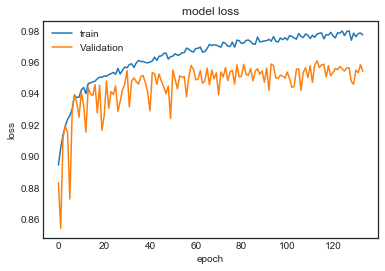

In [16]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['acc'][1:])
plt.plot(history.history['val_acc'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()


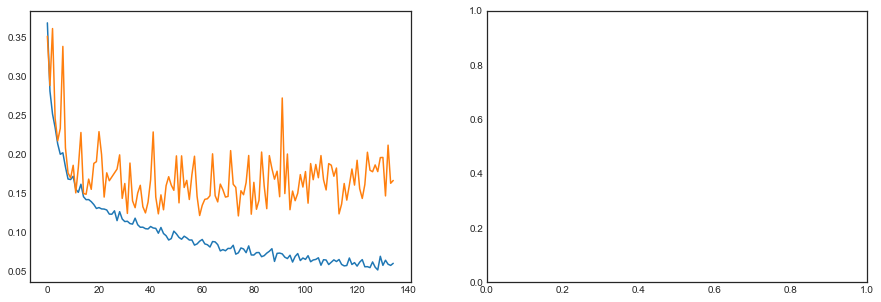

In [17]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")

In [18]:
model = load_model("./unet_best1.model")

In [19]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(a) for a in model.predict(np.array([np.fliplr(x) for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    return preds_test/2.0

In [20]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [21]:
def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

## Scoring for last model
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric(y_valid.reshape((-1, img_size_target, img_size_target)), [filter_image(img) for img in preds_valid > threshold]) for threshold in tqdm_notebook(thresholds)])


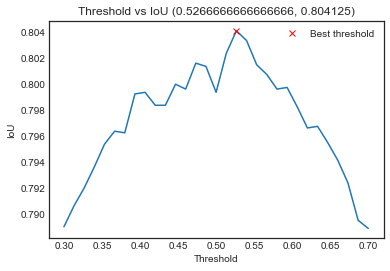

In [22]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [23]:
def rle_encode(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [24]:
import gc

del x_train, x_valid, y_train, y_valid, preds_valid
gc.collect()

113592

In [25]:
x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

preds_test = predict_result(model,x_test,img_size_target)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\GapPy36\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [26]:
import time
t1 = time.time()
pred_dict = {idx: rle_encode(filter_image(preds_test[i] > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")


Usedtime = 1.8361284732818604 s


In [28]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('u-net-with-resnet-block-1-4-0-8_submission.csv')

In [29]:
sub.head(10)

,rle_mask
id,
353e010b7b,
5439dbbddf,
71bab9f311,
52551f7a80,
512d8d9997,3351 5 3451 9 3550 14 3651 19 3752 24 3853 27 ...
64dba827d6,
0a3a8a5f37,
329563756f,1 2524 2526 100 2627 99 2728 99 2829 98 2930 9...
f6cba2e890,37 50 93 9 138 49 195 8 238 50 294 10 338 48 3...
